In [1]:
# from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm
import torch
from torch.utils.data import DataLoader
from torch import optim

import flair

import matplotlib.pyplot as plt

from dataset.dataset_batcher import SlimDataset
from models.SLIM import SLIM
from dataset.preprocessing import get_mini_batch
from helpers.train_helper import Trainer
from helpers.early_stopping import EarlyStopping
from helpers.scheduler import LinearDecayLR


  ## Notes:
  Do not forget to run the below command before starting the script
  `python -m visdom.server`

 ### Imports

In [2]:
# source: https://github.com/NVIDIA/framework-determinism/blob/master/pytorch.md

import random
import numpy as np

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
CUDA_LAUNCH_BLOCKING = 1


 ### Initialize some variables


In [3]:
dataset_dir = "/home/guszarzmo@GU.GU.SE/Corpora/slim/turk_data_torch_flair/"
model_path = "/home/guszarzmo@GU.GU.SE/LT2318/aics-project/data/models/"

file_batch = 1
no_mini_batch = 0
bert_hidden_size = 768
views_emb_size = 4
image_width = 64
image_height = 64
image_color = 3

lr_init = 5e-4
lr_final = 5e-5
step_num = 1e6

CAPTION_ENC_SZ = 64
VIEWS_ENC_SZ = 32
SC_r_SZ = 256
ITER_NUM = 12
DRAW_h_SZ = 128
DRAW_Z_SZ = 3

MINI_BATCH_SZ = 32
SAMPLE_NUM = 3200
EPOCH_STEP = int(SAMPLE_NUM / MINI_BATCH_SZ)
CHECK_POINT = EPOCH_STEP * 5

model_parameters = {
    "caption_embs_size": CAPTION_ENC_SZ,
    "views_emb_size": views_emb_size,
    "views_enc_size": VIEWS_ENC_SZ,
    "scene_rep_size": SC_r_SZ,
    "image_width": image_width,
    "image_height": image_height,
    "image_color": image_color,
    "iter_num": ITER_NUM,
    "draw_h_size": DRAW_h_SZ,
    "z_size": DRAW_Z_SZ,
}


 ### Auotomatic GPU selection

In [4]:
# Select cuda device based on the free memory
# Most of the time some cudas are busy but available
# torch.cuda.empty_cache()
use_cpu = False
prefered_device = None

if prefered_device is None:
    from utils.gpu_cuda_helper import get_gpus_avail

    cuda_idx = get_gpus_avail()
    device = None
    if not cuda_idx:
        device = torch.device("cpu")
    elif len(cuda_idx) >= 1:
        cuda_id = cuda_idx[0][0]
        if cuda_id == 0:
            cuda_id = cuda_idx[1][0]
        device = torch.device(f"cuda:{cuda_id}")
else:
    device = torch.device(prefered_device)
    

if use_cpu:
    device = torch.device("cpu")

print(f"\ndevice selected: {device}")
flair.device = device


 cuda id   Memory usage  
    0          6.65%     
    1          0.09%     
    2          0.09%     

device selected: cuda:1


 ### Initialize plotting class

In [5]:
from utils.visualization import Visualizations

# Visualization
vis = Visualizations("Loss_Visualization_7")


Setting up a new session...


 ### DataLoader

In [5]:


def custom_collate(data):
    return data


train_dataset = SlimDataset(root_dir=dataset_dir + "train")

val_dataset = SlimDataset(root_dir=dataset_dir + "valid")

test_dataset = SlimDataset(root_dir=dataset_dir + "test")

train_iter = DataLoader(train_dataset,
                        batch_size=1,
                        shuffle=True,
                        num_workers=4,
                        pin_memory=device.type == "cuda",
                        collate_fn=custom_collate)

val_iter = DataLoader(val_dataset,
                      batch_size=1,
                      shuffle=True,
                      num_workers=2,
                      pin_memory=device.type == "cuda",
                      collate_fn=custom_collate)

test_iter = DataLoader(test_dataset,
                       batch_size=file_batch,
                       shuffle=True,
                       num_workers=2,
                       collate_fn=custom_collate)


In [7]:
# import numpy as np

# tokens_num = []
# for batch_train in train_iter:
#     for data in batch_train:
#         for sent in data[2][0]:
#             tokens_num.append(len(sent))

# plt.hist(tokens_num, bins="auto")


 ### Construct the model

In [8]:
model = SLIM(model_parameters)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=lr_init)
scheduler = LinearDecayLR(optimizer)

resume = True
if resume:
    model_name = "slim_08-04-10h00_8999.pt"
    load_path = model_path + model_name
    model_data = torch.load(load_path, map_location=torch.device("cpu"))
    model_state_dict = model_data["model_state_dict"]
    optimizer_state_dict = model_data["optimizer_state_dict"]
    scheduler_state_dict = model_data["scheduler_state_dict"] 
    model.load_state_dict(model_state_dict)
    optimizer.load_state_dict(optimizer_state_dict)
    scheduler.load_state_dict(scheduler_state_dict)


 ### Model Train

In [9]:

print()
slim_train = Trainer(model,
                     device,
                     epoch_interval=EPOCH_STEP,
                     save_path=model_path,
                     check_model_size=False)

# print(f"Model memory Size: {slim_train.model_memory_gb:.2f} GB")


Global Step 0:   0%|          | 0/20000000 [00:00<?, ?GlobalStep/s]

In [10]:
# early stopping
es = EarlyStopping(patience=3, min_delta=0.1)


In [ ]:
check_grad = False

if resume:
    slim_train.global_steps = model_data["steps"]
    slim_train.best_loss = model_data["loss"]

while slim_train.in_train:
    slim_train.local_steps = 0  # 1 epoch = SAMPLE_NUM local steps
    slim_train.train_loss = 0

    # train
    with tqdm(train_iter, total=EPOCH_STEP, leave=False, unit="file") as train_pb:
        # load one file (max 64 samples per file)
        for train_batch in train_pb:
            # progress bar one step
            train_pb.set_description(f"LocalStep {slim_train.local_steps}")

            trn_mini_b = get_mini_batch(data=train_batch[0],
                                        size_=MINI_BATCH_SZ)

            with tqdm(trn_mini_b, leave=False, unit="minibatch") as minipb:
                minipb.set_description("minibatch train")

                # train min batches
                for data in minipb:
                    slim_train.train(model, optimizer, scheduler, data,
                                     check_grad)

                    # update progress bars
                    minipb.set_postfix({"train loss": slim_train.train_loss})
                    slim_train.postfix["train loss"] = slim_train.train_loss
                    slim_train.trainpb.set_postfix(slim_train.postfix)

                    if check_grad:
                        vis.plot_grad_norm(slim_train.total_norm,
                                           slim_train.global_steps + 1,
                                           "average gradient norm")

                    # eval, each CHECK_POINT steps (every 5 epochs)
                    if slim_train.global_steps % (
                            CHECK_POINT -
                            1) == 0 or slim_train.global_steps == 0:
                        model_tested = True
                        slim_train.val_loss = 0
                        slim_train.val_steps = 0
                        for val_batch in val_iter:
                            val_mini_batches = get_mini_batch(
                                data=val_batch[0], size_=1)
                            slim_train.eval(model, val_mini_batches)

                        slim_train.val_loss = \
                            slim_train.val_loss / slim_train.val_steps

                        # update main progress bar
                        slim_train.postfix["test loss"] = slim_train.val_loss
                        slim_train.trainpb.set_postfix(slim_train.postfix)

                        # plot validation
                        vis.plot_loss(slim_train.val_loss,
                                      slim_train.global_steps + 1,
                                      "Validation")

                        # save model
                        val_loss = round(slim_train.val_loss, 2)
                        best_loss = round(slim_train.best_loss, 2)
                        if val_loss <= best_loss:
                            slim_train.best_loss = slim_train.val_loss
                            slim_train.save_checkpoint(model, optimizer,
                                                       scheduler)

                        # early stopping
                        if es.step(slim_train.val_loss):
                            slim_train.train_loss = \
                                slim_train.train_loss / slim_train.local_steps
                            slim_train.in_train = False

                    # plot
                    if slim_train.global_steps % 3 == 0:
                        vis.plot_loss(slim_train.train_loss,
                                      slim_train.global_steps + 1, "Train")

                    if slim_train.epoch_finished or not slim_train.in_train:
                        break

            if slim_train.epoch_finished or not slim_train.in_train:
                slim_train.epoch_finished = False
                minipb.close()
                train_pb.close()
                if not slim_train.in_train:
                    print("\nTraining finished ...")
                break


Global Step 7487 - epoch: 0:   0%|          | 2/20000000 [00:31<97815:32:54, 17.61s/GlobalStep, train loss=25, test loss=0] 

Global Step 7489 - epoch: 0:   0%|          | 4/20000000 [00:52<78129:13:27, 14.06s/GlobalStep, train loss=22.6, test loss=0]

Global Step 7491 - epoch: 0:   0%|          | 6/20000000 [01:15<69977:08:06, 12.60s/GlobalStep, train loss=23.9, test loss=0]

Global Step 7493 - epoch: 0:   0%|          | 8/20000000 [01:39<68703:07:56, 12.37s/GlobalStep, train loss=22.6, test loss=0]

Global Step 7495 - epoch: 0:   0%|          | 10/20000000 [02:04<68926:00:27, 12.41s/GlobalStep, train loss=21.9, test loss=0]

Global Step 7497 - epoch: 0:   0%|          | 12/20000000 [02:29<68298:38:20, 12.29s/GlobalStep, train loss=24.4, test loss=0]

Global Step 7499 - epoch: 0:   0%|          | 14/20000000 [02:51<65646:07:54, 11.82s/GlobalStep, train loss=20.9, test loss=0]

Global Step 7499 - epoch: 0:   0%|          | 14/20000000 [03:02<65646:07:54, 11.82s/GlobalStep, train loss=24.5, test loss=0]

Global Step 7502 - epoch: 1:   0%|          | 16/20000000 [03:32<85204:41:57, 15.34s/GlobalStep, train loss=24.6, test loss=0]

Global Step 7504 - epoch: 1:   0%|          | 18/20000000 [03:55<74180:04:52, 13.35s/GlobalStep, train loss=22, test loss=0]  

Global Step 7506 - epoch: 1:   0%|          | 20/20000000 [04:20<71742:54:24, 12.91s/GlobalStep, train loss=24.2, test loss=0]

Global Step 7508 - epoch: 1:   0%|          | 22/20000000 [04:44<69415:03:26, 12.49s/GlobalStep, train loss=21.8, test loss=0]

Global Step 7510 - epoch: 1:   0%|          | 24/20000000 [05:11<71748:02:04, 12.91s/GlobalStep, train loss=25.9, test loss=0]

Global Step 7512 - epoch: 1:   0%|          | 26/20000000 [05:39<74986:37:15, 13.50s/GlobalStep, train loss=22.2, test loss=0]

Global Step 7514 - epoch: 1:   0%|          | 28/20000000 [06:08<77101:14:33, 13.88s/GlobalStep, train loss=25, test loss=0]  

Global Step 7516 - epoch: 1:   0%|          | 30/20000000 [06:33<72843:09:22, 13.11s/GlobalStep, train loss=21.4, test loss=0]

Global Step 7518 - epoch: 1:   0%|          | 32/20000000 [06:58<70903:28:34, 12.76s/GlobalStep, train loss=22.2, test loss=0]

Global Step 7520 - epoch: 1:   0%|          | 34/20000000 [07:21<68013:48:53, 12.24s/GlobalStep, train loss=22.5, test loss=0]

Global Step 7522 - epoch: 1:   0%|          | 36/20000000 [07:49<71837:32:02, 12.93s/GlobalStep, train loss=26, test loss=0]  

Global Step 7524 - epoch: 1:   0%|          | 38/20000000 [08:15<71487:24:11, 12.87s/GlobalStep, train loss=24.5, test loss=0]

Global Step 7526 - epoch: 1:   0%|          | 40/20000000 [08:39<69237:43:45, 12.46s/GlobalStep, train loss=22.8, test loss=0]

Global Step 7528 - epoch: 1:   0%|          | 42/20000000 [09:05<71022:25:36, 12.78s/GlobalStep, train loss=21, test loss=0]  

Global Step 7530 - epoch: 1:   0%|          | 44/20000000 [09:30<70411:24:34, 12.67s/GlobalStep, train loss=21.9, test loss=0]

Global Step 7532 - epoch: 1:   0%|          | 46/20000000 [09:56<70742:08:07, 12.73s/GlobalStep, train loss=22.3, test loss=0]

Global Step 7534 - epoch: 1:   0%|          | 48/20000000 [10:20<68269:17:52, 12.29s/GlobalStep, train loss=21, test loss=0]  

Global Step 7536 - epoch: 1:   0%|          | 50/20000000 [10:46<70322:05:40, 12.66s/GlobalStep, train loss=24.9, test loss=0]

Global Step 7538 - epoch: 1:   0%|          | 52/20000000 [11:12<71042:35:17, 12.79s/GlobalStep, train loss=23.1, test loss=0]

Global Step 7540 - epoch: 1:   0%|          | 54/20000000 [11:37<69823:43:56, 12.57s/GlobalStep, train loss=25.2, test loss=0]

Global Step 7542 - epoch: 1:   0%|          | 56/20000000 [12:01<66898:39:28, 12.04s/GlobalStep, train loss=22.8, test loss=0]

Global Step 7544 - epoch: 1:   0%|          | 58/20000000 [12:24<65594:44:56, 11.81s/GlobalStep, train loss=26.2, test loss=0]

Global Step 7546 - epoch: 1:   0%|          | 60/20000000 [12:49<67388:04:29, 12.13s/GlobalStep, train loss=25.4, test loss=0]

Global Step 7548 - epoch: 1:   0%|          | 62/20000000 [13:12<65920:22:43, 11.87s/GlobalStep, train loss=22.2, test loss=0]

Global Step 7550 - epoch: 1:   0%|          | 64/20000000 [13:37<67982:33:53, 12.24s/GlobalStep, train loss=26.5, test loss=0]

Global Step 7552 - epoch: 1:   0%|          | 66/20000000 [14:01<66543:27:07, 11.98s/GlobalStep, train loss=23.2, test loss=0]

Global Step 7554 - epoch: 1:   0%|          | 68/20000000 [14:24<65578:47:53, 11.80s/GlobalStep, train loss=22.2, test loss=0]

Global Step 7556 - epoch: 1:   0%|          | 70/20000000 [14:48<65931:06:25, 11.87s/GlobalStep, train loss=22.8, test loss=0]

Global Step 7558 - epoch: 1:   0%|          | 72/20000000 [15:12<65232:08:43, 11.74s/GlobalStep, train loss=21.5, test loss=0]

Global Step 7560 - epoch: 1:   0%|          | 74/20000000 [15:34<62799:52:08, 11.30s/GlobalStep, train loss=22.8, test loss=0]

Global Step 7562 - epoch: 1:   0%|          | 76/20000000 [15:59<66552:38:04, 11.98s/GlobalStep, train loss=24.4, test loss=0]

Global Step 7564 - epoch: 1:   0%|          | 78/20000000 [16:24<68046:17:42, 12.25s/GlobalStep, train loss=23.8, test loss=0]

Global Step 7566 - epoch: 1:   0%|          | 80/20000000 [16:49<68027:14:52, 12.24s/GlobalStep, train loss=24.4, test loss=0]

Global Step 7568 - epoch: 1:   0%|          | 82/20000000 [17:11<65067:49:00, 11.71s/GlobalStep, train loss=22.8, test loss=0]

Global Step 7570 - epoch: 1:   0%|          | 84/20000000 [17:34<64034:03:36, 11.53s/GlobalStep, train loss=22.9, test loss=0]

Global Step 7572 - epoch: 1:   0%|          | 86/20000000 [17:57<62679:18:07, 11.28s/GlobalStep, train loss=23, test loss=0]  

Global Step 7574 - epoch: 1:   0%|          | 88/20000000 [18:21<64405:38:52, 11.59s/GlobalStep, train loss=22, test loss=0]  

Global Step 7576 - epoch: 1:   0%|          | 90/20000000 [18:44<64467:54:02, 11.60s/GlobalStep, train loss=24.6, test loss=0]

Global Step 7578 - epoch: 1:   0%|          | 92/20000000 [19:09<66820:23:33, 12.03s/GlobalStep, train loss=23.5, test loss=0]

Global Step 7580 - epoch: 1:   0%|          | 94/20000000 [19:32<65137:58:25, 11.72s/GlobalStep, train loss=24.5, test loss=0]

Global Step 7582 - epoch: 1:   0%|          | 96/20000000 [19:55<64337:15:53, 11.58s/GlobalStep, train loss=25.4, test loss=0]

Global Step 7584 - epoch: 1:   0%|          | 98/20000000 [20:21<67698:01:26, 12.19s/GlobalStep, train loss=26.5, test loss=0]

Global Step 7586 - epoch: 1:   0%|          | 100/20000000 [20:44<65966:25:48, 11.87s/GlobalStep, train loss=25.1, test loss=0]

Global Step 7588 - epoch: 1:   0%|          | 102/20000000 [21:07<64992:53:22, 11.70s/GlobalStep, train loss=23.4, test loss=0]

Global Step 7590 - epoch: 1:   0%|          | 104/20000000 [21:30<63429:03:58, 11.42s/GlobalStep, train loss=23.6, test loss=0]

Global Step 7592 - epoch: 1:   0%|          | 106/20000000 [21:54<66049:34:24, 11.89s/GlobalStep, train loss=21.8, test loss=0]

Global Step 7594 - epoch: 1:   0%|          | 108/20000000 [22:18<66003:29:29, 11.88s/GlobalStep, train loss=22.5, test loss=0]

Global Step 7596 - epoch: 1:   0%|          | 110/20000000 [22:42<64667:53:57, 11.64s/GlobalStep, train loss=23.9, test loss=0]

Global Step 7598 - epoch: 1:   0%|          | 112/20000000 [23:05<63941:01:55, 11.51s/GlobalStep, train loss=23, test loss=0]  

Global Step 7599 - epoch: 1:   0%|          | 113/20000000 [23:28<64090:08:16, 11.54s/GlobalStep, train loss=23.8, test loss=0]

Global Step 7602 - epoch: 2:   0%|          | 115/20000000 [24:01<89784:31:47, 16.16s/GlobalStep, train loss=23.5, test loss=0]

Global Step 7604 - epoch: 2:   0%|          | 117/20000000 [24:24<76465:07:58, 13.76s/GlobalStep, train loss=23.6, test loss=0]

Global Step 7606 - epoch: 2:   0%|          | 119/20000000 [24:49<72974:33:34, 13.14s/GlobalStep, train loss=25.5, test loss=0]

Global Step 7608 - epoch: 2:   0%|          | 121/20000000 [25:13<69454:55:36, 12.50s/GlobalStep, train loss=25.4, test loss=0]

Global Step 7610 - epoch: 2:   0%|          | 123/20000000 [25:37<68754:05:26, 12.38s/GlobalStep, train loss=26.2, test loss=0]

Global Step 7612 - epoch: 2:   0%|          | 125/20000000 [26:02<68128:17:09, 12.26s/GlobalStep, train loss=23.8, test loss=0]

Global Step 7614 - epoch: 2:   0%|          | 127/20000000 [26:27<68556:49:11, 12.34s/GlobalStep, train loss=23.4, test loss=0]

Global Step 7616 - epoch: 2:   0%|          | 129/20000000 [26:53<69764:33:34, 12.56s/GlobalStep, train loss=22.9, test loss=0]

Global Step 7618 - epoch: 2:   0%|          | 131/20000000 [27:16<66826:51:05, 12.03s/GlobalStep, train loss=19.5, test loss=0]

Global Step 7620 - epoch: 2:   0%|          | 133/20000000 [27:41<68282:41:59, 12.29s/GlobalStep, train loss=21.5, test loss=0]

Global Step 7622 - epoch: 2:   0%|          | 135/20000000 [28:04<65288:58:17, 11.75s/GlobalStep, train loss=22.4, test loss=0]

Global Step 7624 - epoch: 2:   0%|          | 137/20000000 [28:27<64311:27:12, 11.58s/GlobalStep, train loss=22.2, test loss=0]

Global Step 7626 - epoch: 2:   0%|          | 139/20000000 [28:51<64718:08:24, 11.65s/GlobalStep, train loss=22.5, test loss=0]

Global Step 7628 - epoch: 2:   0%|          | 141/20000000 [29:17<68367:12:16, 12.31s/GlobalStep, train loss=21.4, test loss=0]

Global Step 7630 - epoch: 2:   0%|          | 143/20000000 [29:41<67683:43:18, 12.18s/GlobalStep, train loss=22.2, test loss=0]

Global Step 7632 - epoch: 2:   0%|          | 145/20000000 [30:05<66313:04:59, 11.94s/GlobalStep, train loss=22.5, test loss=0]

Global Step 7634 - epoch: 2:   0%|          | 147/20000000 [30:28<65679:16:23, 11.82s/GlobalStep, train loss=24, test loss=0]  

Global Step 7636 - epoch: 2:   0%|          | 149/20000000 [30:52<65692:09:53, 11.82s/GlobalStep, train loss=24.3, test loss=0]

Global Step 7638 - epoch: 2:   0%|          | 151/20000000 [31:17<66800:05:29, 12.02s/GlobalStep, train loss=21.9, test loss=0]

Global Step 7640 - epoch: 2:   0%|          | 153/20000000 [31:44<69969:40:02, 12.59s/GlobalStep, train loss=22.8, test loss=0]

Global Step 7642 - epoch: 2:   0%|          | 155/20000000 [32:07<66845:56:50, 12.03s/GlobalStep, train loss=22.1, test loss=0]

Global Step 7644 - epoch: 2:   0%|          | 157/20000000 [32:32<68450:05:20, 12.32s/GlobalStep, train loss=21.4, test loss=0]

Global Step 7646 - epoch: 2:   0%|          | 159/20000000 [32:55<65556:13:06, 11.80s/GlobalStep, train loss=22.7, test loss=0]

Global Step 7648 - epoch: 2:   0%|          | 161/20000000 [33:18<64226:58:35, 11.56s/GlobalStep, train loss=19.5, test loss=0]

Global Step 7650 - epoch: 2:   0%|          | 163/20000000 [33:41<64703:40:14, 11.65s/GlobalStep, train loss=22.2, test loss=0]

Global Step 7652 - epoch: 2:   0%|          | 165/20000000 [34:06<66808:05:44, 12.03s/GlobalStep, train loss=23.3, test loss=0]

Global Step 7654 - epoch: 2:   0%|          | 167/20000000 [34:30<66785:58:28, 12.02s/GlobalStep, train loss=22.1, test loss=0]

Global Step 7656 - epoch: 2:   0%|          | 169/20000000 [34:55<67790:08:43, 12.20s/GlobalStep, train loss=21.6, test loss=0]

Global Step 7658 - epoch: 2:   0%|          | 171/20000000 [35:17<64811:55:45, 11.67s/GlobalStep, train loss=23.3, test loss=0]

Global Step 7660 - epoch: 2:   0%|          | 173/20000000 [35:41<64573:16:54, 11.62s/GlobalStep, train loss=23.9, test loss=0]

Global Step 7662 - epoch: 2:   0%|          | 175/20000000 [36:06<66632:43:43, 11.99s/GlobalStep, train loss=22.9, test loss=0]

Global Step 7664 - epoch: 2:   0%|          | 177/20000000 [36:27<63058:57:12, 11.35s/GlobalStep, train loss=21.9, test loss=0]

Global Step 7666 - epoch: 2:   0%|          | 179/20000000 [36:51<64054:39:00, 11.53s/GlobalStep, train loss=23.2, test loss=0]

Global Step 7668 - epoch: 2:   0%|          | 181/20000000 [37:15<65480:14:29, 11.79s/GlobalStep, train loss=20.6, test loss=0]

Global Step 7670 - epoch: 2:   0%|          | 183/20000000 [37:37<63551:06:10, 11.44s/GlobalStep, train loss=21.7, test loss=0]

Global Step 7672 - epoch: 2:   0%|          | 185/20000000 [38:01<64757:10:36, 11.66s/GlobalStep, train loss=22.3, test loss=0]

Global Step 7673 - epoch: 2:   0%|          | 186/20000000 [38:14<65928:38:35, 11.87s/GlobalStep, train loss=21.4, test loss=0]

Global Step 7675 - epoch: 2:   0%|          | 188/20000000 [38:38<66655:53:47, 12.00s/GlobalStep, train loss=22.2, test loss=0]

Global Step 7677 - epoch: 2:   0%|          | 190/20000000 [39:02<66526:10:57, 11.97s/GlobalStep, train loss=20.2, test loss=0]

Global Step 7679 - epoch: 2:   0%|          | 192/20000000 [39:27<67657:17:04, 12.18s/GlobalStep, train loss=21.6, test loss=0]

Global Step 7681 - epoch: 2:   0%|          | 194/20000000 [39:49<64835:58:55, 11.67s/GlobalStep, train loss=20.1, test loss=0]

Global Step 7683 - epoch: 2:   0%|          | 196/20000000 [40:14<67387:21:34, 12.13s/GlobalStep, train loss=23.1, test loss=0]

Global Step 7685 - epoch: 2:   0%|          | 198/20000000 [40:39<67328:27:32, 12.12s/GlobalStep, train loss=25.8, test loss=0]

Global Step 7687 - epoch: 2:   0%|          | 200/20000000 [41:02<65814:43:45, 11.85s/GlobalStep, train loss=22.7, test loss=0]

Global Step 7689 - epoch: 2:   0%|          | 202/20000000 [41:27<67252:49:46, 12.11s/GlobalStep, train loss=22.5, test loss=0]

Global Step 7691 - epoch: 2:   0%|          | 204/20000000 [41:50<65393:23:38, 11.77s/GlobalStep, train loss=24.5, test loss=0]

Global Step 7693 - epoch: 2:   0%|          | 206/20000000 [42:14<66127:13:34, 11.90s/GlobalStep, train loss=20.8, test loss=0]

Global Step 7695 - epoch: 2:   0%|          | 208/20000000 [42:39<68278:55:20, 12.29s/GlobalStep, train loss=24.4, test loss=0]

Global Step 7697 - epoch: 2:   0%|          | 210/20000000 [43:03<67425:34:58, 12.14s/GlobalStep, train loss=22.2, test loss=0]

Global Step 7699 - epoch: 2:   0%|          | 212/20000000 [43:28<67087:00:59, 12.08s/GlobalStep, train loss=24.2, test loss=0]

Global Step 7699 - epoch: 2:   0%|          | 212/20000000 [43:40<67087:00:59, 12.08s/GlobalStep, train loss=23.3, test loss=0]

Global Step 7702 - epoch: 3:   0%|          | 214/20000000 [44:10<88221:46:11, 15.88s/GlobalStep, train loss=23.3, test loss=0]

Global Step 7704 - epoch: 3:   0%|          | 216/20000000 [44:33<75750:20:17, 13.64s/GlobalStep, train loss=23.7, test loss=0]

Global Step 7706 - epoch: 3:   0%|          | 218/20000000 [44:56<69301:04:56, 12.47s/GlobalStep, train loss=23.6, test loss=0]

Global Step 7708 - epoch: 3:   0%|          | 220/20000000 [45:20<66792:12:35, 12.02s/GlobalStep, train loss=24.2, test loss=0]

Global Step 7710 - epoch: 3:   0%|          | 222/20000000 [45:44<67546:58:44, 12.16s/GlobalStep, train loss=24.1, test loss=0]

Global Step 7712 - epoch: 3:   0%|          | 224/20000000 [46:09<67342:48:35, 12.12s/GlobalStep, train loss=27.3, test loss=0]

Global Step 7714 - epoch: 3:   0%|          | 226/20000000 [46:32<65777:25:50, 11.84s/GlobalStep, train loss=22.1, test loss=0]

Global Step 7716 - epoch: 3:   0%|          | 228/20000000 [46:56<65765:09:12, 11.84s/GlobalStep, train loss=23.4, test loss=0]

Global Step 7718 - epoch: 3:   0%|          | 230/20000000 [47:21<67246:11:45, 12.10s/GlobalStep, train loss=22.2, test loss=0]

Global Step 7720 - epoch: 3:   0%|          | 232/20000000 [47:45<67011:25:10, 12.06s/GlobalStep, train loss=21.9, test loss=0]

Global Step 7722 - epoch: 3:   0%|          | 234/20000000 [48:08<65905:51:15, 11.86s/GlobalStep, train loss=24.9, test loss=0]

Global Step 7724 - epoch: 3:   0%|          | 236/20000000 [48:33<66526:48:35, 11.97s/GlobalStep, train loss=23.5, test loss=0]

Global Step 7726 - epoch: 3:   0%|          | 238/20000000 [48:57<67376:51:31, 12.13s/GlobalStep, train loss=23.9, test loss=0]

Global Step 7728 - epoch: 3:   0%|          | 240/20000000 [49:21<66163:12:54, 11.91s/GlobalStep, train loss=22.2, test loss=0]

Global Step 7730 - epoch: 3:   0%|          | 242/20000000 [49:44<64530:20:45, 11.62s/GlobalStep, train loss=22.1, test loss=0]

Global Step 7732 - epoch: 3:   0%|          | 244/20000000 [50:07<64843:59:53, 11.67s/GlobalStep, train loss=26.1, test loss=0]

Global Step 7734 - epoch: 3:   0%|          | 246/20000000 [50:32<66049:43:51, 11.89s/GlobalStep, train loss=24.4, test loss=0]

Global Step 7736 - epoch: 3:   0%|          | 248/20000000 [50:55<65959:22:16, 11.87s/GlobalStep, train loss=25.6, test loss=0]

Global Step 7738 - epoch: 3:   0%|          | 250/20000000 [51:19<66337:12:01, 11.94s/GlobalStep, train loss=20.9, test loss=0]

Global Step 7740 - epoch: 3:   0%|          | 252/20000000 [51:44<67296:38:25, 12.11s/GlobalStep, train loss=22.1, test loss=0]

Global Step 7742 - epoch: 3:   0%|          | 254/20000000 [52:09<68736:54:34, 12.37s/GlobalStep, train loss=22.5, test loss=0]

Global Step 7744 - epoch: 3:   0%|          | 256/20000000 [52:32<66073:16:59, 11.89s/GlobalStep, train loss=24, test loss=0]  

Global Step 7746 - epoch: 3:   0%|          | 258/20000000 [52:53<62194:38:57, 11.20s/GlobalStep, train loss=21, test loss=0]  

Global Step 7748 - epoch: 3:   0%|          | 260/20000000 [53:16<62687:38:22, 11.28s/GlobalStep, train loss=20, test loss=0]

Global Step 7750 - epoch: 3:   0%|          | 262/20000000 [53:40<64008:30:52, 11.52s/GlobalStep, train loss=24.2, test loss=0]

Global Step 7752 - epoch: 3:   0%|          | 264/20000000 [54:03<64275:11:37, 11.57s/GlobalStep, train loss=21.3, test loss=0]

Global Step 7754 - epoch: 3:   0%|          | 266/20000000 [54:27<65307:24:01, 11.76s/GlobalStep, train loss=24.6, test loss=0]

Global Step 7756 - epoch: 3:   0%|          | 268/20000000 [54:50<63995:56:17, 11.52s/GlobalStep, train loss=24.2, test loss=0]

Global Step 7758 - epoch: 3:   0%|          | 270/20000000 [55:14<64791:34:24, 11.66s/GlobalStep, train loss=22.5, test loss=0]

Global Step 7760 - epoch: 3:   0%|          | 272/20000000 [55:36<63878:47:09, 11.50s/GlobalStep, train loss=24.1, test loss=0]

Global Step 7762 - epoch: 3:   0%|          | 274/20000000 [56:01<65114:46:45, 11.72s/GlobalStep, train loss=22.5, test loss=0]

Global Step 7764 - epoch: 3:   0%|          | 276/20000000 [56:24<64860:39:49, 11.68s/GlobalStep, train loss=24.2, test loss=0]

Global Step 7766 - epoch: 3:   0%|          | 278/20000000 [56:47<64217:18:16, 11.56s/GlobalStep, train loss=22.8, test loss=0]

Global Step 7768 - epoch: 3:   0%|          | 280/20000000 [57:10<64501:03:52, 11.61s/GlobalStep, train loss=23.5, test loss=0]

Global Step 7770 - epoch: 3:   0%|          | 282/20000000 [57:34<64099:21:16, 11.54s/GlobalStep, train loss=22.8, test loss=0]

Global Step 7772 - epoch: 3:   0%|          | 284/20000000 [57:55<61664:29:04, 11.10s/GlobalStep, train loss=24.1, test loss=0]

Global Step 7774 - epoch: 3:   0%|          | 286/20000000 [58:18<62493:43:09, 11.25s/GlobalStep, train loss=22.4, test loss=0]

Global Step 7776 - epoch: 3:   0%|          | 288/20000000 [58:43<66533:17:55, 11.98s/GlobalStep, train loss=23.1, test loss=0]

Global Step 7778 - epoch: 3:   0%|          | 290/20000000 [59:06<64508:58:12, 11.61s/GlobalStep, train loss=24.8, test loss=0]

Global Step 7780 - epoch: 3:   0%|          | 292/20000000 [59:29<63748:28:05, 11.47s/GlobalStep, train loss=22.1, test loss=0]

Global Step 7782 - epoch: 3:   0%|          | 294/20000000 [59:54<66939:34:21, 12.05s/GlobalStep, train loss=24.9, test loss=0]

Global Step 7784 - epoch: 3:   0%|          | 296/20000000 [1:00:18<66137:08:13, 11.90s/GlobalStep, train loss=21.1, test loss=0]

Global Step 7786 - epoch: 3:   0%|          | 298/20000000 [1:00:39<62623:13:33, 11.27s/GlobalStep, train loss=20.6, test loss=0]

Global Step 7788 - epoch: 3:   0%|          | 300/20000000 [1:01:02<63306:56:06, 11.40s/GlobalStep, train loss=23.3, test loss=0]

Global Step 7790 - epoch: 3:   0%|          | 302/20000000 [1:01:25<63517:51:42, 11.43s/GlobalStep, train loss=21.8, test loss=0]

Global Step 7792 - epoch: 3:   0%|          | 304/20000000 [1:01:49<64533:04:50, 11.62s/GlobalStep, train loss=21.7, test loss=0]

Global Step 7794 - epoch: 3:   0%|          | 306/20000000 [1:02:11<63366:10:48, 11.41s/GlobalStep, train loss=22.3, test loss=0]

Global Step 7795 - epoch: 3:   0%|          | 307/20000000 [1:02:24<64576:38:49, 11.62s/GlobalStep, train loss=20.5, test loss=0]

Global Step 7797 - epoch: 3:   0%|          | 309/20000000 [1:02:48<65745:19:26, 11.83s/GlobalStep, train loss=27.5, test loss=0]

Global Step 7799 - epoch: 3:   0%|          | 311/20000000 [1:03:12<65954:18:38, 11.87s/GlobalStep, train loss=25.6, test loss=0]

Global Step 7799 - epoch: 3:   0%|          | 311/20000000 [1:03:24<65954:18:38, 11.87s/GlobalStep, train loss=22.6, test loss=0]

Global Step 7802 - epoch: 4:   0%|          | 313/20000000 [1:03:54<86845:07:07, 15.63s/GlobalStep, train loss=22, test loss=0]  

Global Step 7804 - epoch: 4:   0%|          | 315/20000000 [1:04:18<76827:21:41, 13.83s/GlobalStep, train loss=21.8, test loss=0]

Global Step 7806 - epoch: 4:   0%|          | 317/20000000 [1:04:43<72649:18:04, 13.08s/GlobalStep, train loss=22.9, test loss=0]

Global Step 7808 - epoch: 4:   0%|          | 319/20000000 [1:05:06<68177:30:13, 12.27s/GlobalStep, train loss=23.2, test loss=0]

Global Step 7810 - epoch: 4:   0%|          | 321/20000000 [1:05:31<69144:13:54, 12.45s/GlobalStep, train loss=22.3, test loss=0]

Global Step 7812 - epoch: 4:   0%|          | 323/20000000 [1:05:57<69852:57:24, 12.57s/GlobalStep, train loss=22.3, test loss=0]

Global Step 7814 - epoch: 4:   0%|          | 325/20000000 [1:06:21<68425:43:28, 12.32s/GlobalStep, train loss=21.9, test loss=0]

Global Step 7816 - epoch: 4:   0%|          | 327/20000000 [1:06:45<66741:27:53, 12.01s/GlobalStep, train loss=22.9, test loss=0]

Global Step 7818 - epoch: 4:   0%|          | 329/20000000 [1:07:08<65261:46:14, 11.75s/GlobalStep, train loss=21, test loss=0]  

Global Step 7820 - epoch: 4:   0%|          | 331/20000000 [1:07:32<65826:41:58, 11.85s/GlobalStep, train loss=23.4, test loss=0]

Global Step 7822 - epoch: 4:   0%|          | 333/20000000 [1:07:56<65569:33:08, 11.80s/GlobalStep, train loss=24, test loss=0]  

Global Step 7824 - epoch: 4:   0%|          | 335/20000000 [1:08:18<64384:05:05, 11.59s/GlobalStep, train loss=23.9, test loss=0]

Global Step 7826 - epoch: 4:   0%|          | 337/20000000 [1:08:40<61702:24:01, 11.11s/GlobalStep, train loss=23.1, test loss=0]

Global Step 7828 - epoch: 4:   0%|          | 339/20000000 [1:09:02<61634:46:06, 11.09s/GlobalStep, train loss=21.5, test loss=0]

Global Step 7830 - epoch: 4:   0%|          | 341/20000000 [1:09:27<64921:48:24, 11.69s/GlobalStep, train loss=23.8, test loss=0]

Global Step 7832 - epoch: 4:   0%|          | 343/20000000 [1:09:49<63683:37:43, 11.46s/GlobalStep, train loss=21.1, test loss=0]

Global Step 7834 - epoch: 4:   0%|          | 345/20000000 [1:10:12<63189:50:45, 11.37s/GlobalStep, train loss=22.7, test loss=0]

Global Step 7836 - epoch: 4:   0%|          | 347/20000000 [1:10:36<63790:05:40, 11.48s/GlobalStep, train loss=23.8, test loss=0]

Global Step 7838 - epoch: 4:   0%|          | 349/20000000 [1:11:01<66801:53:35, 12.02s/GlobalStep, train loss=23, test loss=0]  

Global Step 7840 - epoch: 4:   0%|          | 351/20000000 [1:11:25<66257:08:02, 11.93s/GlobalStep, train loss=24.3, test loss=0]

Global Step 7842 - epoch: 4:   0%|          | 353/20000000 [1:11:50<67878:03:25, 12.22s/GlobalStep, train loss=22.3, test loss=0]

Global Step 7844 - epoch: 4:   0%|          | 355/20000000 [1:12:15<68199:58:23, 12.28s/GlobalStep, train loss=24.6, test loss=0]

Global Step 7846 - epoch: 4:   0%|          | 357/20000000 [1:12:38<66666:30:13, 12.00s/GlobalStep, train loss=24.3, test loss=0]

Global Step 7848 - epoch: 4:   0%|          | 359/20000000 [1:13:01<64954:32:22, 11.69s/GlobalStep, train loss=23.7, test loss=0]

Global Step 7850 - epoch: 4:   0%|          | 361/20000000 [1:13:24<64105:45:50, 11.54s/GlobalStep, train loss=25.2, test loss=0]

Global Step 7852 - epoch: 4:   0%|          | 363/20000000 [1:13:45<61128:21:10, 11.00s/GlobalStep, train loss=21.2, test loss=0]

Global Step 7854 - epoch: 4:   0%|          | 365/20000000 [1:14:09<63250:30:57, 11.39s/GlobalStep, train loss=23.2, test loss=0]

Global Step 7856 - epoch: 4:   0%|          | 367/20000000 [1:14:31<62738:22:40, 11.29s/GlobalStep, train loss=21.7, test loss=0]

Global Step 7858 - epoch: 4:   0%|          | 369/20000000 [1:14:56<65167:48:17, 11.73s/GlobalStep, train loss=22.8, test loss=0]

Global Step 7860 - epoch: 4:   0%|          | 371/20000000 [1:15:19<65112:42:19, 11.72s/GlobalStep, train loss=21, test loss=0]  

Global Step 7862 - epoch: 4:   0%|          | 373/20000000 [1:15:45<68023:52:38, 12.24s/GlobalStep, train loss=22.7, test loss=0]

Global Step 7864 - epoch: 4:   0%|          | 375/20000000 [1:16:09<67292:10:07, 12.11s/GlobalStep, train loss=24.2, test loss=0]

Global Step 7866 - epoch: 4:   0%|          | 377/20000000 [1:16:34<67874:31:53, 12.22s/GlobalStep, train loss=24.3, test loss=0]

Global Step 7868 - epoch: 4:   0%|          | 379/20000000 [1:16:55<64047:31:20, 11.53s/GlobalStep, train loss=20.8, test loss=0]

Global Step 7870 - epoch: 4:   0%|          | 381/20000000 [1:17:20<66157:25:01, 11.91s/GlobalStep, train loss=25.2, test loss=0]

Global Step 7872 - epoch: 4:   0%|          | 383/20000000 [1:17:46<68244:15:07, 12.28s/GlobalStep, train loss=24.5, test loss=0]

Global Step 7874 - epoch: 4:   0%|          | 385/20000000 [1:18:08<64470:43:53, 11.60s/GlobalStep, train loss=19.2, test loss=0]

Global Step 7876 - epoch: 4:   0%|          | 387/20000000 [1:18:31<65033:59:35, 11.71s/GlobalStep, train loss=22.1, test loss=0]

Global Step 7878 - epoch: 4:   0%|          | 389/20000000 [1:18:53<63187:34:27, 11.37s/GlobalStep, train loss=24.8, test loss=0]

Global Step 7880 - epoch: 4:   0%|          | 391/20000000 [1:19:17<64127:55:49, 11.54s/GlobalStep, train loss=22.7, test loss=0]

Global Step 7882 - epoch: 4:   0%|          | 393/20000000 [1:19:40<64033:41:47, 11.53s/GlobalStep, train loss=23.3, test loss=0]

Global Step 7884 - epoch: 4:   0%|          | 395/20000000 [1:20:05<66781:09:47, 12.02s/GlobalStep, train loss=21.5, test loss=0]

Global Step 7886 - epoch: 4:   0%|          | 397/20000000 [1:20:29<65770:40:18, 11.84s/GlobalStep, train loss=22.9, test loss=0]

Global Step 7888 - epoch: 4:   0%|          | 399/20000000 [1:20:52<64658:10:24, 11.64s/GlobalStep, train loss=23.9, test loss=0]

Global Step 7890 - epoch: 4:   0%|          | 401/20000000 [1:21:17<67983:35:00, 12.24s/GlobalStep, train loss=23.6, test loss=0]

Global Step 7892 - epoch: 4:   0%|          | 403/20000000 [1:21:42<67775:17:05, 12.20s/GlobalStep, train loss=22.8, test loss=0]

Global Step 7894 - epoch: 4:   0%|          | 405/20000000 [1:22:07<68091:38:37, 12.26s/GlobalStep, train loss=24.3, test loss=0]

Global Step 7896 - epoch: 4:   0%|          | 407/20000000 [1:22:32<69603:19:43, 12.53s/GlobalStep, train loss=21.5, test loss=0]

Global Step 7897 - epoch: 4:   0%|          | 408/20000000 [1:22:45<70528:06:12, 12.70s/GlobalStep, train loss=21.7, test loss=0]

Global Step 7899 - epoch: 4:   0%|          | 410/20000000 [1:23:11<70631:34:35, 12.71s/GlobalStep, train loss=22.4, test loss=0]

Global Step 7899 - epoch: 4:   0%|          | 410/20000000 [1:23:24<70631:34:35, 12.71s/GlobalStep, train loss=24.9, test loss=0]

Global Step 7902 - epoch: 5:   0%|          | 412/20000000 [1:23:55<91728:17:04, 16.51s/GlobalStep, train loss=25.5, test loss=0] 

Global Step 7904 - epoch: 5:   0%|          | 414/20000000 [1:24:19<79327:32:06, 14.28s/GlobalStep, train loss=25.1, test loss=0]

Global Step 7906 - epoch: 5:   0%|          | 416/20000000 [1:24:42<71861:22:48, 12.94s/GlobalStep, train loss=29, test loss=0]  

Global Step 7908 - epoch: 5:   0%|          | 418/20000000 [1:25:08<71060:22:25, 12.79s/GlobalStep, train loss=25.4, test loss=0]

Global Step 7910 - epoch: 5:   0%|          | 420/20000000 [1:25:34<71333:40:07, 12.84s/GlobalStep, train loss=30.5, test loss=0]

Global Step 7912 - epoch: 5:   0%|          | 422/20000000 [1:25:58<69251:39:48, 12.47s/GlobalStep, train loss=26.5, test loss=0]

Global Step 7914 - epoch: 5:   0%|          | 424/20000000 [1:26:22<66903:39:08, 12.04s/GlobalStep, train loss=24.9, test loss=0]

Global Step 7916 - epoch: 5:   0%|          | 426/20000000 [1:26:46<66676:35:19, 12.00s/GlobalStep, train loss=30.3, test loss=0]

Global Step 7918 - epoch: 5:   0%|          | 428/20000000 [1:27:10<66712:27:39, 12.01s/GlobalStep, train loss=25.3, test loss=0]

Global Step 7920 - epoch: 5:   0%|          | 430/20000000 [1:27:33<66022:39:46, 11.88s/GlobalStep, train loss=29, test loss=0]  

Global Step 7922 - epoch: 5:   0%|          | 432/20000000 [1:27:57<65913:15:42, 11.86s/GlobalStep, train loss=30.1, test loss=0]

Global Step 7924 - epoch: 5:   0%|          | 434/20000000 [1:28:21<66164:15:09, 11.91s/GlobalStep, train loss=26.6, test loss=0]

Global Step 7926 - epoch: 5:   0%|          | 436/20000000 [1:28:43<63279:32:24, 11.39s/GlobalStep, train loss=26.9, test loss=0]

Global Step 7928 - epoch: 5:   0%|          | 438/20000000 [1:29:07<63433:35:02, 11.42s/GlobalStep, train loss=23.9, test loss=0]

Global Step 7930 - epoch: 5:   0%|          | 440/20000000 [1:29:31<65090:48:59, 11.72s/GlobalStep, train loss=26, test loss=0]  

Global Step 7932 - epoch: 5:   0%|          | 442/20000000 [1:29:55<65826:30:39, 11.85s/GlobalStep, train loss=24.2, test loss=0]

Global Step 7934 - epoch: 5:   0%|          | 444/20000000 [1:30:18<64645:13:22, 11.64s/GlobalStep, train loss=21.3, test loss=0]

Global Step 7936 - epoch: 5:   0%|          | 446/20000000 [1:30:42<65398:09:26, 11.77s/GlobalStep, train loss=24.3, test loss=0]

Global Step 7938 - epoch: 5:   0%|          | 448/20000000 [1:31:05<64304:03:39, 11.57s/GlobalStep, train loss=22.4, test loss=0]

Global Step 7940 - epoch: 5:   0%|          | 450/20000000 [1:31:31<68711:43:34, 12.37s/GlobalStep, train loss=27, test loss=0]  

Global Step 7942 - epoch: 5:   0%|          | 452/20000000 [1:31:56<68611:57:16, 12.35s/GlobalStep, train loss=24.5, test loss=0]

Global Step 7944 - epoch: 5:   0%|          | 454/20000000 [1:32:20<66894:04:26, 12.04s/GlobalStep, train loss=25.4, test loss=0]

Global Step 7946 - epoch: 5:   0%|          | 456/20000000 [1:32:44<67719:04:34, 12.19s/GlobalStep, train loss=23.5, test loss=0]

Global Step 7948 - epoch: 5:   0%|          | 458/20000000 [1:33:07<65532:44:00, 11.80s/GlobalStep, train loss=24.1, test loss=0]

Global Step 7950 - epoch: 5:   0%|          | 460/20000000 [1:33:31<66123:57:19, 11.90s/GlobalStep, train loss=23.3, test loss=0]

Global Step 7952 - epoch: 5:   0%|          | 462/20000000 [1:33:58<69200:53:00, 12.46s/GlobalStep, train loss=21.9, test loss=0]

Global Step 7954 - epoch: 5:   0%|          | 464/20000000 [1:34:25<73236:09:07, 13.18s/GlobalStep, train loss=24.1, test loss=0]

Global Step 7956 - epoch: 5:   0%|          | 466/20000000 [1:34:51<72279:45:26, 13.01s/GlobalStep, train loss=23.8, test loss=0]

Global Step 7958 - epoch: 5:   0%|          | 468/20000000 [1:35:14<67069:09:04, 12.07s/GlobalStep, train loss=23.7, test loss=0]

Global Step 7960 - epoch: 5:   0%|          | 470/20000000 [1:35:35<62557:01:37, 11.26s/GlobalStep, train loss=23.1, test loss=0]

Global Step 7962 - epoch: 5:   0%|          | 472/20000000 [1:35:59<63876:27:34, 11.50s/GlobalStep, train loss=23.7, test loss=0]

Global Step 7964 - epoch: 5:   0%|          | 474/20000000 [1:36:22<64786:43:37, 11.66s/GlobalStep, train loss=21.3, test loss=0]

Global Step 7966 - epoch: 5:   0%|          | 476/20000000 [1:36:46<65044:47:58, 11.71s/GlobalStep, train loss=25.4, test loss=0]

Global Step 7968 - epoch: 5:   0%|          | 478/20000000 [1:37:10<65078:15:59, 11.71s/GlobalStep, train loss=24.9, test loss=0]

Global Step 7970 - epoch: 5:   0%|          | 480/20000000 [1:37:35<67462:47:38, 12.14s/GlobalStep, train loss=25.4, test loss=0]

Global Step 7972 - epoch: 5:   0%|          | 482/20000000 [1:37:58<65315:43:11, 11.76s/GlobalStep, train loss=22.5, test loss=0]

Global Step 7973 - epoch: 5:   0%|          | 483/20000000 [1:38:10<66569:05:59, 11.98s/GlobalStep, train loss=20.7, test loss=0]

Global Step 7975 - epoch: 5:   0%|          | 485/20000000 [1:38:34<66410:26:05, 11.95s/GlobalStep, train loss=24.3, test loss=0]

Global Step 7977 - epoch: 5:   0%|          | 487/20000000 [1:38:57<64562:55:18, 11.62s/GlobalStep, train loss=23, test loss=0]  

Global Step 7979 - epoch: 5:   0%|          | 489/20000000 [1:39:21<65443:29:46, 11.78s/GlobalStep, train loss=20.7, test loss=0]

Global Step 7981 - epoch: 5:   0%|          | 491/20000000 [1:39:45<65015:50:37, 11.70s/GlobalStep, train loss=24.2, test loss=0]

Global Step 7983 - epoch: 5:   0%|          | 493/20000000 [1:40:10<67377:23:31, 12.13s/GlobalStep, train loss=21.4, test loss=0]

Global Step 7984 - epoch: 5:   0%|          | 494/20000000 [1:40:22<66983:41:49, 12.06s/GlobalStep, train loss=22.6, test loss=0]


  0%|          | 0/64 [00:00<?, ?valbatch/s]


  0%|          | 0/64 [00:01<?, ?valbatch/s, test loss=29.7]


  2%|▏         | 1/64 [00:01<01:03,  1.00s/valbatch, test loss=29.7]


  2%|▏         | 1/64 [00:01<01:03,  1.01s/valbatch, test loss=29.7]


  2%|▏         | 1/64 [00:01<01:03,  1.01s/valbatch, test loss=23.4]


  3%|▎         | 2/64 [00:01<00:57,  1.07valbatch/s, test loss=23.4]


  3%|▎         | 2/64 [00:01<00:57,  1.07valbatch/s, test loss=23.4]


  3%|▎         | 2/64 [00:02<00:57,  1.07valbatch/s, test loss=36]  


  5%|▍         | 3/64 [00:02<00:54,  1.13valbatch/s, test loss=36]


  5%|▍         | 3/64 [00:02<00:54,  1.13valbatch/s, test loss=36]


  5%|▍         | 3/64 [00:03<00:54,  1.13valbatch/s, test loss=21]


  6%|▋         | 4/64 [00:03<00:51,  1.16valbatch/s, test loss=21]


  6%|▋         | 4/64 [00:03<00:51,  1.16valbatch/s, tes

 52%|█████▏    | 33/64 [00:28<00:26,  1.18valbatch/s, test loss=23.5]


 53%|█████▎    | 34/64 [00:28<00:25,  1.18valbatch/s, test loss=23.5]


 53%|█████▎    | 34/64 [00:28<00:25,  1.17valbatch/s, test loss=23.5]


 53%|█████▎    | 34/64 [00:29<00:25,  1.17valbatch/s, test loss=23.1]


 55%|█████▍    | 35/64 [00:29<00:24,  1.17valbatch/s, test loss=23.1]


 55%|█████▍    | 35/64 [00:29<00:24,  1.17valbatch/s, test loss=23.1]


 55%|█████▍    | 35/64 [00:30<00:24,  1.17valbatch/s, test loss=16.2]


 56%|█████▋    | 36/64 [00:30<00:24,  1.16valbatch/s, test loss=16.2]


 56%|█████▋    | 36/64 [00:30<00:24,  1.16valbatch/s, test loss=16.2]


 56%|█████▋    | 36/64 [00:31<00:24,  1.16valbatch/s, test loss=15.9]


 58%|█████▊    | 37/64 [00:31<00:23,  1.17valbatch/s, test loss=15.9]


 58%|█████▊    | 37/64 [00:31<00:23,  1.17valbatch/s, test loss=15.9]


 58%|█████▊    | 37/64 [00:32<00:23,  1.17valbatch/s, test loss=12.3]


 59%|█████▉    | 38/64 [00:32<00:22,  1.16valbatch/s, test loss=

  3%|▎         | 2/64 [00:02<00:54,  1.14valbatch/s, test loss=47.2]


  5%|▍         | 3/64 [00:02<00:53,  1.14valbatch/s, test loss=47.2]


  5%|▍         | 3/64 [00:02<00:53,  1.14valbatch/s, test loss=47.2]


  5%|▍         | 3/64 [00:03<00:53,  1.14valbatch/s, test loss=22.2]


  6%|▋         | 4/64 [00:03<00:52,  1.15valbatch/s, test loss=22.2]


  6%|▋         | 4/64 [00:03<00:52,  1.15valbatch/s, test loss=22.2]


  6%|▋         | 4/64 [00:04<00:52,  1.15valbatch/s, test loss=19.5]


  8%|▊         | 5/64 [00:04<00:51,  1.15valbatch/s, test loss=19.5]


  8%|▊         | 5/64 [00:04<00:51,  1.15valbatch/s, test loss=19.5]


  8%|▊         | 5/64 [00:05<00:51,  1.15valbatch/s, test loss=22.8]


  9%|▉         | 6/64 [00:05<00:50,  1.15valbatch/s, test loss=22.8]


  9%|▉         | 6/64 [00:05<00:50,  1.15valbatch/s, test loss=22.8]


  9%|▉         | 6/64 [00:06<00:50,  1.15valbatch/s, test loss=26.5]


 11%|█         | 7/64 [00:06<00:48,  1.16valbatch/s, test loss=26.5]


 11%|█

 56%|█████▋    | 36/64 [00:30<00:23,  1.20valbatch/s, test loss=14.9]


 56%|█████▋    | 36/64 [00:31<00:23,  1.20valbatch/s, test loss=21.6]


 58%|█████▊    | 37/64 [00:31<00:22,  1.21valbatch/s, test loss=21.6]


 58%|█████▊    | 37/64 [00:31<00:22,  1.21valbatch/s, test loss=21.6]


 58%|█████▊    | 37/64 [00:32<00:22,  1.21valbatch/s, test loss=14.4]


 59%|█████▉    | 38/64 [00:32<00:21,  1.21valbatch/s, test loss=14.4]


 59%|█████▉    | 38/64 [00:32<00:21,  1.21valbatch/s, test loss=14.4]


 59%|█████▉    | 38/64 [00:32<00:21,  1.21valbatch/s, test loss=25.2]


 61%|██████    | 39/64 [00:32<00:20,  1.20valbatch/s, test loss=25.2]


 61%|██████    | 39/64 [00:32<00:20,  1.20valbatch/s, test loss=25.2]


 61%|██████    | 39/64 [00:33<00:20,  1.20valbatch/s, test loss=14.2]


 62%|██████▎   | 40/64 [00:33<00:20,  1.20valbatch/s, test loss=14.2]


 62%|██████▎   | 40/64 [00:33<00:20,  1.19valbatch/s, test loss=14.2]


 62%|██████▎   | 40/64 [00:34<00:20,  1.19valbatch/s, test loss=

  8%|▊         | 5/64 [00:04<00:51,  1.15valbatch/s, test loss=19.8]


  8%|▊         | 5/64 [00:05<00:51,  1.15valbatch/s, test loss=21.6]


  9%|▉         | 6/64 [00:05<00:49,  1.17valbatch/s, test loss=21.6]


  9%|▉         | 6/64 [00:05<00:49,  1.17valbatch/s, test loss=21.6]


  9%|▉         | 6/64 [00:06<00:49,  1.17valbatch/s, test loss=69.8]


 11%|█         | 7/64 [00:06<00:48,  1.18valbatch/s, test loss=69.8]


 11%|█         | 7/64 [00:06<00:48,  1.18valbatch/s, test loss=69.8]


 11%|█         | 7/64 [00:06<00:48,  1.18valbatch/s, test loss=23.3]


 12%|█▎        | 8/64 [00:06<00:47,  1.19valbatch/s, test loss=23.3]


 12%|█▎        | 8/64 [00:06<00:47,  1.19valbatch/s, test loss=23.3]


 12%|█▎        | 8/64 [00:07<00:47,  1.19valbatch/s, test loss=28.4]


 14%|█▍        | 9/64 [00:07<00:46,  1.19valbatch/s, test loss=28.4]


 14%|█▍        | 9/64 [00:07<00:46,  1.19valbatch/s, test loss=28.4]


 14%|█▍        | 9/64 [00:08<00:46,  1.19valbatch/s, test loss=15.1]


 16%|█

 61%|██████    | 39/64 [00:32<00:21,  1.18valbatch/s, test loss=63.2]


 61%|██████    | 39/64 [00:32<00:21,  1.18valbatch/s, test loss=63.2]


 61%|██████    | 39/64 [00:33<00:21,  1.18valbatch/s, test loss=32.8]


 62%|██████▎   | 40/64 [00:33<00:20,  1.17valbatch/s, test loss=32.8]


 62%|██████▎   | 40/64 [00:33<00:20,  1.17valbatch/s, test loss=32.8]


 62%|██████▎   | 40/64 [00:34<00:20,  1.17valbatch/s, test loss=29.9]


 64%|██████▍   | 41/64 [00:34<00:19,  1.17valbatch/s, test loss=29.9]


 64%|██████▍   | 41/64 [00:34<00:19,  1.17valbatch/s, test loss=29.9]


 64%|██████▍   | 41/64 [00:35<00:19,  1.17valbatch/s, test loss=26.5]


 66%|██████▌   | 42/64 [00:35<00:18,  1.18valbatch/s, test loss=26.5]


 66%|██████▌   | 42/64 [00:35<00:18,  1.18valbatch/s, test loss=26.5]


 66%|██████▌   | 42/64 [00:36<00:18,  1.18valbatch/s, test loss=17.9]


 67%|██████▋   | 43/64 [00:36<00:17,  1.19valbatch/s, test loss=17.9]


 67%|██████▋   | 43/64 [00:36<00:17,  1.19valbatch/s, test loss=

 12%|█▎        | 8/64 [00:06<00:47,  1.18valbatch/s, test loss=40]


 12%|█▎        | 8/64 [00:07<00:47,  1.18valbatch/s, test loss=29.1]


 14%|█▍        | 9/64 [00:07<00:46,  1.18valbatch/s, test loss=29.1]


 14%|█▍        | 9/64 [00:07<00:46,  1.18valbatch/s, test loss=29.1]


 14%|█▍        | 9/64 [00:08<00:46,  1.18valbatch/s, test loss=23.1]


 16%|█▌        | 10/64 [00:08<00:45,  1.19valbatch/s, test loss=23.1]


 16%|█▌        | 10/64 [00:08<00:45,  1.19valbatch/s, test loss=23.1]


 16%|█▌        | 10/64 [00:09<00:45,  1.19valbatch/s, test loss=44.3]


 17%|█▋        | 11/64 [00:09<00:45,  1.16valbatch/s, test loss=44.3]


 17%|█▋        | 11/64 [00:09<00:45,  1.16valbatch/s, test loss=44.3]


 17%|█▋        | 11/64 [00:10<00:45,  1.16valbatch/s, test loss=20.2]


 19%|█▉        | 12/64 [00:10<00:44,  1.17valbatch/s, test loss=20.2]


 19%|█▉        | 12/64 [00:10<00:44,  1.17valbatch/s, test loss=20.2]


 19%|█▉        | 12/64 [00:11<00:44,  1.17valbatch/s, test loss=44.6]



 66%|██████▌   | 42/64 [00:34<00:18,  1.21valbatch/s, test loss=43.8]


 66%|██████▌   | 42/64 [00:34<00:18,  1.21valbatch/s, test loss=43.8]


 66%|██████▌   | 42/64 [00:35<00:18,  1.21valbatch/s, test loss=27]  


 67%|██████▋   | 43/64 [00:35<00:17,  1.22valbatch/s, test loss=27]


 67%|██████▋   | 43/64 [00:35<00:17,  1.21valbatch/s, test loss=27]


 67%|██████▋   | 43/64 [00:36<00:17,  1.21valbatch/s, test loss=30.7]


 69%|██████▉   | 44/64 [00:36<00:16,  1.22valbatch/s, test loss=30.7]


 69%|██████▉   | 44/64 [00:36<00:16,  1.22valbatch/s, test loss=30.7]


 69%|██████▉   | 44/64 [00:37<00:16,  1.22valbatch/s, test loss=16.1]


 70%|███████   | 45/64 [00:37<00:15,  1.22valbatch/s, test loss=16.1]


 70%|███████   | 45/64 [00:37<00:15,  1.22valbatch/s, test loss=16.1]


 70%|███████   | 45/64 [00:38<00:15,  1.22valbatch/s, test loss=20.3]


 72%|███████▏  | 46/64 [00:38<00:14,  1.23valbatch/s, test loss=20.3]


 72%|███████▏  | 46/64 [00:38<00:14,  1.23valbatch/s, test loss=20.3

 17%|█▋        | 11/64 [00:09<00:43,  1.23valbatch/s, test loss=19.7]


 17%|█▋        | 11/64 [00:09<00:43,  1.23valbatch/s, test loss=30.8]


 19%|█▉        | 12/64 [00:09<00:41,  1.26valbatch/s, test loss=30.8]


 19%|█▉        | 12/64 [00:09<00:41,  1.26valbatch/s, test loss=30.8]


 19%|█▉        | 12/64 [00:10<00:41,  1.26valbatch/s, test loss=19.7]


 20%|██        | 13/64 [00:10<00:40,  1.27valbatch/s, test loss=19.7]


 20%|██        | 13/64 [00:10<00:40,  1.27valbatch/s, test loss=19.7]


 20%|██        | 13/64 [00:11<00:40,  1.27valbatch/s, test loss=11.5]


 22%|██▏       | 14/64 [00:11<00:38,  1.29valbatch/s, test loss=11.5]


 22%|██▏       | 14/64 [00:11<00:38,  1.29valbatch/s, test loss=11.5]


 22%|██▏       | 14/64 [00:12<00:38,  1.29valbatch/s, test loss=20.5]


 23%|██▎       | 15/64 [00:12<00:37,  1.31valbatch/s, test loss=20.5]


 23%|██▎       | 15/64 [00:12<00:37,  1.31valbatch/s, test loss=20.5]


 23%|██▎       | 15/64 [00:12<00:37,  1.31valbatch/s, test loss=

 70%|███████   | 45/64 [00:35<00:14,  1.28valbatch/s, test loss=27.4]


 70%|███████   | 45/64 [00:35<00:14,  1.27valbatch/s, test loss=27.4]


 70%|███████   | 45/64 [00:36<00:14,  1.27valbatch/s, test loss=23.8]


 72%|███████▏  | 46/64 [00:36<00:13,  1.29valbatch/s, test loss=23.8]


 72%|███████▏  | 46/64 [00:36<00:13,  1.29valbatch/s, test loss=23.8]


 72%|███████▏  | 46/64 [00:37<00:13,  1.29valbatch/s, test loss=34.5]


 73%|███████▎  | 47/64 [00:37<00:13,  1.29valbatch/s, test loss=34.5]


 73%|███████▎  | 47/64 [00:37<00:13,  1.28valbatch/s, test loss=34.5]


 73%|███████▎  | 47/64 [00:37<00:13,  1.28valbatch/s, test loss=23.3]


 75%|███████▌  | 48/64 [00:37<00:12,  1.29valbatch/s, test loss=23.3]


 75%|███████▌  | 48/64 [00:37<00:12,  1.29valbatch/s, test loss=23.3]


 75%|███████▌  | 48/64 [00:38<00:12,  1.29valbatch/s, test loss=16.6]


 77%|███████▋  | 49/64 [00:38<00:11,  1.29valbatch/s, test loss=16.6]


 77%|███████▋  | 49/64 [00:38<00:11,  1.29valbatch/s, test loss=

 29%|██▉       | 14/48 [00:10<00:25,  1.34valbatch/s, test loss=20.1]


 29%|██▉       | 14/48 [00:10<00:25,  1.34valbatch/s, test loss=20.1]


 29%|██▉       | 14/48 [00:11<00:25,  1.34valbatch/s, test loss=41.3]


 31%|███▏      | 15/48 [00:11<00:24,  1.33valbatch/s, test loss=41.3]


 31%|███▏      | 15/48 [00:11<00:24,  1.33valbatch/s, test loss=41.3]


 31%|███▏      | 15/48 [00:12<00:24,  1.33valbatch/s, test loss=24.9]


 33%|███▎      | 16/48 [00:12<00:24,  1.33valbatch/s, test loss=24.9]


 33%|███▎      | 16/48 [00:12<00:24,  1.33valbatch/s, test loss=24.9]


 33%|███▎      | 16/48 [00:13<00:24,  1.33valbatch/s, test loss=17.8]


 35%|███▌      | 17/48 [00:13<00:23,  1.34valbatch/s, test loss=17.8]


 35%|███▌      | 17/48 [00:13<00:23,  1.33valbatch/s, test loss=17.8]


 35%|███▌      | 17/48 [00:13<00:23,  1.33valbatch/s, test loss=25.4]


 38%|███▊      | 18/48 [00:13<00:22,  1.34valbatch/s, test loss=25.4]


 38%|███▊      | 18/48 [00:13<00:22,  1.34valbatch/s, test loss=

 98%|█████████▊| 47/48 [00:36<00:00,  1.34valbatch/s, test loss=47.7]


100%|██████████| 48/48 [00:36<00:00,  1.34valbatch/s, test loss=47.7]


100%|██████████| 48/48 [00:36<00:00,  1.33valbatch/s, test loss=47.7]


                                                                     


  0%|          | 0/64 [00:00<?, ?valbatch/s]


  0%|          | 0/64 [00:00<?, ?valbatch/s, test loss=15.2]


  2%|▏         | 1/64 [00:00<00:46,  1.35valbatch/s, test loss=15.2]


  2%|▏         | 1/64 [00:00<00:46,  1.35valbatch/s, test loss=15.2]


  2%|▏         | 1/64 [00:01<00:46,  1.35valbatch/s, test loss=17]  


  3%|▎         | 2/64 [00:01<00:46,  1.33valbatch/s, test loss=17]


  3%|▎         | 2/64 [00:01<00:46,  1.33valbatch/s, test loss=17]


  3%|▎         | 2/64 [00:02<00:46,  1.33valbatch/s, test loss=20.5]


  5%|▍         | 3/64 [00:02<00:45,  1.36valbatch/s, test loss=20.5]


  5%|▍         | 3/64 [00:02<00:45,  1.35valbatch/s, test loss=20.5]


  5%|▍         | 3/64 [00:02<00:45,  1

 52%|█████▏    | 33/64 [00:23<00:22,  1.39valbatch/s, test loss=15.9]


 52%|█████▏    | 33/64 [00:23<00:22,  1.39valbatch/s, test loss=15.9]


 52%|█████▏    | 33/64 [00:24<00:22,  1.39valbatch/s, test loss=22.3]


 53%|█████▎    | 34/64 [00:24<00:21,  1.37valbatch/s, test loss=22.3]


 53%|█████▎    | 34/64 [00:24<00:21,  1.37valbatch/s, test loss=22.3]


 53%|█████▎    | 34/64 [00:25<00:21,  1.37valbatch/s, test loss=19]  


 55%|█████▍    | 35/64 [00:25<00:21,  1.37valbatch/s, test loss=19]


 55%|█████▍    | 35/64 [00:25<00:21,  1.37valbatch/s, test loss=19]


 55%|█████▍    | 35/64 [00:25<00:21,  1.37valbatch/s, test loss=16.9]


 56%|█████▋    | 36/64 [00:25<00:20,  1.38valbatch/s, test loss=16.9]


 56%|█████▋    | 36/64 [00:25<00:20,  1.38valbatch/s, test loss=16.9]


 56%|█████▋    | 36/64 [00:26<00:20,  1.38valbatch/s, test loss=24]  


 58%|█████▊    | 37/64 [00:26<00:19,  1.38valbatch/s, test loss=24]


 58%|█████▊    | 37/64 [00:26<00:19,  1.38valbatch/s, test loss=24]




Global Step 7987 - epoch: 5:   0%|          | 497/20000000 [1:47:04<366222:15:05, 65.92s/GlobalStep, train loss=25.2, test loss=25] 

Global Step 7989 - epoch: 5:   0%|          | 499/20000000 [1:47:29<214925:58:24, 38.69s/GlobalStep, train loss=22, test loss=25]  

Global Step 7991 - epoch: 5:   0%|          | 501/20000000 [1:47:54<139039:48:51, 25.03s/GlobalStep, train loss=22.1, test loss=25]

Global Step 7993 - epoch: 5:   0%|          | 503/20000000 [1:48:19<103370:03:50, 18.61s/GlobalStep, train loss=25, test loss=25]  

Global Step 7995 - epoch: 5:   0%|          | 505/20000000 [1:48:44<86588:22:29, 15.59s/GlobalStep, train loss=22.9, test loss=25]

Global Step 7997 - epoch: 5:   0%|          | 507/20000000 [1:49:08<76144:37:06, 13.71s/GlobalStep, train loss=21.4, test loss=25]

Global Step 7999 - epoch: 5:   0%|          | 509/20000000 [1:49:31<69355:58:07, 12.48s/GlobalStep, train loss=24.2, test loss=25]

Global Step 7999 - epoch: 5:   0%|          | 509/20000000 [1:49:45<69355:58:07, 12.48s/GlobalStep, train loss=23.1, test loss=25]

Global Step 8002 - epoch: 6:   0%|          | 511/20000000 [1:50:14<89230:32:29, 16.06s/GlobalStep, train loss=23.4, test loss=25] 

Global Step 8004 - epoch: 6:   0%|          | 513/20000000 [1:50:38<78485:02:00, 14.13s/GlobalStep, train loss=22.1, test loss=25]

Global Step 8006 - epoch: 6:   0%|          | 515/20000000 [1:51:01<70894:32:46, 12.76s/GlobalStep, train loss=23.5, test loss=25]

Global Step 8008 - epoch: 6:   0%|          | 517/20000000 [1:51:24<66903:56:23, 12.04s/GlobalStep, train loss=23.1, test loss=25]

Global Step 8010 - epoch: 6:   0%|          | 519/20000000 [1:51:48<66845:45:01, 12.03s/GlobalStep, train loss=22.4, test loss=25]

Global Step 8012 - epoch: 6:   0%|          | 521/20000000 [1:52:13<66745:56:12, 12.01s/GlobalStep, train loss=22.9, test loss=25]

Global Step 8014 - epoch: 6:   0%|          | 523/20000000 [1:52:36<65430:36:06, 11.78s/GlobalStep, train loss=23.3, test loss=25]

Global Step 8016 - epoch: 6:   0%|          | 525/20000000 [1:53:00<66483:13:52, 11.97s/GlobalStep, train loss=21, test loss=25]  

Global Step 8018 - epoch: 6:   0%|          | 527/20000000 [1:53:24<66313:14:44, 11.94s/GlobalStep, train loss=21.9, test loss=25]

Global Step 8020 - epoch: 6:   0%|          | 529/20000000 [1:53:48<66481:19:50, 11.97s/GlobalStep, train loss=22.6, test loss=25]

Global Step 8022 - epoch: 6:   0%|          | 531/20000000 [1:54:12<65948:02:50, 11.87s/GlobalStep, train loss=20.3, test loss=25]

Global Step 8024 - epoch: 6:   0%|          | 533/20000000 [1:54:36<65551:44:05, 11.80s/GlobalStep, train loss=23.1, test loss=25]

Global Step 8026 - epoch: 6:   0%|          | 535/20000000 [1:54:57<63198:00:40, 11.38s/GlobalStep, train loss=21.1, test loss=25]

Global Step 8028 - epoch: 6:   0%|          | 537/20000000 [1:55:21<63871:01:35, 11.50s/GlobalStep, train loss=18.8, test loss=25]

Global Step 8030 - epoch: 6:   0%|          | 539/20000000 [1:55:45<64650:13:33, 11.64s/GlobalStep, train loss=23.2, test loss=25]

Global Step 8032 - epoch: 6:   0%|          | 541/20000000 [1:56:07<63263:02:16, 11.39s/GlobalStep, train loss=23.4, test loss=25]

Global Step 8034 - epoch: 6:   0%|          | 543/20000000 [1:56:31<64402:46:15, 11.59s/GlobalStep, train loss=22.4, test loss=25]

Global Step 8036 - epoch: 6:   0%|          | 545/20000000 [1:56:57<68950:26:20, 12.41s/GlobalStep, train loss=22.3, test loss=25]

Global Step 8038 - epoch: 6:   0%|          | 547/20000000 [1:57:21<67480:40:58, 12.15s/GlobalStep, train loss=22.4, test loss=25]

Global Step 8040 - epoch: 6:   0%|          | 549/20000000 [1:57:47<68975:12:56, 12.42s/GlobalStep, train loss=24.3, test loss=25]

Global Step 8042 - epoch: 6:   0%|          | 551/20000000 [1:58:11<67979:50:31, 12.24s/GlobalStep, train loss=21.9, test loss=25]

Global Step 8044 - epoch: 6:   0%|          | 553/20000000 [1:58:35<66923:18:24, 12.05s/GlobalStep, train loss=22.5, test loss=25]

Global Step 8046 - epoch: 6:   0%|          | 555/20000000 [1:59:00<69212:02:44, 12.46s/GlobalStep, train loss=21.3, test loss=25]

Global Step 8048 - epoch: 6:   0%|          | 557/20000000 [1:59:23<66243:46:04, 11.92s/GlobalStep, train loss=23.1, test loss=25]

Global Step 8050 - epoch: 6:   0%|          | 559/20000000 [1:59:46<64043:53:45, 11.53s/GlobalStep, train loss=21.4, test loss=25]

Global Step 8052 - epoch: 6:   0%|          | 561/20000000 [2:00:12<68467:23:13, 12.32s/GlobalStep, train loss=22.9, test loss=25]

Global Step 8054 - epoch: 6:   0%|          | 563/20000000 [2:00:37<68636:09:49, 12.35s/GlobalStep, train loss=22.4, test loss=25]

Global Step 8056 - epoch: 6:   0%|          | 565/20000000 [2:01:02<68374:31:16, 12.31s/GlobalStep, train loss=25.8, test loss=25]

Global Step 8058 - epoch: 6:   0%|          | 567/20000000 [2:01:23<63527:31:06, 11.44s/GlobalStep, train loss=20.7, test loss=25]

Global Step 8060 - epoch: 6:   0%|          | 569/20000000 [2:01:47<64660:46:17, 11.64s/GlobalStep, train loss=24.9, test loss=25]

Global Step 8062 - epoch: 6:   0%|          | 571/20000000 [2:02:10<63602:43:01, 11.45s/GlobalStep, train loss=22, test loss=25]  

Global Step 8064 - epoch: 6:   0%|          | 573/20000000 [2:02:34<65827:28:42, 11.85s/GlobalStep, train loss=20.6, test loss=25]

Global Step 8066 - epoch: 6:   0%|          | 575/20000000 [2:02:56<62806:06:55, 11.31s/GlobalStep, train loss=21.8, test loss=25]

Global Step 8068 - epoch: 6:   0%|          | 577/20000000 [2:03:21<65174:10:54, 11.73s/GlobalStep, train loss=21.6, test loss=25]

Global Step 8070 - epoch: 6:   0%|          | 579/20000000 [2:03:44<65314:55:01, 11.76s/GlobalStep, train loss=22.1, test loss=25]

Global Step 8072 - epoch: 6:   0%|          | 581/20000000 [2:04:08<64660:54:50, 11.64s/GlobalStep, train loss=22.1, test loss=25]

Global Step 8074 - epoch: 6:   0%|          | 583/20000000 [2:04:32<65915:33:52, 11.87s/GlobalStep, train loss=24.1, test loss=25]

Global Step 8076 - epoch: 6:   0%|          | 585/20000000 [2:04:55<65075:07:39, 11.71s/GlobalStep, train loss=23.3, test loss=25]

Global Step 8078 - epoch: 6:   0%|          | 587/20000000 [2:05:18<64453:13:04, 11.60s/GlobalStep, train loss=21.8, test loss=25]

Global Step 8080 - epoch: 6:   0%|          | 589/20000000 [2:05:43<66210:19:09, 11.92s/GlobalStep, train loss=23.4, test loss=25]

Global Step 8082 - epoch: 6:   0%|          | 591/20000000 [2:06:05<63015:17:13, 11.34s/GlobalStep, train loss=22.1, test loss=25]

Global Step 8084 - epoch: 6:   0%|          | 593/20000000 [2:06:28<63447:07:38, 11.42s/GlobalStep, train loss=21.8, test loss=25]

Global Step 8086 - epoch: 6:   0%|          | 595/20000000 [2:06:51<63909:43:23, 11.50s/GlobalStep, train loss=22.1, test loss=25]

Global Step 8088 - epoch: 6:   0%|          | 597/20000000 [2:07:17<67626:55:00, 12.17s/GlobalStep, train loss=23.6, test loss=25]

Global Step 8090 - epoch: 6:   0%|          | 599/20000000 [2:07:41<66952:42:52, 12.05s/GlobalStep, train loss=22.3, test loss=25]

Global Step 8092 - epoch: 6:   0%|          | 601/20000000 [2:08:05<66284:44:22, 11.93s/GlobalStep, train loss=23, test loss=25]  

Global Step 8094 - epoch: 6:   0%|          | 603/20000000 [2:08:30<68022:34:07, 12.24s/GlobalStep, train loss=24.5, test loss=25]

Global Step 8096 - epoch: 6:   0%|          | 605/20000000 [2:08:53<66024:14:41, 11.88s/GlobalStep, train loss=21.1, test loss=25]

Global Step 8098 - epoch: 6:   0%|          | 607/20000000 [2:09:15<63034:16:37, 11.35s/GlobalStep, train loss=19.7, test loss=25]

Global Step 8099 - epoch: 6:   0%|          | 608/20000000 [2:09:41<65755:17:19, 11.84s/GlobalStep, train loss=21.3, test loss=25]

Global Step 8102 - epoch: 7:   0%|          | 610/20000000 [2:10:14<91508:17:40, 16.47s/GlobalStep, train loss=20.4, test loss=25] 

Global Step 8104 - epoch: 7:   0%|          | 612/20000000 [2:10:38<78549:31:37, 14.14s/GlobalStep, train loss=21.3, test loss=25]

Global Step 8106 - epoch: 7:   0%|          | 614/20000000 [2:11:04<75776:21:05, 13.64s/GlobalStep, train loss=20.8, test loss=25]

Global Step 8108 - epoch: 7:   0%|          | 616/20000000 [2:11:27<69276:45:24, 12.47s/GlobalStep, train loss=21.7, test loss=25]

Global Step 8110 - epoch: 7:   0%|          | 618/20000000 [2:11:52<68864:02:55, 12.40s/GlobalStep, train loss=21.9, test loss=25]

Global Step 8112 - epoch: 7:   0%|          | 620/20000000 [2:12:14<64269:48:51, 11.57s/GlobalStep, train loss=22.3, test loss=25]

Global Step 8114 - epoch: 7:   0%|          | 622/20000000 [2:12:38<65977:44:19, 11.88s/GlobalStep, train loss=22.6, test loss=25]

Global Step 8116 - epoch: 7:   0%|          | 624/20000000 [2:13:04<68373:24:01, 12.31s/GlobalStep, train loss=22.6, test loss=25]

Global Step 8118 - epoch: 7:   0%|          | 626/20000000 [2:13:30<70036:11:00, 12.61s/GlobalStep, train loss=24.5, test loss=25]

Global Step 8120 - epoch: 7:   0%|          | 628/20000000 [2:13:54<68122:02:51, 12.26s/GlobalStep, train loss=20.8, test loss=25]

Global Step 8122 - epoch: 7:   0%|          | 630/20000000 [2:14:18<67208:45:49, 12.10s/GlobalStep, train loss=21.6, test loss=25]

Global Step 8124 - epoch: 7:   0%|          | 632/20000000 [2:14:43<68804:43:45, 12.39s/GlobalStep, train loss=21.4, test loss=25]

Global Step 8126 - epoch: 7:   0%|          | 634/20000000 [2:15:07<66784:07:58, 12.02s/GlobalStep, train loss=25.9, test loss=25]

Global Step 8128 - epoch: 7:   0%|          | 636/20000000 [2:15:31<65867:13:59, 11.86s/GlobalStep, train loss=22.6, test loss=25]

Global Step 8130 - epoch: 7:   0%|          | 638/20000000 [2:15:54<65378:38:14, 11.77s/GlobalStep, train loss=21.4, test loss=25]

Global Step 8132 - epoch: 7:   0%|          | 640/20000000 [2:16:20<68405:10:15, 12.31s/GlobalStep, train loss=25.7, test loss=25]

Global Step 8134 - epoch: 7:   0%|          | 642/20000000 [2:16:44<67457:22:44, 12.14s/GlobalStep, train loss=22.5, test loss=25]

Global Step 8136 - epoch: 7:   0%|          | 644/20000000 [2:17:07<65898:53:03, 11.86s/GlobalStep, train loss=21.8, test loss=25]

Global Step 8138 - epoch: 7:   0%|          | 646/20000000 [2:17:33<68575:29:36, 12.34s/GlobalStep, train loss=22.9, test loss=25]

Global Step 8140 - epoch: 7:   0%|          | 648/20000000 [2:17:57<67818:53:41, 12.21s/GlobalStep, train loss=18.9, test loss=25]

Global Step 8142 - epoch: 7:   0%|          | 650/20000000 [2:18:21<66842:06:06, 12.03s/GlobalStep, train loss=24.2, test loss=25]

Global Step 8144 - epoch: 7:   0%|          | 652/20000000 [2:18:45<66302:22:29, 11.93s/GlobalStep, train loss=23.1, test loss=25]

Global Step 8146 - epoch: 7:   0%|          | 654/20000000 [2:19:11<69018:25:07, 12.42s/GlobalStep, train loss=20.2, test loss=25]

Global Step 8148 - epoch: 7:   0%|          | 656/20000000 [2:19:35<67781:06:41, 12.20s/GlobalStep, train loss=21.3, test loss=25]

Global Step 8150 - epoch: 7:   0%|          | 658/20000000 [2:19:59<67768:03:21, 12.20s/GlobalStep, train loss=19.6, test loss=25]

Global Step 8152 - epoch: 7:   0%|          | 660/20000000 [2:20:24<68156:02:57, 12.27s/GlobalStep, train loss=23.6, test loss=25]

Global Step 8154 - epoch: 7:   0%|          | 662/20000000 [2:20:48<66129:41:11, 11.90s/GlobalStep, train loss=22.4, test loss=25]

Global Step 8156 - epoch: 7:   0%|          | 664/20000000 [2:21:11<64739:17:51, 11.65s/GlobalStep, train loss=20.6, test loss=25]

Global Step 8158 - epoch: 7:   0%|          | 666/20000000 [2:21:34<65187:50:07, 11.73s/GlobalStep, train loss=24.8, test loss=25]

Global Step 8160 - epoch: 7:   0%|          | 668/20000000 [2:22:00<68310:47:18, 12.30s/GlobalStep, train loss=21.8, test loss=25]

Global Step 8162 - epoch: 7:   0%|          | 670/20000000 [2:22:25<68971:24:23, 12.42s/GlobalStep, train loss=22.1, test loss=25]

Global Step 8164 - epoch: 7:   0%|          | 672/20000000 [2:22:50<67592:18:35, 12.17s/GlobalStep, train loss=20.8, test loss=25]

Global Step 8166 - epoch: 7:   0%|          | 674/20000000 [2:23:13<66810:22:20, 12.03s/GlobalStep, train loss=25.3, test loss=25]

Global Step 8168 - epoch: 7:   0%|          | 676/20000000 [2:23:36<64793:40:32, 11.66s/GlobalStep, train loss=21.2, test loss=25]

Global Step 8170 - epoch: 7:   0%|          | 678/20000000 [2:23:58<62538:35:56, 11.26s/GlobalStep, train loss=19.6, test loss=25]

Global Step 8172 - epoch: 7:   0%|          | 680/20000000 [2:24:23<64584:51:51, 11.63s/GlobalStep, train loss=22.5, test loss=25]

Global Step 8174 - epoch: 7:   0%|          | 682/20000000 [2:24:46<64436:22:32, 11.60s/GlobalStep, train loss=22.4, test loss=25]

Global Step 8176 - epoch: 7:   0%|          | 684/20000000 [2:25:10<64865:18:56, 11.68s/GlobalStep, train loss=22.1, test loss=25]

Global Step 8178 - epoch: 7:   0%|          | 686/20000000 [2:25:33<65258:21:28, 11.75s/GlobalStep, train loss=25.2, test loss=25]

Global Step 8180 - epoch: 7:   0%|          | 688/20000000 [2:25:56<64762:47:43, 11.66s/GlobalStep, train loss=24, test loss=25]  

Global Step 8182 - epoch: 7:   0%|          | 690/20000000 [2:26:20<65374:06:58, 11.77s/GlobalStep, train loss=23.4, test loss=25]

Global Step 8184 - epoch: 7:   0%|          | 692/20000000 [2:26:43<64746:37:35, 11.65s/GlobalStep, train loss=22.2, test loss=25]

Global Step 8186 - epoch: 7:   0%|          | 694/20000000 [2:27:07<64514:35:59, 11.61s/GlobalStep, train loss=21.6, test loss=25]

Global Step 8188 - epoch: 7:   0%|          | 696/20000000 [2:27:29<62402:09:12, 11.23s/GlobalStep, train loss=20.1, test loss=25]

Global Step 8190 - epoch: 7:   0%|          | 698/20000000 [2:27:52<63636:33:42, 11.45s/GlobalStep, train loss=24.1, test loss=25]

Global Step 8192 - epoch: 7:   0%|          | 700/20000000 [2:28:17<65361:55:31, 11.77s/GlobalStep, train loss=22.2, test loss=25]

Global Step 8194 - epoch: 7:   0%|          | 702/20000000 [2:28:40<64705:07:02, 11.65s/GlobalStep, train loss=24.1, test loss=25]

Global Step 8196 - epoch: 7:   0%|          | 704/20000000 [2:29:04<65385:09:27, 11.77s/GlobalStep, train loss=24.4, test loss=25]

Global Step 8198 - epoch: 7:   0%|          | 706/20000000 [2:29:27<64679:41:23, 11.64s/GlobalStep, train loss=23.3, test loss=25]

Global Step 8199 - epoch: 7:   0%|          | 707/20000000 [2:29:50<66552:19:35, 11.98s/GlobalStep, train loss=22.2, test loss=25]

Global Step 8202 - epoch: 8:   0%|          | 709/20000000 [2:30:21<87197:20:40, 15.70s/GlobalStep, train loss=22.9, test loss=25]

Global Step 8204 - epoch: 8:   0%|          | 711/20000000 [2:30:44<75476:04:40, 13.59s/GlobalStep, train loss=21.5, test loss=25]

Global Step 8206 - epoch: 8:   0%|          | 713/20000000 [2:31:08<70879:27:52, 12.76s/GlobalStep, train loss=23.8, test loss=25]

Global Step 8208 - epoch: 8:   0%|          | 715/20000000 [2:31:31<66322:45:16, 11.94s/GlobalStep, train loss=22.1, test loss=25]

Global Step 8210 - epoch: 8:   0%|          | 717/20000000 [2:31:54<64906:47:20, 11.68s/GlobalStep, train loss=19.1, test loss=25]

Global Step 8212 - epoch: 8:   0%|          | 719/20000000 [2:32:18<65774:13:11, 11.84s/GlobalStep, train loss=25.6, test loss=25]

Global Step 8214 - epoch: 8:   0%|          | 721/20000000 [2:32:41<65310:55:02, 11.76s/GlobalStep, train loss=20.4, test loss=25]

Global Step 8216 - epoch: 8:   0%|          | 723/20000000 [2:33:06<65992:27:43, 11.88s/GlobalStep, train loss=21.3, test loss=25]

Global Step 8218 - epoch: 8:   0%|          | 725/20000000 [2:33:30<67322:01:38, 12.12s/GlobalStep, train loss=23.3, test loss=25]

Global Step 8220 - epoch: 8:   0%|          | 727/20000000 [2:33:52<63725:50:12, 11.47s/GlobalStep, train loss=18.7, test loss=25]

Global Step 8222 - epoch: 8:   0%|          | 729/20000000 [2:34:18<66949:19:57, 12.05s/GlobalStep, train loss=22.6, test loss=25]

Global Step 8224 - epoch: 8:   0%|          | 731/20000000 [2:34:45<70578:15:39, 12.70s/GlobalStep, train loss=24, test loss=25]  

Global Step 8226 - epoch: 8:   0%|          | 733/20000000 [2:35:13<74210:32:13, 13.36s/GlobalStep, train loss=24.6, test loss=25]

Global Step 8228 - epoch: 8:   0%|          | 735/20000000 [2:35:39<73784:04:10, 13.28s/GlobalStep, train loss=22.4, test loss=25]

Global Step 8230 - epoch: 8:   0%|          | 737/20000000 [2:36:07<75451:42:20, 13.58s/GlobalStep, train loss=20.9, test loss=25]

Global Step 8232 - epoch: 8:   0%|          | 739/20000000 [2:36:34<75547:45:54, 13.60s/GlobalStep, train loss=23.5, test loss=25]

Global Step 8234 - epoch: 8:   0%|          | 741/20000000 [2:36:58<69853:08:21, 12.57s/GlobalStep, train loss=23.2, test loss=25]

Global Step 8236 - epoch: 8:   0%|          | 743/20000000 [2:37:22<67399:46:43, 12.13s/GlobalStep, train loss=23.3, test loss=25]

Global Step 8238 - epoch: 8:   0%|          | 745/20000000 [2:37:45<66268:33:53, 11.93s/GlobalStep, train loss=22.1, test loss=25]

Global Step 8240 - epoch: 8:   0%|          | 747/20000000 [2:38:08<64143:23:09, 11.55s/GlobalStep, train loss=21.7, test loss=25]

Global Step 8242 - epoch: 8:   0%|          | 749/20000000 [2:38:31<64472:35:10, 11.61s/GlobalStep, train loss=22.1, test loss=25]

Global Step 8244 - epoch: 8:   0%|          | 751/20000000 [2:38:55<64838:03:58, 11.67s/GlobalStep, train loss=20.1, test loss=25]

Global Step 8246 - epoch: 8:   0%|          | 753/20000000 [2:39:17<63248:57:27, 11.39s/GlobalStep, train loss=21, test loss=25]  

Global Step 8248 - epoch: 8:   0%|          | 755/20000000 [2:39:41<64169:07:25, 11.55s/GlobalStep, train loss=20.8, test loss=25]

Global Step 8250 - epoch: 8:   0%|          | 757/20000000 [2:40:05<64953:43:16, 11.69s/GlobalStep, train loss=23.1, test loss=25]

Global Step 8252 - epoch: 8:   0%|          | 759/20000000 [2:40:30<67971:52:19, 12.24s/GlobalStep, train loss=20.5, test loss=25]

Global Step 8254 - epoch: 8:   0%|          | 761/20000000 [2:40:57<70909:51:11, 12.76s/GlobalStep, train loss=22.3, test loss=25]

Global Step 8256 - epoch: 8:   0%|          | 763/20000000 [2:41:23<71758:14:44, 12.92s/GlobalStep, train loss=20.8, test loss=25]

Global Step 8258 - epoch: 8:   0%|          | 765/20000000 [2:41:47<67692:05:56, 12.19s/GlobalStep, train loss=21.7, test loss=25]

Global Step 8260 - epoch: 8:   0%|          | 767/20000000 [2:42:12<68403:49:32, 12.31s/GlobalStep, train loss=22.2, test loss=25]

Global Step 8262 - epoch: 8:   0%|          | 769/20000000 [2:42:36<67481:10:12, 12.15s/GlobalStep, train loss=21.8, test loss=25]

Global Step 8264 - epoch: 8:   0%|          | 771/20000000 [2:42:59<65670:09:32, 11.82s/GlobalStep, train loss=22.9, test loss=25]

Global Step 8266 - epoch: 8:   0%|          | 773/20000000 [2:43:22<64626:45:12, 11.63s/GlobalStep, train loss=19.7, test loss=25]

Global Step 8268 - epoch: 8:   0%|          | 775/20000000 [2:43:45<63958:43:53, 11.51s/GlobalStep, train loss=23.4, test loss=25]

Global Step 8270 - epoch: 8:   0%|          | 777/20000000 [2:44:10<65965:45:30, 11.87s/GlobalStep, train loss=19.8, test loss=25]

Global Step 8272 - epoch: 8:   0%|          | 779/20000000 [2:44:34<65466:27:32, 11.78s/GlobalStep, train loss=22.9, test loss=25]

Global Step 8274 - epoch: 8:   0%|          | 781/20000000 [2:44:55<62345:04:40, 11.22s/GlobalStep, train loss=21, test loss=25]  

Global Step 8276 - epoch: 8:   0%|          | 783/20000000 [2:45:19<64108:22:48, 11.54s/GlobalStep, train loss=23.2, test loss=25]

Global Step 8278 - epoch: 8:   0%|          | 785/20000000 [2:45:43<64974:52:58, 11.70s/GlobalStep, train loss=22, test loss=25]  

Global Step 8280 - epoch: 8:   0%|          | 787/20000000 [2:46:07<65286:34:33, 11.75s/GlobalStep, train loss=21.6, test loss=25]

Global Step 8282 - epoch: 8:   0%|          | 789/20000000 [2:46:33<68956:08:39, 12.41s/GlobalStep, train loss=20.8, test loss=25]

Global Step 8284 - epoch: 8:   0%|          | 791/20000000 [2:46:57<67584:45:11, 12.17s/GlobalStep, train loss=21.3, test loss=25]

Global Step 8286 - epoch: 8:   0%|          | 793/20000000 [2:47:21<67179:50:34, 12.09s/GlobalStep, train loss=22.5, test loss=25]

Global Step 8288 - epoch: 8:   0%|          | 795/20000000 [2:47:45<65997:41:32, 11.88s/GlobalStep, train loss=22.8, test loss=25]

Global Step 8289 - epoch: 8:   0%|          | 796/20000000 [2:47:58<67401:43:55, 12.13s/GlobalStep, train loss=19, test loss=25]  

Global Step 8291 - epoch: 8:   0%|          | 798/20000000 [2:48:21<65770:41:28, 11.84s/GlobalStep, train loss=23.8, test loss=25]

Global Step 8293 - epoch: 8:   0%|          | 800/20000000 [2:48:44<64334:05:38, 11.58s/GlobalStep, train loss=21.4, test loss=25]

Global Step 8295 - epoch: 8:   0%|          | 802/20000000 [2:49:09<67241:05:20, 12.10s/GlobalStep, train loss=20.3, test loss=25]

Global Step 8297 - epoch: 8:   0%|          | 804/20000000 [2:49:34<67779:10:16, 12.20s/GlobalStep, train loss=21.2, test loss=25]

Global Step 8299 - epoch: 8:   0%|          | 806/20000000 [2:49:58<67011:39:52, 12.06s/GlobalStep, train loss=21.2, test loss=25]

Global Step 8299 - epoch: 8:   0%|          | 806/20000000 [2:50:11<67011:39:52, 12.06s/GlobalStep, train loss=22.7, test loss=25]

Global Step 8302 - epoch: 9:   0%|          | 808/20000000 [2:50:41<90046:16:02, 16.21s/GlobalStep, train loss=22.3, test loss=25]

Global Step 8304 - epoch: 9:   0%|          | 810/20000000 [2:51:08<80857:41:19, 14.55s/GlobalStep, train loss=20.5, test loss=25]

Global Step 8306 - epoch: 9:   0%|          | 812/20000000 [2:51:31<72438:35:15, 13.04s/GlobalStep, train loss=22.1, test loss=25]

Global Step 8308 - epoch: 9:   0%|          | 814/20000000 [2:51:56<71316:36:18, 12.84s/GlobalStep, train loss=19, test loss=25]  

Global Step 8310 - epoch: 9:   0%|          | 816/20000000 [2:52:22<71609:15:04, 12.89s/GlobalStep, train loss=21.1, test loss=25]

Global Step 8312 - epoch: 9:   0%|          | 818/20000000 [2:52:46<68453:09:48, 12.32s/GlobalStep, train loss=23.9, test loss=25]

Global Step 8314 - epoch: 9:   0%|          | 820/20000000 [2:53:09<66301:56:59, 11.93s/GlobalStep, train loss=24.6, test loss=25]

Global Step 8316 - epoch: 9:   0%|          | 822/20000000 [2:53:33<66203:33:11, 11.92s/GlobalStep, train loss=22.9, test loss=25]

Global Step 8318 - epoch: 9:   0%|          | 824/20000000 [2:53:57<64967:23:38, 11.69s/GlobalStep, train loss=22.1, test loss=25]

Global Step 8320 - epoch: 9:   0%|          | 826/20000000 [2:54:20<64504:40:19, 11.61s/GlobalStep, train loss=22.5, test loss=25]

Global Step 8322 - epoch: 9:   0%|          | 828/20000000 [2:54:44<65184:14:38, 11.73s/GlobalStep, train loss=21.3, test loss=25]

Global Step 8324 - epoch: 9:   0%|          | 830/20000000 [2:55:09<66530:41:01, 11.98s/GlobalStep, train loss=20.4, test loss=25]

Global Step 8326 - epoch: 9:   0%|          | 832/20000000 [2:55:31<64928:57:37, 11.69s/GlobalStep, train loss=22, test loss=25]  

Global Step 8328 - epoch: 9:   0%|          | 834/20000000 [2:55:55<65481:13:33, 11.79s/GlobalStep, train loss=21.1, test loss=25]

Global Step 8330 - epoch: 9:   0%|          | 836/20000000 [2:56:19<64991:54:33, 11.70s/GlobalStep, train loss=20.9, test loss=25]

Global Step 8332 - epoch: 9:   0%|          | 838/20000000 [2:56:42<64200:52:24, 11.56s/GlobalStep, train loss=21.9, test loss=25]

Global Step 8334 - epoch: 9:   0%|          | 840/20000000 [2:57:05<64423:21:53, 11.60s/GlobalStep, train loss=24, test loss=25]  

Global Step 8336 - epoch: 9:   0%|          | 842/20000000 [2:57:29<65299:53:30, 11.75s/GlobalStep, train loss=23, test loss=25]  

Global Step 8338 - epoch: 9:   0%|          | 844/20000000 [2:57:52<64449:50:30, 11.60s/GlobalStep, train loss=18.4, test loss=25]

Global Step 8340 - epoch: 9:   0%|          | 846/20000000 [2:58:14<62479:46:00, 11.25s/GlobalStep, train loss=21.9, test loss=25]

Global Step 8342 - epoch: 9:   0%|          | 848/20000000 [2:58:37<62845:08:04, 11.31s/GlobalStep, train loss=19.9, test loss=25]

Global Step 8344 - epoch: 9:   0%|          | 850/20000000 [2:59:01<64342:16:17, 11.58s/GlobalStep, train loss=21.4, test loss=25]

Global Step 8346 - epoch: 9:   0%|          | 852/20000000 [2:59:27<69123:21:57, 12.44s/GlobalStep, train loss=22.8, test loss=25]

Global Step 8348 - epoch: 9:   0%|          | 854/20000000 [2:59:55<72200:23:27, 13.00s/GlobalStep, train loss=25.3, test loss=25]

Global Step 8350 - epoch: 9:   0%|          | 856/20000000 [3:00:23<74608:41:01, 13.43s/GlobalStep, train loss=21.5, test loss=25]

Global Step 8352 - epoch: 9:   0%|          | 858/20000000 [3:00:50<76330:16:42, 13.74s/GlobalStep, train loss=24.2, test loss=25]

Global Step 8354 - epoch: 9:   0%|          | 860/20000000 [3:01:17<75877:04:11, 13.66s/GlobalStep, train loss=22.8, test loss=25]

Global Step 8356 - epoch: 9:   0%|          | 862/20000000 [3:01:43<73690:47:08, 13.26s/GlobalStep, train loss=24.7, test loss=25]

Global Step 8358 - epoch: 9:   0%|          | 864/20000000 [3:02:09<71997:53:35, 12.96s/GlobalStep, train loss=19, test loss=25]  

Global Step 8360 - epoch: 9:   0%|          | 866/20000000 [3:02:36<73400:46:47, 13.21s/GlobalStep, train loss=22.3, test loss=25]

Global Step 8362 - epoch: 9:   0%|          | 868/20000000 [3:03:02<72338:52:32, 13.02s/GlobalStep, train loss=21, test loss=25]  

Global Step 8364 - epoch: 9:   0%|          | 870/20000000 [3:03:28<71755:28:53, 12.92s/GlobalStep, train loss=22.1, test loss=25]

Global Step 8366 - epoch: 9:   0%|          | 872/20000000 [3:03:51<68620:40:57, 12.35s/GlobalStep, train loss=21.7, test loss=25]

Global Step 8368 - epoch: 9:   0%|          | 874/20000000 [3:04:15<67294:10:09, 12.11s/GlobalStep, train loss=22.6, test loss=25]

Global Step 8370 - epoch: 9:   0%|          | 876/20000000 [3:04:39<65973:36:53, 11.88s/GlobalStep, train loss=21.6, test loss=25]

Global Step 8372 - epoch: 9:   0%|          | 878/20000000 [3:05:03<65869:35:22, 11.86s/GlobalStep, train loss=22.8, test loss=25]

Global Step 8374 - epoch: 9:   0%|          | 880/20000000 [3:05:26<65486:02:55, 11.79s/GlobalStep, train loss=21.7, test loss=25]

Global Step 8376 - epoch: 9:   0%|          | 882/20000000 [3:05:50<64643:15:50, 11.64s/GlobalStep, train loss=22.6, test loss=25]

Global Step 8378 - epoch: 9:   0%|          | 884/20000000 [3:06:13<64870:19:01, 11.68s/GlobalStep, train loss=21.9, test loss=25]

Global Step 8380 - epoch: 9:   0%|          | 886/20000000 [3:06:37<65732:55:03, 11.83s/GlobalStep, train loss=21.3, test loss=25]

Global Step 8382 - epoch: 9:   0%|          | 888/20000000 [3:07:00<64569:53:04, 11.62s/GlobalStep, train loss=23, test loss=25]  

Global Step 8384 - epoch: 9:   0%|          | 890/20000000 [3:07:23<63493:19:21, 11.43s/GlobalStep, train loss=21.6, test loss=25]

Global Step 8386 - epoch: 9:   0%|          | 892/20000000 [3:07:45<62444:24:37, 11.24s/GlobalStep, train loss=19.5, test loss=25]

Global Step 8388 - epoch: 9:   0%|          | 894/20000000 [3:08:08<63405:10:37, 11.41s/GlobalStep, train loss=22, test loss=25]  

Global Step 8390 - epoch: 9:   0%|          | 896/20000000 [3:08:31<62765:31:22, 11.30s/GlobalStep, train loss=20.7, test loss=25]

Global Step 8392 - epoch: 9:   0%|          | 898/20000000 [3:08:53<61756:09:16, 11.12s/GlobalStep, train loss=21.6, test loss=25]

Global Step 8394 - epoch: 9:   0%|          | 900/20000000 [3:09:16<63100:36:34, 11.36s/GlobalStep, train loss=19.9, test loss=25]

Global Step 8396 - epoch: 9:   0%|          | 902/20000000 [3:09:38<61433:49:28, 11.06s/GlobalStep, train loss=20.5, test loss=25]

Global Step 8398 - epoch: 9:   0%|          | 904/20000000 [3:10:01<63013:00:36, 11.34s/GlobalStep, train loss=21.1, test loss=25]

Global Step 8399 - epoch: 9:   0%|          | 905/20000000 [3:10:25<65043:05:36, 11.71s/GlobalStep, train loss=24.8, test loss=25]

Global Step 8402 - epoch: 10:   0%|          | 907/20000000 [3:10:54<84559:50:24, 15.22s/GlobalStep, train loss=21.2, test loss=25]

Global Step 8404 - epoch: 10:   0%|          | 909/20000000 [3:11:19<75671:47:01, 13.62s/GlobalStep, train loss=22.3, test loss=25]

Global Step 8406 - epoch: 10:   0%|          | 911/20000000 [3:11:42<70428:10:09, 12.68s/GlobalStep, train loss=20.9, test loss=25]

Global Step 8408 - epoch: 10:   0%|          | 913/20000000 [3:12:05<66567:34:47, 11.98s/GlobalStep, train loss=20.9, test loss=25]

Global Step 8410 - epoch: 10:   0%|          | 915/20000000 [3:12:28<64361:44:42, 11.59s/GlobalStep, train loss=20.2, test loss=25]

Global Step 8412 - epoch: 10:   0%|          | 917/20000000 [3:12:51<63630:48:28, 11.45s/GlobalStep, train loss=21.2, test loss=25]

Global Step 8414 - epoch: 10:   0%|          | 919/20000000 [3:13:15<65148:03:42, 11.73s/GlobalStep, train loss=21, test loss=25]  

Global Step 8416 - epoch: 10:   0%|          | 921/20000000 [3:13:38<64274:01:21, 11.57s/GlobalStep, train loss=22.4, test loss=25]

Global Step 8418 - epoch: 10:   0%|          | 923/20000000 [3:14:01<64780:18:11, 11.66s/GlobalStep, train loss=21.5, test loss=25]

Global Step 8420 - epoch: 10:   0%|          | 925/20000000 [3:14:27<68005:23:11, 12.24s/GlobalStep, train loss=23.5, test loss=25]

Global Step 8422 - epoch: 10:   0%|          | 927/20000000 [3:14:52<68157:12:25, 12.27s/GlobalStep, train loss=21.4, test loss=25]

Global Step 8424 - epoch: 10:   0%|          | 929/20000000 [3:15:16<66816:35:02, 12.03s/GlobalStep, train loss=21.6, test loss=25]

Global Step 8426 - epoch: 10:   0%|          | 931/20000000 [3:15:41<67163:04:45, 12.09s/GlobalStep, train loss=23.6, test loss=25]

Global Step 8428 - epoch: 10:   0%|          | 933/20000000 [3:16:04<66563:06:34, 11.98s/GlobalStep, train loss=22.5, test loss=25]

Global Step 8430 - epoch: 10:   0%|          | 935/20000000 [3:16:28<66276:16:38, 11.93s/GlobalStep, train loss=20.8, test loss=25]

Global Step 8432 - epoch: 10:   0%|          | 937/20000000 [3:16:50<62900:32:05, 11.32s/GlobalStep, train loss=20.7, test loss=25]

Global Step 8434 - epoch: 10:   0%|          | 939/20000000 [3:17:12<61367:35:00, 11.05s/GlobalStep, train loss=20.7, test loss=25]

Global Step 8436 - epoch: 10:   0%|          | 941/20000000 [3:17:34<60710:57:45, 10.93s/GlobalStep, train loss=18.6, test loss=25]

Global Step 8438 - epoch: 10:   0%|          | 943/20000000 [3:17:57<62699:58:09, 11.29s/GlobalStep, train loss=22.5, test loss=25]

Global Step 8440 - epoch: 10:   0%|          | 945/20000000 [3:18:21<64343:13:18, 11.58s/GlobalStep, train loss=24, test loss=25]  

Global Step 8442 - epoch: 10:   0%|          | 947/20000000 [3:18:45<65290:32:03, 11.75s/GlobalStep, train loss=19.4, test loss=25]

Global Step 8444 - epoch: 10:   0%|          | 949/20000000 [3:19:08<65611:08:48, 11.81s/GlobalStep, train loss=21.7, test loss=25]

Global Step 8446 - epoch: 10:   0%|          | 951/20000000 [3:19:32<65165:07:05, 11.73s/GlobalStep, train loss=23.6, test loss=25]

Global Step 8448 - epoch: 10:   0%|          | 953/20000000 [3:19:56<65802:56:26, 11.85s/GlobalStep, train loss=20.9, test loss=25]

Global Step 8450 - epoch: 10:   0%|          | 955/20000000 [3:20:19<65352:24:25, 11.76s/GlobalStep, train loss=22.1, test loss=25]

Global Step 8452 - epoch: 10:   0%|          | 957/20000000 [3:20:43<64542:05:36, 11.62s/GlobalStep, train loss=23.5, test loss=25]

Global Step 8454 - epoch: 10:   0%|          | 959/20000000 [3:21:05<63628:16:11, 11.45s/GlobalStep, train loss=20.7, test loss=25]

Global Step 8456 - epoch: 10:   0%|          | 961/20000000 [3:21:30<65610:30:43, 11.81s/GlobalStep, train loss=21.9, test loss=25]

Global Step 8458 - epoch: 10:   0%|          | 963/20000000 [3:21:54<66709:53:34, 12.01s/GlobalStep, train loss=19.6, test loss=25]

Global Step 8460 - epoch: 10:   0%|          | 965/20000000 [3:22:19<68254:07:19, 12.29s/GlobalStep, train loss=23.5, test loss=25]

Global Step 8462 - epoch: 10:   0%|          | 967/20000000 [3:22:43<66533:20:00, 11.98s/GlobalStep, train loss=20.7, test loss=25]

Global Step 8463 - epoch: 10:   0%|          | 968/20000000 [3:22:55<67186:34:49, 12.09s/GlobalStep, train loss=22.1, test loss=25]

Global Step 8465 - epoch: 10:   0%|          | 970/20000000 [3:23:18<65455:47:10, 11.78s/GlobalStep, train loss=22.5, test loss=25]

Global Step 8467 - epoch: 10:   0%|          | 972/20000000 [3:23:42<65180:06:12, 11.73s/GlobalStep, train loss=20.6, test loss=25]

Global Step 8469 - epoch: 10:   0%|          | 974/20000000 [3:24:06<65599:04:37, 11.81s/GlobalStep, train loss=23.5, test loss=25]

Global Step 8471 - epoch: 10:   0%|          | 976/20000000 [3:24:29<64299:19:36, 11.57s/GlobalStep, train loss=22.2, test loss=25]

Global Step 8473 - epoch: 10:   0%|          | 978/20000000 [3:24:53<66671:47:58, 12.00s/GlobalStep, train loss=22.3, test loss=25]

Global Step 8475 - epoch: 10:   0%|          | 980/20000000 [3:25:18<67759:20:46, 12.20s/GlobalStep, train loss=25.4, test loss=25]

Global Step 8477 - epoch: 10:   0%|          | 982/20000000 [3:25:41<64645:53:27, 11.64s/GlobalStep, train loss=23, test loss=25]  

Global Step 8479 - epoch: 10:   0%|          | 984/20000000 [3:26:05<66164:38:36, 11.91s/GlobalStep, train loss=22.2, test loss=25]

Global Step 8481 - epoch: 10:   0%|          | 986/20000000 [3:26:29<65989:48:31, 11.88s/GlobalStep, train loss=23.7, test loss=25]

Global Step 8483 - epoch: 10:   0%|          | 988/20000000 [3:26:53<66020:28:38, 11.88s/GlobalStep, train loss=23.6, test loss=25]


  0%|          | 0/64 [00:00<?, ?valbatch/s]


  0%|          | 0/64 [00:01<?, ?valbatch/s, test loss=20.3]


  2%|▏         | 1/64 [00:01<01:12,  1.16s/valbatch, test loss=20.3]


  2%|▏         | 1/64 [00:01<01:13,  1.16s/valbatch, test loss=20.3]


  2%|▏         | 1/64 [00:02<01:13,  1.16s/valbatch, test loss=39.7]


  3%|▎         | 2/64 [00:02<01:13,  1.18s/valbatch, test loss=39.7]


  3%|▎         | 2/64 [00:02<01:13,  1.19s/valbatch, test loss=39.7]


  3%|▎         | 2/64 [00:03<01:13,  1.19s/valbatch, test loss=19.6]


  5%|▍         | 3/64 [00:03<01:09,  1.13s/valbatch, test loss=19.6]


  5%|▍         | 3/64 [00:03<01:09,  1.13s/valbatch, test loss=19.6]


  5%|▍         | 3/64 [00:04<01:09,  1.13s/valbatch, test loss=17.6]


  6%|▋         | 4/64 [00:04<01:03,  1.06s/valbatch, test loss=17.6]


  6%|▋         | 4/64 [00:04<01:03,  1.07s/val

 52%|█████▏    | 33/64 [00:31<00:27,  1.11valbatch/s, test loss=13.7]


 53%|█████▎    | 34/64 [00:31<00:26,  1.13valbatch/s, test loss=13.7]


 53%|█████▎    | 34/64 [00:31<00:26,  1.12valbatch/s, test loss=13.7]


 53%|█████▎    | 34/64 [00:31<00:26,  1.12valbatch/s, test loss=14.5]


 55%|█████▍    | 35/64 [00:31<00:25,  1.13valbatch/s, test loss=14.5]


 55%|█████▍    | 35/64 [00:31<00:25,  1.13valbatch/s, test loss=14.5]


 55%|█████▍    | 35/64 [00:32<00:25,  1.13valbatch/s, test loss=18.1]


 56%|█████▋    | 36/64 [00:32<00:24,  1.13valbatch/s, test loss=18.1]


 56%|█████▋    | 36/64 [00:32<00:24,  1.13valbatch/s, test loss=18.1]


 56%|█████▋    | 36/64 [00:33<00:24,  1.13valbatch/s, test loss=23]  


 58%|█████▊    | 37/64 [00:33<00:23,  1.14valbatch/s, test loss=23]


 58%|█████▊    | 37/64 [00:33<00:23,  1.13valbatch/s, test loss=23]


 58%|█████▊    | 37/64 [00:34<00:23,  1.13valbatch/s, test loss=25.8]


 59%|█████▉    | 38/64 [00:34<00:22,  1.13valbatch/s, test loss=25.8

  3%|▎         | 2/64 [00:02<00:59,  1.04valbatch/s, test loss=21.8]


  5%|▍         | 3/64 [00:02<00:57,  1.06valbatch/s, test loss=21.8]


  5%|▍         | 3/64 [00:02<00:57,  1.06valbatch/s, test loss=21.8]


  5%|▍         | 3/64 [00:03<00:57,  1.06valbatch/s, test loss=49.4]


  6%|▋         | 4/64 [00:03<00:58,  1.02valbatch/s, test loss=49.4]


  6%|▋         | 4/64 [00:03<00:58,  1.02valbatch/s, test loss=49.4]


  6%|▋         | 4/64 [00:04<00:58,  1.02valbatch/s, test loss=16.4]


  8%|▊         | 5/64 [00:04<00:56,  1.04valbatch/s, test loss=16.4]


  8%|▊         | 5/64 [00:04<00:56,  1.04valbatch/s, test loss=16.4]


  8%|▊         | 5/64 [00:05<00:56,  1.04valbatch/s, test loss=15.8]


  9%|▉         | 6/64 [00:05<00:54,  1.07valbatch/s, test loss=15.8]


  9%|▉         | 6/64 [00:05<00:54,  1.07valbatch/s, test loss=15.8]


  9%|▉         | 6/64 [00:06<00:54,  1.07valbatch/s, test loss=19.9]


 11%|█         | 7/64 [00:06<00:53,  1.07valbatch/s, test loss=19.9]


 11%|█

 56%|█████▋    | 36/64 [00:32<00:24,  1.13valbatch/s, test loss=21.5]


 56%|█████▋    | 36/64 [00:33<00:24,  1.13valbatch/s, test loss=19.2]


 58%|█████▊    | 37/64 [00:33<00:24,  1.11valbatch/s, test loss=19.2]


 58%|█████▊    | 37/64 [00:33<00:24,  1.11valbatch/s, test loss=19.2]


 58%|█████▊    | 37/64 [00:34<00:24,  1.11valbatch/s, test loss=12.6]


 59%|█████▉    | 38/64 [00:34<00:23,  1.11valbatch/s, test loss=12.6]


 59%|█████▉    | 38/64 [00:34<00:23,  1.11valbatch/s, test loss=12.6]


 59%|█████▉    | 38/64 [00:35<00:23,  1.11valbatch/s, test loss=23.2]


 61%|██████    | 39/64 [00:35<00:22,  1.10valbatch/s, test loss=23.2]


 61%|██████    | 39/64 [00:35<00:22,  1.10valbatch/s, test loss=23.2]


 61%|██████    | 39/64 [00:36<00:22,  1.10valbatch/s, test loss=14.6]


 62%|██████▎   | 40/64 [00:36<00:21,  1.10valbatch/s, test loss=14.6]


 62%|██████▎   | 40/64 [00:36<00:21,  1.10valbatch/s, test loss=14.6]


 62%|██████▎   | 40/64 [00:37<00:21,  1.10valbatch/s, test loss=

  8%|▊         | 5/64 [00:05<00:55,  1.07valbatch/s, test loss=20.1]


  9%|▉         | 6/64 [00:05<00:55,  1.05valbatch/s, test loss=20.1]


  9%|▉         | 6/64 [00:05<00:55,  1.05valbatch/s, test loss=20.1]


  9%|▉         | 6/64 [00:06<00:55,  1.05valbatch/s, test loss=21.5]


 11%|█         | 7/64 [00:06<00:52,  1.08valbatch/s, test loss=21.5]


 11%|█         | 7/64 [00:06<00:52,  1.08valbatch/s, test loss=21.5]


 11%|█         | 7/64 [00:07<00:52,  1.08valbatch/s, test loss=21.4]


 12%|█▎        | 8/64 [00:07<00:50,  1.11valbatch/s, test loss=21.4]


 12%|█▎        | 8/64 [00:07<00:50,  1.11valbatch/s, test loss=21.4]


 12%|█▎        | 8/64 [00:08<00:50,  1.11valbatch/s, test loss=16.7]


 14%|█▍        | 9/64 [00:08<00:48,  1.13valbatch/s, test loss=16.7]


 14%|█▍        | 9/64 [00:08<00:48,  1.13valbatch/s, test loss=16.7]


 14%|█▍        | 9/64 [00:09<00:48,  1.13valbatch/s, test loss=24]  


 16%|█▌        | 10/64 [00:09<00:47,  1.13valbatch/s, test loss=24]


 16%|█▌

 61%|██████    | 39/64 [00:34<00:22,  1.11valbatch/s, test loss=43.3]


 61%|██████    | 39/64 [00:35<00:22,  1.11valbatch/s, test loss=24.6]


 62%|██████▎   | 40/64 [00:35<00:21,  1.13valbatch/s, test loss=24.6]


 62%|██████▎   | 40/64 [00:35<00:21,  1.12valbatch/s, test loss=24.6]


 62%|██████▎   | 40/64 [00:36<00:21,  1.12valbatch/s, test loss=19.7]


 64%|██████▍   | 41/64 [00:36<00:20,  1.14valbatch/s, test loss=19.7]


 64%|██████▍   | 41/64 [00:36<00:20,  1.14valbatch/s, test loss=19.7]


 64%|██████▍   | 41/64 [00:37<00:20,  1.14valbatch/s, test loss=21.3]


 66%|██████▌   | 42/64 [00:37<00:19,  1.15valbatch/s, test loss=21.3]


 66%|██████▌   | 42/64 [00:37<00:19,  1.14valbatch/s, test loss=21.3]


 66%|██████▌   | 42/64 [00:38<00:19,  1.14valbatch/s, test loss=18.4]


 67%|██████▋   | 43/64 [00:38<00:18,  1.15valbatch/s, test loss=18.4]


 67%|██████▋   | 43/64 [00:38<00:18,  1.15valbatch/s, test loss=18.4]


 67%|██████▋   | 43/64 [00:39<00:18,  1.15valbatch/s, test loss=

 12%|█▎        | 8/64 [00:08<00:52,  1.07valbatch/s, test loss=21.3]


 14%|█▍        | 9/64 [00:08<00:51,  1.07valbatch/s, test loss=21.3]


 14%|█▍        | 9/64 [00:08<00:51,  1.07valbatch/s, test loss=21.3]


 14%|█▍        | 9/64 [00:09<00:51,  1.07valbatch/s, test loss=21.8]


 16%|█▌        | 10/64 [00:09<00:52,  1.04valbatch/s, test loss=21.8]


 16%|█▌        | 10/64 [00:09<00:52,  1.04valbatch/s, test loss=21.8]


 16%|█▌        | 10/64 [00:10<00:52,  1.04valbatch/s, test loss=19.9]


 17%|█▋        | 11/64 [00:10<00:49,  1.07valbatch/s, test loss=19.9]


 17%|█▋        | 11/64 [00:10<00:49,  1.07valbatch/s, test loss=19.9]


 17%|█▋        | 11/64 [00:11<00:49,  1.07valbatch/s, test loss=18.4]


 19%|█▉        | 12/64 [00:11<00:47,  1.10valbatch/s, test loss=18.4]


 19%|█▉        | 12/64 [00:11<00:47,  1.10valbatch/s, test loss=18.4]


 19%|█▉        | 12/64 [00:11<00:47,  1.10valbatch/s, test loss=10.6]


 20%|██        | 13/64 [00:11<00:45,  1.12valbatch/s, test loss=10.6

 66%|██████▌   | 42/64 [00:37<00:19,  1.14valbatch/s, test loss=12.4]


 66%|██████▌   | 42/64 [00:38<00:19,  1.14valbatch/s, test loss=16.4]


 67%|██████▋   | 43/64 [00:38<00:18,  1.15valbatch/s, test loss=16.4]


 67%|██████▋   | 43/64 [00:38<00:18,  1.15valbatch/s, test loss=16.4]


 67%|██████▋   | 43/64 [00:39<00:18,  1.15valbatch/s, test loss=17.5]


 69%|██████▉   | 44/64 [00:39<00:17,  1.15valbatch/s, test loss=17.5]


 69%|██████▉   | 44/64 [00:39<00:17,  1.15valbatch/s, test loss=17.5]


 69%|██████▉   | 44/64 [00:40<00:17,  1.15valbatch/s, test loss=20.6]


 70%|███████   | 45/64 [00:40<00:16,  1.16valbatch/s, test loss=20.6]


 70%|███████   | 45/64 [00:40<00:16,  1.16valbatch/s, test loss=20.6]


 70%|███████   | 45/64 [00:41<00:16,  1.16valbatch/s, test loss=17.6]


 72%|███████▏  | 46/64 [00:41<00:15,  1.16valbatch/s, test loss=17.6]


 72%|███████▏  | 46/64 [00:41<00:15,  1.16valbatch/s, test loss=17.6]


 72%|███████▏  | 46/64 [00:41<00:15,  1.16valbatch/s, test loss=

 17%|█▋        | 11/64 [00:10<00:43,  1.21valbatch/s, test loss=27.9]


 19%|█▉        | 12/64 [00:10<00:42,  1.21valbatch/s, test loss=27.9]


 19%|█▉        | 12/64 [00:10<00:42,  1.21valbatch/s, test loss=27.9]


 19%|█▉        | 12/64 [00:11<00:42,  1.21valbatch/s, test loss=23.1]


 20%|██        | 13/64 [00:11<00:41,  1.22valbatch/s, test loss=23.1]


 20%|██        | 13/64 [00:11<00:41,  1.21valbatch/s, test loss=23.1]


 20%|██        | 13/64 [00:11<00:41,  1.21valbatch/s, test loss=28.8]


 22%|██▏       | 14/64 [00:11<00:40,  1.22valbatch/s, test loss=28.8]


 22%|██▏       | 14/64 [00:11<00:40,  1.22valbatch/s, test loss=28.8]


 22%|██▏       | 14/64 [00:12<00:40,  1.22valbatch/s, test loss=30.2]


 23%|██▎       | 15/64 [00:12<00:40,  1.21valbatch/s, test loss=30.2]


 23%|██▎       | 15/64 [00:12<00:40,  1.21valbatch/s, test loss=30.2]


 23%|██▎       | 15/64 [00:13<00:40,  1.21valbatch/s, test loss=41.1]


 25%|██▌       | 16/64 [00:13<00:39,  1.22valbatch/s, test loss=

 70%|███████   | 45/64 [00:36<00:15,  1.23valbatch/s, test loss=27.8]


 70%|███████   | 45/64 [00:37<00:15,  1.23valbatch/s, test loss=31.7]


 72%|███████▏  | 46/64 [00:37<00:14,  1.22valbatch/s, test loss=31.7]


 72%|███████▏  | 46/64 [00:37<00:14,  1.22valbatch/s, test loss=31.7]


 72%|███████▏  | 46/64 [00:38<00:14,  1.22valbatch/s, test loss=22.6]


 73%|███████▎  | 47/64 [00:38<00:13,  1.23valbatch/s, test loss=22.6]


 73%|███████▎  | 47/64 [00:38<00:13,  1.23valbatch/s, test loss=22.6]


 73%|███████▎  | 47/64 [00:39<00:13,  1.23valbatch/s, test loss=17.9]


 75%|███████▌  | 48/64 [00:39<00:13,  1.21valbatch/s, test loss=17.9]


 75%|███████▌  | 48/64 [00:39<00:13,  1.21valbatch/s, test loss=17.9]


 75%|███████▌  | 48/64 [00:40<00:13,  1.21valbatch/s, test loss=24.7]


 77%|███████▋  | 49/64 [00:40<00:12,  1.20valbatch/s, test loss=24.7]


 77%|███████▋  | 49/64 [00:40<00:12,  1.20valbatch/s, test loss=24.7]


 77%|███████▋  | 49/64 [00:40<00:12,  1.20valbatch/s, test loss=

 22%|██▏       | 14/64 [00:12<00:40,  1.24valbatch/s, test loss=35.5]


 23%|██▎       | 15/64 [00:12<00:39,  1.23valbatch/s, test loss=35.5]


 23%|██▎       | 15/64 [00:12<00:39,  1.23valbatch/s, test loss=35.5]


 23%|██▎       | 15/64 [00:12<00:39,  1.23valbatch/s, test loss=26]  


 25%|██▌       | 16/64 [00:12<00:38,  1.24valbatch/s, test loss=26]


 25%|██▌       | 16/64 [00:12<00:38,  1.24valbatch/s, test loss=26]


 25%|██▌       | 16/64 [00:13<00:38,  1.24valbatch/s, test loss=28.7]


 27%|██▋       | 17/64 [00:13<00:37,  1.26valbatch/s, test loss=28.7]


 27%|██▋       | 17/64 [00:13<00:37,  1.25valbatch/s, test loss=28.7]


 27%|██▋       | 17/64 [00:14<00:37,  1.25valbatch/s, test loss=28.6]


 28%|██▊       | 18/64 [00:14<00:36,  1.27valbatch/s, test loss=28.6]


 28%|██▊       | 18/64 [00:14<00:36,  1.27valbatch/s, test loss=28.6]


 28%|██▊       | 18/64 [00:15<00:36,  1.27valbatch/s, test loss=12.3]


 30%|██▉       | 19/64 [00:15<00:35,  1.26valbatch/s, test loss=12.3

 75%|███████▌  | 48/64 [00:39<00:13,  1.20valbatch/s, test loss=15.4]


 75%|███████▌  | 48/64 [00:40<00:13,  1.20valbatch/s, test loss=29.8]


 77%|███████▋  | 49/64 [00:40<00:12,  1.18valbatch/s, test loss=29.8]


 77%|███████▋  | 49/64 [00:40<00:12,  1.18valbatch/s, test loss=29.8]


 77%|███████▋  | 49/64 [00:41<00:12,  1.18valbatch/s, test loss=17.6]


 78%|███████▊  | 50/64 [00:41<00:12,  1.16valbatch/s, test loss=17.6]


 78%|███████▊  | 50/64 [00:41<00:12,  1.16valbatch/s, test loss=17.6]


 78%|███████▊  | 50/64 [00:41<00:12,  1.16valbatch/s, test loss=17.1]


 80%|███████▉  | 51/64 [00:41<00:11,  1.14valbatch/s, test loss=17.1]


 80%|███████▉  | 51/64 [00:42<00:11,  1.14valbatch/s, test loss=17.1]


 80%|███████▉  | 51/64 [00:42<00:11,  1.14valbatch/s, test loss=30.3]


 81%|████████▏ | 52/64 [00:42<00:10,  1.17valbatch/s, test loss=30.3]


 81%|████████▏ | 52/64 [00:42<00:10,  1.17valbatch/s, test loss=30.3]


 81%|████████▏ | 52/64 [00:43<00:10,  1.17valbatch/s, test loss=

 35%|███▌      | 17/48 [00:13<00:23,  1.32valbatch/s, test loss=43.7]


 35%|███▌      | 17/48 [00:13<00:23,  1.32valbatch/s, test loss=43.2]


 38%|███▊      | 18/48 [00:13<00:22,  1.33valbatch/s, test loss=43.2]


 38%|███▊      | 18/48 [00:13<00:22,  1.33valbatch/s, test loss=43.2]


 38%|███▊      | 18/48 [00:14<00:22,  1.33valbatch/s, test loss=21.1]


 40%|███▉      | 19/48 [00:14<00:21,  1.33valbatch/s, test loss=21.1]


 40%|███▉      | 19/48 [00:14<00:21,  1.33valbatch/s, test loss=21.1]


 40%|███▉      | 19/48 [00:15<00:21,  1.33valbatch/s, test loss=23.4]


 42%|████▏     | 20/48 [00:15<00:21,  1.33valbatch/s, test loss=23.4]


 42%|████▏     | 20/48 [00:15<00:21,  1.33valbatch/s, test loss=23.4]


 42%|████▏     | 20/48 [00:16<00:21,  1.33valbatch/s, test loss=16.1]


 44%|████▍     | 21/48 [00:16<00:20,  1.34valbatch/s, test loss=16.1]


 44%|████▍     | 21/48 [00:16<00:20,  1.34valbatch/s, test loss=16.1]


 44%|████▍     | 21/48 [00:16<00:20,  1.34valbatch/s, test loss=

Global Step 8485 - epoch: 10:   0%|          | 990/20000000 [3:33:43<516383:20:25, 92.95s/GlobalStep, train loss=21.7, test loss=24.1] 

Global Step 8487 - epoch: 10:   0%|          | 992/20000000 [3:34:06<284814:29:33, 51.27s/GlobalStep, train loss=23.2, test loss=24.1]

Global Step 8489 - epoch: 10:   0%|          | 994/20000000 [3:34:32<174984:46:33, 31.50s/GlobalStep, train loss=23.9, test loss=24.1]

Global Step 8491 - epoch: 10:   0%|          | 996/20000000 [3:34:55<118775:34:19, 21.38s/GlobalStep, train loss=20.6, test loss=24.1]

Global Step 8493 - epoch: 10:   0%|          | 998/20000000 [3:35:17<88754:32:30, 15.98s/GlobalStep, train loss=21.2, test loss=24.1] 

Global Step 8495 - epoch: 10:   0%|          | 1000/20000000 [3:35:40<76581:27:50, 13.79s/GlobalStep, train loss=22.4, test loss=24.1]

Global Step 8497 - epoch: 10:   0%|          | 1002/20000000 [3:36:05<72231:32:06, 13.00s/GlobalStep, train loss=22.1, test loss=24.1]

Global Step 8499 - epoch: 10:   0%|          | 1004/20000000 [3:36:29<69643:23:28, 12.54s/GlobalStep, train loss=22.6, test loss=24.1]

Global Step 8499 - epoch: 10:   0%|          | 1004/20000000 [3:36:41<69643:23:28, 12.54s/GlobalStep, train loss=21.4, test loss=24.1]

Global Step 8502 - epoch: 11:   0%|          | 1006/20000000 [3:37:10<87256:39:49, 15.71s/GlobalStep, train loss=23.7, test loss=24.1]

Global Step 8504 - epoch: 11:   0%|          | 1008/20000000 [3:37:34<76993:00:26, 13.86s/GlobalStep, train loss=22.1, test loss=24.1]

Global Step 8506 - epoch: 11:   0%|          | 1010/20000000 [3:37:58<71494:02:17, 12.87s/GlobalStep, train loss=23.5, test loss=24.1]

Global Step 8508 - epoch: 11:   0%|          | 1012/20000000 [3:38:23<69819:48:05, 12.57s/GlobalStep, train loss=25.6, test loss=24.1]

Global Step 8510 - epoch: 11:   0%|          | 1014/20000000 [3:38:47<67776:24:54, 12.20s/GlobalStep, train loss=24.8, test loss=24.1]

Global Step 8512 - epoch: 11:   0%|          | 1016/20000000 [3:39:11<66503:33:29, 11.97s/GlobalStep, train loss=21.1, test loss=24.1]

Global Step 8514 - epoch: 11:   0%|          | 1018/20000000 [3:39:34<65941:00:40, 11.87s/GlobalStep, train loss=22.1, test loss=24.1]

Global Step 8516 - epoch: 11:   0%|          | 1020/20000000 [3:39:58<65339:13:17, 11.76s/GlobalStep, train loss=23.7, test loss=24.1]

Global Step 8518 - epoch: 11:   0%|          | 1022/20000000 [3:40:19<62745:50:46, 11.29s/GlobalStep, train loss=21.5, test loss=24.1]

Global Step 8520 - epoch: 11:   0%|          | 1024/20000000 [3:40:43<64486:58:52, 11.61s/GlobalStep, train loss=22.4, test loss=24.1]

Global Step 8522 - epoch: 11:   0%|          | 1026/20000000 [3:41:06<63756:56:18, 11.48s/GlobalStep, train loss=19.3, test loss=24.1]

Global Step 8524 - epoch: 11:   0%|          | 1028/20000000 [3:41:30<64647:41:57, 11.64s/GlobalStep, train loss=21.7, test loss=24.1]

Global Step 8526 - epoch: 11:   0%|          | 1030/20000000 [3:41:54<66040:35:37, 11.89s/GlobalStep, train loss=22.9, test loss=24.1]

Global Step 8528 - epoch: 11:   0%|          | 1032/20000000 [3:42:18<65521:36:43, 11.79s/GlobalStep, train loss=20.3, test loss=24.1]

Global Step 8530 - epoch: 11:   0%|          | 1034/20000000 [3:42:42<65456:04:48, 11.78s/GlobalStep, train loss=25.4, test loss=24.1]

Global Step 8532 - epoch: 11:   0%|          | 1036/20000000 [3:43:04<63506:17:57, 11.43s/GlobalStep, train loss=23.2, test loss=24.1]

Global Step 8534 - epoch: 11:   0%|          | 1038/20000000 [3:43:27<63958:48:53, 11.51s/GlobalStep, train loss=20.5, test loss=24.1]

Global Step 8536 - epoch: 11:   0%|          | 1040/20000000 [3:43:51<65096:45:42, 11.72s/GlobalStep, train loss=21.4, test loss=24.1]

Global Step 8538 - epoch: 11:   0%|          | 1042/20000000 [3:44:15<66090:27:29, 11.90s/GlobalStep, train loss=19.8, test loss=24.1]

Global Step 8540 - epoch: 11:   0%|          | 1044/20000000 [3:44:38<64572:12:34, 11.62s/GlobalStep, train loss=21.9, test loss=24.1]

Global Step 8542 - epoch: 11:   0%|          | 1046/20000000 [3:45:02<64945:48:16, 11.69s/GlobalStep, train loss=22.2, test loss=24.1]

Global Step 8544 - epoch: 11:   0%|          | 1048/20000000 [3:45:24<62405:41:01, 11.23s/GlobalStep, train loss=22.4, test loss=24.1]

Global Step 8546 - epoch: 11:   0%|          | 1050/20000000 [3:45:47<63005:26:37, 11.34s/GlobalStep, train loss=20.5, test loss=24.1]

Global Step 8548 - epoch: 11:   0%|          | 1052/20000000 [3:46:09<61438:48:29, 11.06s/GlobalStep, train loss=21.8, test loss=24.1]

Global Step 8550 - epoch: 11:   0%|          | 1054/20000000 [3:46:32<62980:05:14, 11.34s/GlobalStep, train loss=20.4, test loss=24.1]

Global Step 8552 - epoch: 11:   0%|          | 1056/20000000 [3:46:55<64330:44:19, 11.58s/GlobalStep, train loss=22.4, test loss=24.1]

Global Step 8554 - epoch: 11:   0%|          | 1058/20000000 [3:47:20<65411:00:35, 11.77s/GlobalStep, train loss=23.1, test loss=24.1]

Global Step 8556 - epoch: 11:   0%|          | 1060/20000000 [3:47:44<65855:01:32, 11.85s/GlobalStep, train loss=23, test loss=24.1]  

Global Step 8558 - epoch: 11:   0%|          | 1062/20000000 [3:48:09<68022:41:58, 12.24s/GlobalStep, train loss=23.5, test loss=24.1]

Global Step 8560 - epoch: 11:   0%|          | 1064/20000000 [3:48:32<65272:52:25, 11.75s/GlobalStep, train loss=23.3, test loss=24.1]

Global Step 8562 - epoch: 11:   0%|          | 1066/20000000 [3:48:56<67117:27:34, 12.08s/GlobalStep, train loss=20.6, test loss=24.1]

Global Step 8564 - epoch: 11:   0%|          | 1068/20000000 [3:49:21<67049:50:36, 12.07s/GlobalStep, train loss=22.2, test loss=24.1]

Global Step 8566 - epoch: 11:   0%|          | 1070/20000000 [3:49:45<66620:41:43, 11.99s/GlobalStep, train loss=23.7, test loss=24.1]

Global Step 8568 - epoch: 11:   0%|          | 1072/20000000 [3:50:10<68206:29:51, 12.28s/GlobalStep, train loss=20.7, test loss=24.1]

Global Step 8570 - epoch: 11:   0%|          | 1074/20000000 [3:50:35<68200:10:28, 12.28s/GlobalStep, train loss=22, test loss=24.1]  

Global Step 8572 - epoch: 11:   0%|          | 1076/20000000 [3:50:59<68340:51:14, 12.30s/GlobalStep, train loss=22.9, test loss=24.1]

Global Step 8574 - epoch: 11:   0%|          | 1078/20000000 [3:51:24<68580:29:44, 12.35s/GlobalStep, train loss=21.4, test loss=24.1]

Global Step 8576 - epoch: 11:   0%|          | 1080/20000000 [3:51:50<70336:32:47, 12.66s/GlobalStep, train loss=19.9, test loss=24.1]

Global Step 8578 - epoch: 11:   0%|          | 1082/20000000 [3:52:15<69398:29:28, 12.49s/GlobalStep, train loss=22.6, test loss=24.1]

Global Step 8580 - epoch: 11:   0%|          | 1084/20000000 [3:52:40<69476:58:59, 12.51s/GlobalStep, train loss=24.5, test loss=24.1]

Global Step 8582 - epoch: 11:   0%|          | 1086/20000000 [3:53:05<68385:21:35, 12.31s/GlobalStep, train loss=21.5, test loss=24.1]

Global Step 8584 - epoch: 11:   0%|          | 1088/20000000 [3:53:31<70070:56:00, 12.61s/GlobalStep, train loss=23.9, test loss=24.1]

Global Step 8585 - epoch: 11:   0%|          | 1089/20000000 [3:53:45<71937:54:57, 12.95s/GlobalStep, train loss=19.6, test loss=24.1]

Global Step 8587 - epoch: 11:   0%|          | 1091/20000000 [3:54:12<74117:58:26, 13.34s/GlobalStep, train loss=22.6, test loss=24.1]

Global Step 8589 - epoch: 11:   0%|          | 1093/20000000 [3:54:40<76166:43:03, 13.71s/GlobalStep, train loss=22.5, test loss=24.1]

Global Step 8591 - epoch: 11:   0%|          | 1095/20000000 [3:55:05<71986:13:03, 12.96s/GlobalStep, train loss=19.7, test loss=24.1]

Global Step 8593 - epoch: 11:   0%|          | 1097/20000000 [3:55:32<73902:57:01, 13.30s/GlobalStep, train loss=24.9, test loss=24.1]

Global Step 8595 - epoch: 11:   0%|          | 1099/20000000 [3:56:00<75469:50:34, 13.59s/GlobalStep, train loss=22.5, test loss=24.1]

Global Step 8597 - epoch: 11:   0%|          | 1101/20000000 [3:56:28<77049:45:14, 13.87s/GlobalStep, train loss=21.9, test loss=24.1]

Global Step 8599 - epoch: 11:   0%|          | 1103/20000000 [3:56:53<72060:29:41, 12.97s/GlobalStep, train loss=21.4, test loss=24.1]

Global Step 8599 - epoch: 11:   0%|          | 1103/20000000 [3:57:05<72060:29:41, 12.97s/GlobalStep, train loss=20.8, test loss=24.1]

Global Step 8602 - epoch: 12:   0%|          | 1105/20000000 [3:57:35<90216:31:28, 16.24s/GlobalStep, train loss=23.1, test loss=24.1] 

Global Step 8604 - epoch: 12:   0%|          | 1107/20000000 [3:57:59<77781:58:10, 14.00s/GlobalStep, train loss=21.8, test loss=24.1]

Global Step 8606 - epoch: 12:   0%|          | 1109/20000000 [3:58:22<71225:34:41, 12.82s/GlobalStep, train loss=19.9, test loss=24.1]

Global Step 8608 - epoch: 12:   0%|          | 1111/20000000 [3:58:47<69706:28:48, 12.55s/GlobalStep, train loss=22.1, test loss=24.1]

Global Step 8610 - epoch: 12:   0%|          | 1113/20000000 [3:59:11<67573:08:03, 12.16s/GlobalStep, train loss=20.6, test loss=24.1]

Global Step 8612 - epoch: 12:   0%|          | 1115/20000000 [3:59:36<68035:03:42, 12.25s/GlobalStep, train loss=22.6, test loss=24.1]

Global Step 8614 - epoch: 12:   0%|          | 1117/20000000 [4:00:02<70307:25:45, 12.66s/GlobalStep, train loss=22.6, test loss=24.1]

Global Step 8616 - epoch: 12:   0%|          | 1119/20000000 [4:00:26<68168:55:03, 12.27s/GlobalStep, train loss=20.7, test loss=24.1]

Global Step 8618 - epoch: 12:   0%|          | 1121/20000000 [4:00:50<67927:59:49, 12.23s/GlobalStep, train loss=21.9, test loss=24.1]

Global Step 8620 - epoch: 12:   0%|          | 1123/20000000 [4:01:15<68195:24:27, 12.28s/GlobalStep, train loss=23.8, test loss=24.1]

Global Step 8622 - epoch: 12:   0%|          | 1125/20000000 [4:01:40<68702:11:35, 12.37s/GlobalStep, train loss=20.3, test loss=24.1]

Global Step 8624 - epoch: 12:   0%|          | 1127/20000000 [4:02:04<67896:43:32, 12.22s/GlobalStep, train loss=21.5, test loss=24.1]

Global Step 8626 - epoch: 12:   0%|          | 1129/20000000 [4:02:29<67612:20:39, 12.17s/GlobalStep, train loss=22.6, test loss=24.1]

Global Step 8628 - epoch: 12:   0%|          | 1131/20000000 [4:02:54<68341:40:58, 12.30s/GlobalStep, train loss=19.8, test loss=24.1]

Global Step 8630 - epoch: 12:   0%|          | 1133/20000000 [4:03:20<69899:03:55, 12.58s/GlobalStep, train loss=21.5, test loss=24.1]

Global Step 8632 - epoch: 12:   0%|          | 1135/20000000 [4:03:44<67621:19:54, 12.17s/GlobalStep, train loss=22.4, test loss=24.1]

Global Step 8634 - epoch: 12:   0%|          | 1137/20000000 [4:04:08<67395:45:07, 12.13s/GlobalStep, train loss=22.1, test loss=24.1]

Global Step 8636 - epoch: 12:   0%|          | 1139/20000000 [4:04:33<67727:28:04, 12.19s/GlobalStep, train loss=19.5, test loss=24.1]

Global Step 8638 - epoch: 12:   0%|          | 1141/20000000 [4:04:57<67634:57:38, 12.17s/GlobalStep, train loss=20.5, test loss=24.1]

Global Step 8640 - epoch: 12:   0%|          | 1143/20000000 [4:05:23<70199:17:16, 12.64s/GlobalStep, train loss=23.9, test loss=24.1]

Global Step 8642 - epoch: 12:   0%|          | 1145/20000000 [4:05:49<69906:23:58, 12.58s/GlobalStep, train loss=19.4, test loss=24.1]

Global Step 8644 - epoch: 12:   0%|          | 1147/20000000 [4:06:12<68001:51:40, 12.24s/GlobalStep, train loss=22, test loss=24.1]  

Global Step 8646 - epoch: 12:   0%|          | 1149/20000000 [4:06:38<68432:55:23, 12.32s/GlobalStep, train loss=22.3, test loss=24.1]

Global Step 8648 - epoch: 12:   0%|          | 1151/20000000 [4:07:02<68742:14:37, 12.37s/GlobalStep, train loss=18.8, test loss=24.1]

Global Step 8650 - epoch: 12:   0%|          | 1153/20000000 [4:07:25<65345:23:33, 11.76s/GlobalStep, train loss=22.5, test loss=24.1]

Global Step 8652 - epoch: 12:   0%|          | 1155/20000000 [4:07:47<62955:39:38, 11.33s/GlobalStep, train loss=20.2, test loss=24.1]

Global Step 8653 - epoch: 12:   0%|          | 1156/20000000 [4:07:59<64428:32:17, 11.60s/GlobalStep, train loss=20.4, test loss=24.1]

Global Step 8655 - epoch: 12:   0%|          | 1158/20000000 [4:08:23<64477:07:45, 11.61s/GlobalStep, train loss=20.8, test loss=24.1]

Global Step 8657 - epoch: 12:   0%|          | 1160/20000000 [4:08:51<71246:56:06, 12.83s/GlobalStep, train loss=20.9, test loss=24.1]

Global Step 8659 - epoch: 12:   0%|          | 1162/20000000 [4:09:17<70932:18:29, 12.77s/GlobalStep, train loss=20.7, test loss=24.1]

Global Step 8661 - epoch: 12:   0%|          | 1164/20000000 [4:09:45<75684:10:50, 13.62s/GlobalStep, train loss=23.5, test loss=24.1]

Global Step 8663 - epoch: 12:   0%|          | 1166/20000000 [4:10:14<77322:36:15, 13.92s/GlobalStep, train loss=23.4, test loss=24.1]

Global Step 8665 - epoch: 12:   0%|          | 1168/20000000 [4:10:42<76826:23:29, 13.83s/GlobalStep, train loss=24, test loss=24.1]  

Global Step 8667 - epoch: 12:   0%|          | 1170/20000000 [4:11:10<77134:53:03, 13.89s/GlobalStep, train loss=20.4, test loss=24.1]

Global Step 8669 - epoch: 12:   0%|          | 1172/20000000 [4:11:36<74854:44:21, 13.47s/GlobalStep, train loss=18.2, test loss=24.1]

Global Step 8671 - epoch: 12:   0%|          | 1174/20000000 [4:12:03<74593:25:17, 13.43s/GlobalStep, train loss=19.4, test loss=24.1]

Global Step 8673 - epoch: 12:   0%|          | 1176/20000000 [4:12:29<72198:12:29, 13.00s/GlobalStep, train loss=21.5, test loss=24.1]

Global Step 8675 - epoch: 12:   0%|          | 1178/20000000 [4:12:54<71218:39:13, 12.82s/GlobalStep, train loss=21.8, test loss=24.1]

Global Step 8677 - epoch: 12:   0%|          | 1180/20000000 [4:13:21<73238:35:49, 13.18s/GlobalStep, train loss=22.3, test loss=24.1]

Global Step 8679 - epoch: 12:   0%|          | 1182/20000000 [4:13:48<74224:30:26, 13.36s/GlobalStep, train loss=22, test loss=24.1]  

Global Step 8681 - epoch: 12:   0%|          | 1184/20000000 [4:14:15<74312:55:56, 13.38s/GlobalStep, train loss=25.3, test loss=24.1]

Global Step 8683 - epoch: 12:   0%|          | 1186/20000000 [4:14:42<73784:02:01, 13.28s/GlobalStep, train loss=22.7, test loss=24.1]

Global Step 8685 - epoch: 12:   0%|          | 1188/20000000 [4:15:09<74498:43:57, 13.41s/GlobalStep, train loss=21.4, test loss=24.1]

Global Step 8687 - epoch: 12:   0%|          | 1190/20000000 [4:15:37<75637:37:15, 13.62s/GlobalStep, train loss=23.8, test loss=24.1]

Global Step 8689 - epoch: 12:   0%|          | 1192/20000000 [4:16:04<74629:08:48, 13.43s/GlobalStep, train loss=22, test loss=24.1]  

Global Step 8691 - epoch: 12:   0%|          | 1194/20000000 [4:16:30<73982:46:02, 13.32s/GlobalStep, train loss=21.7, test loss=24.1]

Global Step 8693 - epoch: 12:   0%|          | 1196/20000000 [4:16:56<72684:40:44, 13.08s/GlobalStep, train loss=20.5, test loss=24.1]

Global Step 8695 - epoch: 12:   0%|          | 1198/20000000 [4:17:20<68998:46:18, 12.42s/GlobalStep, train loss=20.1, test loss=24.1]

Global Step 8697 - epoch: 12:   0%|          | 1200/20000000 [4:17:43<65859:57:53, 11.86s/GlobalStep, train loss=21.8, test loss=24.1]

Global Step 8699 - epoch: 12:   0%|          | 1202/20000000 [4:18:06<64862:01:20, 11.68s/GlobalStep, train loss=21.1, test loss=24.1]

Global Step 8699 - epoch: 12:   0%|          | 1202/20000000 [4:18:18<64862:01:20, 11.68s/GlobalStep, train loss=22.5, test loss=24.1]

Global Step 8702 - epoch: 13:   0%|          | 1204/20000000 [4:18:48<86050:31:47, 15.49s/GlobalStep, train loss=21.3, test loss=24.1]

Global Step 8704 - epoch: 13:   0%|          | 1206/20000000 [4:19:11<75252:48:41, 13.55s/GlobalStep, train loss=18.6, test loss=24.1]

Global Step 8706 - epoch: 13:   0%|          | 1208/20000000 [4:19:36<72643:45:50, 13.08s/GlobalStep, train loss=22.2, test loss=24.1]

Global Step 8708 - epoch: 13:   0%|          | 1210/20000000 [4:19:59<67735:43:36, 12.19s/GlobalStep, train loss=20.5, test loss=24.1]

Global Step 8710 - epoch: 13:   0%|          | 1212/20000000 [4:20:23<66584:47:42, 11.99s/GlobalStep, train loss=22.9, test loss=24.1]

Global Step 8712 - epoch: 13:   0%|          | 1214/20000000 [4:20:47<66146:29:39, 11.91s/GlobalStep, train loss=21.5, test loss=24.1]

Global Step 8714 - epoch: 13:   0%|          | 1216/20000000 [4:21:10<64682:35:21, 11.64s/GlobalStep, train loss=19.7, test loss=24.1]

Global Step 8716 - epoch: 13:   0%|          | 1218/20000000 [4:21:32<63072:55:05, 11.35s/GlobalStep, train loss=20.8, test loss=24.1]

Global Step 8718 - epoch: 13:   0%|          | 1220/20000000 [4:21:55<63808:29:51, 11.49s/GlobalStep, train loss=22.8, test loss=24.1]

Global Step 8720 - epoch: 13:   0%|          | 1222/20000000 [4:22:19<63563:48:21, 11.44s/GlobalStep, train loss=20.5, test loss=24.1]

Global Step 8722 - epoch: 13:   0%|          | 1224/20000000 [4:22:43<66199:15:45, 11.92s/GlobalStep, train loss=21.9, test loss=24.1]

Global Step 8724 - epoch: 13:   0%|          | 1226/20000000 [4:23:07<65518:26:48, 11.79s/GlobalStep, train loss=20.8, test loss=24.1]

Global Step 8726 - epoch: 13:   0%|          | 1228/20000000 [4:23:29<63763:35:35, 11.48s/GlobalStep, train loss=19.4, test loss=24.1]

Global Step 8728 - epoch: 13:   0%|          | 1230/20000000 [4:23:54<66111:06:50, 11.90s/GlobalStep, train loss=21.5, test loss=24.1]

Global Step 8730 - epoch: 13:   0%|          | 1232/20000000 [4:24:18<65786:38:00, 11.84s/GlobalStep, train loss=23.2, test loss=24.1]

Global Step 8732 - epoch: 13:   0%|          | 1234/20000000 [4:24:44<69033:13:04, 12.43s/GlobalStep, train loss=21.7, test loss=24.1]

Global Step 8733 - epoch: 13:   0%|          | 1235/20000000 [4:24:58<71009:37:51, 12.78s/GlobalStep, train loss=21.1, test loss=24.1]

Global Step 8735 - epoch: 13:   0%|          | 1237/20000000 [4:25:23<71003:53:18, 12.78s/GlobalStep, train loss=21.6, test loss=24.1]

Global Step 8737 - epoch: 13:   0%|          | 1239/20000000 [4:25:48<69470:12:45, 12.51s/GlobalStep, train loss=21.1, test loss=24.1]

Global Step 8739 - epoch: 13:   0%|          | 1241/20000000 [4:26:12<67125:51:08, 12.08s/GlobalStep, train loss=20.4, test loss=24.1]

Global Step 8741 - epoch: 13:   0%|          | 1243/20000000 [4:26:36<66313:07:17, 11.94s/GlobalStep, train loss=19.7, test loss=24.1]

Global Step 8743 - epoch: 13:   0%|          | 1245/20000000 [4:27:00<66167:23:50, 11.91s/GlobalStep, train loss=20.6, test loss=24.1]

Global Step 8745 - epoch: 13:   0%|          | 1247/20000000 [4:27:24<66642:33:45, 12.00s/GlobalStep, train loss=23.5, test loss=24.1]

Global Step 8747 - epoch: 13:   0%|          | 1249/20000000 [4:27:46<64603:04:34, 11.63s/GlobalStep, train loss=19, test loss=24.1]  

Global Step 8749 - epoch: 13:   0%|          | 1251/20000000 [4:28:09<62893:38:47, 11.32s/GlobalStep, train loss=20.3, test loss=24.1]

Global Step 8751 - epoch: 13:   0%|          | 1253/20000000 [4:28:32<63526:16:51, 11.44s/GlobalStep, train loss=21.7, test loss=24.1]

Global Step 8753 - epoch: 13:   0%|          | 1255/20000000 [4:28:55<63065:42:40, 11.35s/GlobalStep, train loss=19.4, test loss=24.1]

Global Step 8755 - epoch: 13:   0%|          | 1257/20000000 [4:29:19<64692:59:47, 11.65s/GlobalStep, train loss=24.2, test loss=24.1]

Global Step 8757 - epoch: 13:   0%|          | 1259/20000000 [4:29:42<64691:38:36, 11.65s/GlobalStep, train loss=24.5, test loss=24.1]

Global Step 8759 - epoch: 13:   0%|          | 1261/20000000 [4:30:04<62469:34:34, 11.25s/GlobalStep, train loss=19.9, test loss=24.1]

Global Step 8761 - epoch: 13:   0%|          | 1263/20000000 [4:30:28<64480:34:21, 11.61s/GlobalStep, train loss=21.4, test loss=24.1]

Global Step 8763 - epoch: 13:   0%|          | 1265/20000000 [4:30:52<64172:41:50, 11.55s/GlobalStep, train loss=20.6, test loss=24.1]

Global Step 8765 - epoch: 13:   0%|          | 1267/20000000 [4:31:14<62883:48:56, 11.32s/GlobalStep, train loss=18.2, test loss=24.1]

Global Step 8767 - epoch: 13:   0%|          | 1269/20000000 [4:31:38<64778:12:03, 11.66s/GlobalStep, train loss=18.9, test loss=24.1]

Global Step 8769 - epoch: 13:   0%|          | 1271/20000000 [4:32:03<67524:04:25, 12.16s/GlobalStep, train loss=20.2, test loss=24.1]

Global Step 8771 - epoch: 13:   0%|          | 1273/20000000 [4:32:27<66567:55:24, 11.98s/GlobalStep, train loss=19.9, test loss=24.1]

Global Step 8773 - epoch: 13:   0%|          | 1275/20000000 [4:32:51<66472:51:04, 11.97s/GlobalStep, train loss=21.7, test loss=24.1]

Global Step 8775 - epoch: 13:   0%|          | 1277/20000000 [4:33:16<68126:09:23, 12.26s/GlobalStep, train loss=20.9, test loss=24.1]

Global Step 8777 - epoch: 13:   0%|          | 1279/20000000 [4:33:40<67093:26:12, 12.08s/GlobalStep, train loss=22.9, test loss=24.1]

Global Step 8779 - epoch: 13:   0%|          | 1281/20000000 [4:34:04<66724:00:56, 12.01s/GlobalStep, train loss=22.2, test loss=24.1]

Global Step 8781 - epoch: 13:   0%|          | 1283/20000000 [4:34:27<64664:37:49, 11.64s/GlobalStep, train loss=21.4, test loss=24.1]

Global Step 8783 - epoch: 13:   0%|          | 1285/20000000 [4:34:51<65627:14:35, 11.81s/GlobalStep, train loss=20.5, test loss=24.1]

Global Step 8785 - epoch: 13:   0%|          | 1287/20000000 [4:35:15<65840:43:55, 11.85s/GlobalStep, train loss=21.1, test loss=24.1]

Global Step 8787 - epoch: 13:   0%|          | 1289/20000000 [4:35:37<63434:54:09, 11.42s/GlobalStep, train loss=17.7, test loss=24.1]

Global Step 8789 - epoch: 13:   0%|          | 1291/20000000 [4:36:01<63635:32:52, 11.46s/GlobalStep, train loss=21.7, test loss=24.1]

Global Step 8791 - epoch: 13:   0%|          | 1293/20000000 [4:36:26<66241:11:33, 11.92s/GlobalStep, train loss=23.5, test loss=24.1]

Global Step 8793 - epoch: 13:   0%|          | 1295/20000000 [4:36:49<65920:08:06, 11.87s/GlobalStep, train loss=21.4, test loss=24.1]

Global Step 8795 - epoch: 13:   0%|          | 1297/20000000 [4:37:13<65880:42:51, 11.86s/GlobalStep, train loss=19.8, test loss=24.1]

Global Step 8797 - epoch: 13:   0%|          | 1299/20000000 [4:37:38<66843:50:54, 12.03s/GlobalStep, train loss=22.4, test loss=24.1]

Global Step 8799 - epoch: 13:   0%|          | 1301/20000000 [4:38:04<70386:41:34, 12.67s/GlobalStep, train loss=24.1, test loss=24.1]

Global Step 8799 - epoch: 13:   0%|          | 1301/20000000 [4:38:17<70386:41:34, 12.67s/GlobalStep, train loss=21.8, test loss=24.1]

Global Step 8802 - epoch: 14:   0%|          | 1303/20000000 [4:38:48<91382:27:32, 16.45s/GlobalStep, train loss=19.5, test loss=24.1] 

Global Step 8804 - epoch: 14:   0%|          | 1305/20000000 [4:39:13<80133:55:43, 14.43s/GlobalStep, train loss=20.9, test loss=24.1]

Global Step 8806 - epoch: 14:   0%|          | 1307/20000000 [4:39:37<72535:24:21, 13.06s/GlobalStep, train loss=22.1, test loss=24.1]

Global Step 8808 - epoch: 14:   0%|          | 1309/20000000 [4:40:02<71514:00:52, 12.87s/GlobalStep, train loss=23.8, test loss=24.1]

Global Step 8810 - epoch: 14:   0%|          | 1311/20000000 [4:40:27<69174:11:58, 12.45s/GlobalStep, train loss=19.6, test loss=24.1]

Global Step 8812 - epoch: 14:   0%|          | 1313/20000000 [4:40:50<66984:46:02, 12.06s/GlobalStep, train loss=22.8, test loss=24.1]

Global Step 8814 - epoch: 14:   0%|          | 1315/20000000 [4:41:14<65656:17:58, 11.82s/GlobalStep, train loss=19.7, test loss=24.1]

Global Step 8816 - epoch: 14:   0%|          | 1317/20000000 [4:41:37<65414:13:40, 11.78s/GlobalStep, train loss=20.9, test loss=24.1]

Global Step 8818 - epoch: 14:   0%|          | 1319/20000000 [4:42:00<63813:24:45, 11.49s/GlobalStep, train loss=21.2, test loss=24.1]

Global Step 8820 - epoch: 14:   0%|          | 1321/20000000 [4:42:23<64326:32:09, 11.58s/GlobalStep, train loss=22.4, test loss=24.1]

Global Step 8822 - epoch: 14:   0%|          | 1323/20000000 [4:42:48<65817:18:02, 11.85s/GlobalStep, train loss=24.3, test loss=24.1]

Global Step 8824 - epoch: 14:   0%|          | 1325/20000000 [4:43:11<65550:33:18, 11.80s/GlobalStep, train loss=19.7, test loss=24.1]

Global Step 8825 - epoch: 14:   0%|          | 1326/20000000 [4:43:25<67815:03:35, 12.21s/GlobalStep, train loss=20.6, test loss=24.1]

Global Step 8827 - epoch: 14:   0%|          | 1328/20000000 [4:43:47<64850:31:13, 11.67s/GlobalStep, train loss=19.1, test loss=24.1]

Global Step 8829 - epoch: 14:   0%|          | 1330/20000000 [4:44:11<65185:37:36, 11.73s/GlobalStep, train loss=21.4, test loss=24.1]

Global Step 8831 - epoch: 14:   0%|          | 1332/20000000 [4:44:35<65290:34:47, 11.75s/GlobalStep, train loss=23.9, test loss=24.1]

Global Step 8833 - epoch: 14:   0%|          | 1334/20000000 [4:44:58<65431:01:31, 11.78s/GlobalStep, train loss=19.4, test loss=24.1]

Global Step 8835 - epoch: 14:   0%|          | 1336/20000000 [4:45:22<65897:36:43, 11.86s/GlobalStep, train loss=19.7, test loss=24.1]

Global Step 8837 - epoch: 14:   0%|          | 1338/20000000 [4:45:46<65882:44:47, 11.86s/GlobalStep, train loss=20, test loss=24.1]  

Global Step 8839 - epoch: 14:   0%|          | 1340/20000000 [4:46:11<67412:29:46, 12.14s/GlobalStep, train loss=20.1, test loss=24.1]

Global Step 8841 - epoch: 14:   0%|          | 1342/20000000 [4:46:37<69185:29:05, 12.45s/GlobalStep, train loss=21, test loss=24.1]  

Global Step 8843 - epoch: 14:   0%|          | 1344/20000000 [4:47:00<67006:27:00, 12.06s/GlobalStep, train loss=21.5, test loss=24.1]

Global Step 8845 - epoch: 14:   0%|          | 1346/20000000 [4:47:24<66836:37:46, 12.03s/GlobalStep, train loss=19.4, test loss=24.1]

Global Step 8847 - epoch: 14:   0%|          | 1348/20000000 [4:47:48<66260:47:07, 11.93s/GlobalStep, train loss=22.4, test loss=24.1]

Global Step 8849 - epoch: 14:   0%|          | 1350/20000000 [4:48:13<66608:56:19, 11.99s/GlobalStep, train loss=22.2, test loss=24.1]

Global Step 8851 - epoch: 14:   0%|          | 1352/20000000 [4:48:36<65809:05:09, 11.85s/GlobalStep, train loss=22.5, test loss=24.1]

Global Step 8853 - epoch: 14:   0%|          | 1354/20000000 [4:49:00<66027:50:04, 11.89s/GlobalStep, train loss=21.9, test loss=24.1]

Global Step 8855 - epoch: 14:   0%|          | 1356/20000000 [4:49:24<65362:29:23, 11.77s/GlobalStep, train loss=20.7, test loss=24.1]

Global Step 8857 - epoch: 14:   0%|          | 1358/20000000 [4:49:46<62968:46:12, 11.34s/GlobalStep, train loss=19.8, test loss=24.1]

Global Step 8859 - epoch: 14:   0%|          | 1360/20000000 [4:50:10<64836:27:19, 11.67s/GlobalStep, train loss=21.5, test loss=24.1]

Global Step 8861 - epoch: 14:   0%|          | 1362/20000000 [4:50:34<65411:16:12, 11.77s/GlobalStep, train loss=20.1, test loss=24.1]

Global Step 8863 - epoch: 14:   0%|          | 1364/20000000 [4:50:56<63474:08:16, 11.43s/GlobalStep, train loss=21.8, test loss=24.1]

Global Step 8865 - epoch: 14:   0%|          | 1366/20000000 [4:51:23<68816:23:33, 12.39s/GlobalStep, train loss=22.6, test loss=24.1]

Global Step 8867 - epoch: 14:   0%|          | 1368/20000000 [4:51:49<70131:38:31, 12.62s/GlobalStep, train loss=22.2, test loss=24.1]

Global Step 8869 - epoch: 14:   0%|          | 1370/20000000 [4:52:13<68822:15:22, 12.39s/GlobalStep, train loss=22.6, test loss=24.1]

Global Step 8871 - epoch: 14:   0%|          | 1372/20000000 [4:52:36<66548:29:00, 11.98s/GlobalStep, train loss=22.7, test loss=24.1]

Global Step 8873 - epoch: 14:   0%|          | 1374/20000000 [4:53:00<65546:07:19, 11.80s/GlobalStep, train loss=22.9, test loss=24.1]

Global Step 8875 - epoch: 14:   0%|          | 1376/20000000 [4:53:22<63972:31:39, 11.52s/GlobalStep, train loss=18.3, test loss=24.1]

Global Step 8877 - epoch: 14:   0%|          | 1378/20000000 [4:53:46<64240:10:52, 11.56s/GlobalStep, train loss=22.4, test loss=24.1]

Global Step 8879 - epoch: 14:   0%|          | 1380/20000000 [4:54:09<64583:53:47, 11.63s/GlobalStep, train loss=20, test loss=24.1]  

Global Step 8881 - epoch: 14:   0%|          | 1382/20000000 [4:54:31<63060:56:55, 11.35s/GlobalStep, train loss=20.6, test loss=24.1]

Global Step 8883 - epoch: 14:   0%|          | 1384/20000000 [4:54:58<67638:13:43, 12.18s/GlobalStep, train loss=19, test loss=24.1]  

Global Step 8885 - epoch: 14:   0%|          | 1386/20000000 [4:55:22<67419:54:02, 12.14s/GlobalStep, train loss=20.1, test loss=24.1]

Global Step 8887 - epoch: 14:   0%|          | 1388/20000000 [4:55:46<66182:54:48, 11.91s/GlobalStep, train loss=23.1, test loss=24.1]

Global Step 8889 - epoch: 14:   0%|          | 1390/20000000 [4:56:09<65224:44:40, 11.74s/GlobalStep, train loss=19, test loss=24.1]  

Global Step 8891 - epoch: 14:   0%|          | 1392/20000000 [4:56:33<65725:12:20, 11.83s/GlobalStep, train loss=20.9, test loss=24.1]

Global Step 8893 - epoch: 14:   0%|          | 1394/20000000 [4:56:57<66304:22:30, 11.94s/GlobalStep, train loss=22.8, test loss=24.1]

Global Step 8895 - epoch: 14:   0%|          | 1396/20000000 [4:57:20<65008:34:00, 11.70s/GlobalStep, train loss=22.4, test loss=24.1]

Global Step 8897 - epoch: 14:   0%|          | 1398/20000000 [4:57:43<64469:10:26, 11.61s/GlobalStep, train loss=20.4, test loss=24.1]

Global Step 8899 - epoch: 14:   0%|          | 1400/20000000 [4:58:07<64414:01:15, 11.60s/GlobalStep, train loss=22, test loss=24.1]  

Global Step 8899 - epoch: 14:   0%|          | 1400/20000000 [4:58:19<64414:01:15, 11.60s/GlobalStep, train loss=19.3, test loss=24.1]

Global Step 8902 - epoch: 15:   0%|          | 1402/20000000 [4:58:49<86700:27:39, 15.61s/GlobalStep, train loss=19.2, test loss=24.1]

Global Step 8904 - epoch: 15:   0%|          | 1404/20000000 [4:59:13<75292:07:07, 13.55s/GlobalStep, train loss=20.7, test loss=24.1]

Global Step 8906 - epoch: 15:   0%|          | 1406/20000000 [4:59:37<70976:36:40, 12.78s/GlobalStep, train loss=21, test loss=24.1]  

Global Step 8908 - epoch: 15:   0%|          | 1408/20000000 [5:00:01<68757:11:00, 12.38s/GlobalStep, train loss=19.6, test loss=24.1]

Global Step 8910 - epoch: 15:   0%|          | 1410/20000000 [5:00:24<66149:03:07, 11.91s/GlobalStep, train loss=21.2, test loss=24.1]

Global Step 8912 - epoch: 15:   0%|          | 1412/20000000 [5:00:48<66011:18:11, 11.88s/GlobalStep, train loss=20.6, test loss=24.1]

Global Step 8914 - epoch: 15:   0%|          | 1414/20000000 [5:01:13<66640:50:20, 12.00s/GlobalStep, train loss=20, test loss=24.1]  

Global Step 8916 - epoch: 15:   0%|          | 1416/20000000 [5:01:35<63829:20:13, 11.49s/GlobalStep, train loss=19.8, test loss=24.1]

Global Step 8918 - epoch: 15:   0%|          | 1418/20000000 [5:01:58<63320:35:17, 11.40s/GlobalStep, train loss=19.3, test loss=24.1]

Global Step 8920 - epoch: 15:   0%|          | 1420/20000000 [5:02:21<63557:53:33, 11.44s/GlobalStep, train loss=20.9, test loss=24.1]

Global Step 8922 - epoch: 15:   0%|          | 1422/20000000 [5:02:44<63756:03:46, 11.48s/GlobalStep, train loss=19.5, test loss=24.1]

Global Step 8924 - epoch: 15:   0%|          | 1424/20000000 [5:03:07<64258:05:05, 11.57s/GlobalStep, train loss=19.7, test loss=24.1]

Global Step 8926 - epoch: 15:   0%|          | 1426/20000000 [5:03:31<64395:34:59, 11.59s/GlobalStep, train loss=21.3, test loss=24.1]

Global Step 8928 - epoch: 15:   0%|          | 1428/20000000 [5:03:57<68554:26:56, 12.34s/GlobalStep, train loss=21, test loss=24.1]  

Global Step 8930 - epoch: 15:   0%|          | 1430/20000000 [5:04:21<67053:14:54, 12.07s/GlobalStep, train loss=20.2, test loss=24.1]

Global Step 8932 - epoch: 15:   0%|          | 1432/20000000 [5:04:44<65626:38:01, 11.81s/GlobalStep, train loss=21, test loss=24.1]  

Global Step 8934 - epoch: 15:   0%|          | 1434/20000000 [5:05:06<63648:19:51, 11.46s/GlobalStep, train loss=24.6, test loss=24.1]

Global Step 8936 - epoch: 15:   0%|          | 1436/20000000 [5:05:30<64713:41:10, 11.65s/GlobalStep, train loss=23.8, test loss=24.1]

Global Step 8938 - epoch: 15:   0%|          | 1438/20000000 [5:05:54<64501:09:32, 11.61s/GlobalStep, train loss=23.4, test loss=24.1]

Global Step 8940 - epoch: 15:   0%|          | 1440/20000000 [5:06:20<68345:46:14, 12.30s/GlobalStep, train loss=23.5, test loss=24.1]

Global Step 8942 - epoch: 15:   0%|          | 1442/20000000 [5:06:44<67447:14:34, 12.14s/GlobalStep, train loss=23.2, test loss=24.1]

Global Step 8944 - epoch: 15:   0%|          | 1444/20000000 [5:07:07<66609:14:33, 11.99s/GlobalStep, train loss=26.9, test loss=24.1]

Global Step 8946 - epoch: 15:   0%|          | 1446/20000000 [5:07:31<66461:15:46, 11.96s/GlobalStep, train loss=24.1, test loss=24.1]

Global Step 8948 - epoch: 15:   0%|          | 1448/20000000 [5:07:58<69835:50:05, 12.57s/GlobalStep, train loss=25.8, test loss=24.1]

Global Step 8950 - epoch: 15:   0%|          | 1450/20000000 [5:08:22<68322:34:19, 12.30s/GlobalStep, train loss=30.1, test loss=24.1]

Global Step 8952 - epoch: 15:   0%|          | 1452/20000000 [5:08:48<70292:42:34, 12.65s/GlobalStep, train loss=28, test loss=24.1]  

Global Step 8954 - epoch: 15:   0%|          | 1454/20000000 [5:09:12<67487:42:05, 12.15s/GlobalStep, train loss=24.6, test loss=24.1]

Global Step 8956 - epoch: 15:   0%|          | 1456/20000000 [5:09:37<67980:15:58, 12.24s/GlobalStep, train loss=28.4, test loss=24.1]

Global Step 8958 - epoch: 15:   0%|          | 1458/20000000 [5:10:01<66683:49:12, 12.00s/GlobalStep, train loss=25.7, test loss=24.1]

Global Step 8960 - epoch: 15:   0%|          | 1460/20000000 [5:10:23<64118:05:15, 11.54s/GlobalStep, train loss=31.6, test loss=24.1]

Global Step 8962 - epoch: 15:   0%|          | 1462/20000000 [5:10:48<66081:09:25, 11.90s/GlobalStep, train loss=24.3, test loss=24.1]

Global Step 8964 - epoch: 15:   0%|          | 1464/20000000 [5:11:14<68525:13:15, 12.34s/GlobalStep, train loss=23.8, test loss=24.1]

Global Step 8966 - epoch: 15:   0%|          | 1466/20000000 [5:11:37<67148:15:06, 12.09s/GlobalStep, train loss=25.7, test loss=24.1]

Global Step 8968 - epoch: 15:   0%|          | 1468/20000000 [5:12:03<67936:47:36, 12.23s/GlobalStep, train loss=24.7, test loss=24.1]

Global Step 8970 - epoch: 15:   0%|          | 1470/20000000 [5:12:29<70082:03:07, 12.62s/GlobalStep, train loss=28.1, test loss=24.1]

Global Step 8972 - epoch: 15:   0%|          | 1472/20000000 [5:12:53<67672:00:34, 12.18s/GlobalStep, train loss=22.4, test loss=24.1]

Global Step 8974 - epoch: 15:   0%|          | 1474/20000000 [5:13:16<66641:34:36, 12.00s/GlobalStep, train loss=25.2, test loss=24.1]

Global Step 8976 - epoch: 15:   0%|          | 1476/20000000 [5:13:38<63730:10:07, 11.47s/GlobalStep, train loss=21.3, test loss=24.1]

Global Step 8978 - epoch: 15:   0%|          | 1478/20000000 [5:14:02<64184:52:58, 11.55s/GlobalStep, train loss=24.1, test loss=24.1]

Global Step 8980 - epoch: 15:   0%|          | 1480/20000000 [5:14:28<66789:00:21, 12.02s/GlobalStep, train loss=22.5, test loss=24.1]

Global Step 8982 - epoch: 15:   0%|          | 1482/20000000 [5:14:50<64570:49:12, 11.62s/GlobalStep, train loss=22.5, test loss=24.1]


  0%|          | 0/64 [00:00<?, ?valbatch/s]


  0%|          | 0/64 [00:01<?, ?valbatch/s, test loss=10.8]


  2%|▏         | 1/64 [00:01<01:13,  1.16s/valbatch, test loss=10.8]


  2%|▏         | 1/64 [00:01<01:13,  1.17s/valbatch, test loss=10.8]


  2%|▏         | 1/64 [00:02<01:13,  1.17s/valbatch, test loss=12.2]


  3%|▎         | 2/64 [00:02<01:13,  1.19s/valbatch, test loss=12.2]


  3%|▎         | 2/64 [00:02<01:13,  1.19s/valbatch, test loss=12.2]


  3%|▎         | 2/64 [00:03<01:13,  1.19s/valbatch, test loss=17.8]


  5%|▍         | 3/64 [00:03<01:11,  1.17s/valbatch, test loss=17.8]


  5%|▍         | 3/64 [00:03<01:11,  1.17s/valbatch, test loss=17.8]


  5%|▍         | 3/64 [00:04<01:11,  1.17s/valbatch, test loss=34]  


  6%|▋         | 4/64 [00:04<01:06,  1.10s/valbatch, test loss=34]


  6%|▋         | 4/64 [00:04<01:06,  1.10s/va

 52%|█████▏    | 33/64 [00:32<00:29,  1.06valbatch/s, test loss=32.8]


 53%|█████▎    | 34/64 [00:32<00:28,  1.06valbatch/s, test loss=32.8]


 53%|█████▎    | 34/64 [00:33<00:28,  1.06valbatch/s, test loss=32.8]


 53%|█████▎    | 34/64 [00:33<00:28,  1.06valbatch/s, test loss=16.8]


 55%|█████▍    | 35/64 [00:33<00:27,  1.06valbatch/s, test loss=16.8]


 55%|█████▍    | 35/64 [00:33<00:27,  1.06valbatch/s, test loss=16.8]


 55%|█████▍    | 35/64 [00:34<00:27,  1.06valbatch/s, test loss=21.8]


 56%|█████▋    | 36/64 [00:34<00:26,  1.05valbatch/s, test loss=21.8]


 56%|█████▋    | 36/64 [00:34<00:26,  1.05valbatch/s, test loss=21.8]


 56%|█████▋    | 36/64 [00:35<00:26,  1.05valbatch/s, test loss=19.5]


 58%|█████▊    | 37/64 [00:35<00:25,  1.06valbatch/s, test loss=19.5]


 58%|█████▊    | 37/64 [00:35<00:25,  1.06valbatch/s, test loss=19.5]


 58%|█████▊    | 37/64 [00:36<00:25,  1.06valbatch/s, test loss=19.4]


 59%|█████▉    | 38/64 [00:36<00:24,  1.05valbatch/s, test loss=

  3%|▎         | 2/64 [00:03<01:08,  1.11s/valbatch, test loss=30.8]


  5%|▍         | 3/64 [00:03<01:04,  1.06s/valbatch, test loss=30.8]


  5%|▍         | 3/64 [00:03<01:04,  1.06s/valbatch, test loss=30.8]


  5%|▍         | 3/64 [00:04<01:04,  1.06s/valbatch, test loss=34.2]


  6%|▋         | 4/64 [00:04<01:02,  1.04s/valbatch, test loss=34.2]


  6%|▋         | 4/64 [00:04<01:02,  1.04s/valbatch, test loss=34.2]


  6%|▋         | 4/64 [00:05<01:02,  1.04s/valbatch, test loss=32.3]


  8%|▊         | 5/64 [00:05<01:00,  1.02s/valbatch, test loss=32.3]


  8%|▊         | 5/64 [00:05<01:00,  1.02s/valbatch, test loss=32.3]


  8%|▊         | 5/64 [00:06<01:00,  1.02s/valbatch, test loss=18.4]


  9%|▉         | 6/64 [00:06<00:57,  1.00valbatch/s, test loss=18.4]


  9%|▉         | 6/64 [00:06<00:57,  1.00valbatch/s, test loss=18.4]


  9%|▉         | 6/64 [00:07<00:57,  1.00valbatch/s, test loss=29.2]


 11%|█         | 7/64 [00:07<00:56,  1.01valbatch/s, test loss=29.2]


 11%|█

 56%|█████▋    | 36/64 [00:35<00:28,  1.01s/valbatch, test loss=21.5]


 56%|█████▋    | 36/64 [00:36<00:28,  1.01s/valbatch, test loss=13.6]


 58%|█████▊    | 37/64 [00:36<00:26,  1.01valbatch/s, test loss=13.6]


 58%|█████▊    | 37/64 [00:36<00:26,  1.00valbatch/s, test loss=13.6]


 58%|█████▊    | 37/64 [00:37<00:26,  1.00valbatch/s, test loss=16.9]


 59%|█████▉    | 38/64 [00:37<00:25,  1.01valbatch/s, test loss=16.9]


 59%|█████▉    | 38/64 [00:37<00:25,  1.01valbatch/s, test loss=16.9]


 59%|█████▉    | 38/64 [00:38<00:25,  1.01valbatch/s, test loss=19.2]


 61%|██████    | 39/64 [00:38<00:24,  1.00valbatch/s, test loss=19.2]


 61%|██████    | 39/64 [00:38<00:24,  1.00valbatch/s, test loss=19.2]


 61%|██████    | 39/64 [00:39<00:24,  1.00valbatch/s, test loss=34.2]


 62%|██████▎   | 40/64 [00:39<00:23,  1.00valbatch/s, test loss=34.2]


 62%|██████▎   | 40/64 [00:39<00:23,  1.00valbatch/s, test loss=34.2]


 62%|██████▎   | 40/64 [00:40<00:23,  1.00valbatch/s, test loss=

  8%|▊         | 5/64 [00:05<00:59,  1.01s/valbatch, test loss=24.8]


  8%|▊         | 5/64 [00:06<00:59,  1.01s/valbatch, test loss=26.4]


  9%|▉         | 6/64 [00:06<00:59,  1.03s/valbatch, test loss=26.4]


  9%|▉         | 6/64 [00:06<00:59,  1.03s/valbatch, test loss=26.4]


  9%|▉         | 6/64 [00:07<00:59,  1.03s/valbatch, test loss=17.5]


 11%|█         | 7/64 [00:07<01:00,  1.05s/valbatch, test loss=17.5]


 11%|█         | 7/64 [00:07<01:00,  1.05s/valbatch, test loss=17.5]


 11%|█         | 7/64 [00:08<01:00,  1.05s/valbatch, test loss=12]  


 12%|█▎        | 8/64 [00:08<00:56,  1.02s/valbatch, test loss=12]


 12%|█▎        | 8/64 [00:08<00:56,  1.02s/valbatch, test loss=12]


 12%|█▎        | 8/64 [00:09<00:56,  1.02s/valbatch, test loss=17.3]


 14%|█▍        | 9/64 [00:09<00:54,  1.00valbatch/s, test loss=17.3]


 14%|█▍        | 9/64 [00:09<00:54,  1.00valbatch/s, test loss=17.3]


 14%|█▍        | 9/64 [00:10<00:54,  1.00valbatch/s, test loss=21.8]


 16%|█▌   

 61%|██████    | 39/64 [00:37<00:23,  1.06valbatch/s, test loss=19.8]


 61%|██████    | 39/64 [00:37<00:23,  1.06valbatch/s, test loss=19.8]


 61%|██████    | 39/64 [00:38<00:23,  1.06valbatch/s, test loss=21.4]


 62%|██████▎   | 40/64 [00:38<00:22,  1.05valbatch/s, test loss=21.4]


 62%|██████▎   | 40/64 [00:38<00:22,  1.05valbatch/s, test loss=21.4]


 62%|██████▎   | 40/64 [00:39<00:22,  1.05valbatch/s, test loss=33.9]


 64%|██████▍   | 41/64 [00:39<00:21,  1.05valbatch/s, test loss=33.9]


 64%|██████▍   | 41/64 [00:39<00:22,  1.05valbatch/s, test loss=33.9]


 64%|██████▍   | 41/64 [00:40<00:22,  1.05valbatch/s, test loss=17]  


 66%|██████▌   | 42/64 [00:40<00:20,  1.05valbatch/s, test loss=17]


 66%|██████▌   | 42/64 [00:40<00:20,  1.05valbatch/s, test loss=17]


 66%|██████▌   | 42/64 [00:41<00:20,  1.05valbatch/s, test loss=21.9]


 67%|██████▋   | 43/64 [00:41<00:20,  1.04valbatch/s, test loss=21.9]


 67%|██████▋   | 43/64 [00:41<00:20,  1.04valbatch/s, test loss=21.9

 12%|█▎        | 8/64 [00:07<00:55,  1.02valbatch/s, test loss=26.5]


 12%|█▎        | 8/64 [00:08<00:55,  1.02valbatch/s, test loss=18.1]


 14%|█▍        | 9/64 [00:08<00:53,  1.03valbatch/s, test loss=18.1]


 14%|█▍        | 9/64 [00:08<00:53,  1.03valbatch/s, test loss=18.1]


 14%|█▍        | 9/64 [00:09<00:53,  1.03valbatch/s, test loss=31.2]


 16%|█▌        | 10/64 [00:09<00:51,  1.05valbatch/s, test loss=31.2]


 16%|█▌        | 10/64 [00:09<00:51,  1.05valbatch/s, test loss=31.2]


 16%|█▌        | 10/64 [00:10<00:51,  1.05valbatch/s, test loss=39.3]


 17%|█▋        | 11/64 [00:10<00:49,  1.07valbatch/s, test loss=39.3]


 17%|█▋        | 11/64 [00:10<00:49,  1.07valbatch/s, test loss=39.3]


 17%|█▋        | 11/64 [00:11<00:49,  1.07valbatch/s, test loss=30.5]


 19%|█▉        | 12/64 [00:11<00:48,  1.08valbatch/s, test loss=30.5]


 19%|█▉        | 12/64 [00:11<00:48,  1.08valbatch/s, test loss=30.5]


 19%|█▉        | 12/64 [00:12<00:48,  1.08valbatch/s, test loss=58.9]

 66%|██████▌   | 42/64 [00:38<00:20,  1.09valbatch/s, test loss=17.1]


 66%|██████▌   | 42/64 [00:38<00:20,  1.09valbatch/s, test loss=17.1]


 66%|██████▌   | 42/64 [00:39<00:20,  1.09valbatch/s, test loss=19.5]


 67%|██████▋   | 43/64 [00:39<00:19,  1.10valbatch/s, test loss=19.5]


 67%|██████▋   | 43/64 [00:39<00:19,  1.10valbatch/s, test loss=19.5]


 67%|██████▋   | 43/64 [00:40<00:19,  1.10valbatch/s, test loss=21.3]


 69%|██████▉   | 44/64 [00:40<00:18,  1.09valbatch/s, test loss=21.3]


 69%|██████▉   | 44/64 [00:40<00:18,  1.09valbatch/s, test loss=21.3]


 69%|██████▉   | 44/64 [00:41<00:18,  1.09valbatch/s, test loss=21.9]


 70%|███████   | 45/64 [00:41<00:17,  1.10valbatch/s, test loss=21.9]


 70%|███████   | 45/64 [00:41<00:17,  1.10valbatch/s, test loss=21.9]


 70%|███████   | 45/64 [00:42<00:17,  1.10valbatch/s, test loss=20]  


 72%|███████▏  | 46/64 [00:42<00:16,  1.11valbatch/s, test loss=20]


 72%|███████▏  | 46/64 [00:42<00:16,  1.11valbatch/s, test loss=20

 17%|█▋        | 11/64 [00:09<00:48,  1.10valbatch/s, test loss=22.3]


 17%|█▋        | 11/64 [00:10<00:48,  1.10valbatch/s, test loss=17.9]


 19%|█▉        | 12/64 [00:10<00:46,  1.13valbatch/s, test loss=17.9]


 19%|█▉        | 12/64 [00:10<00:46,  1.13valbatch/s, test loss=17.9]


 19%|█▉        | 12/64 [00:11<00:46,  1.13valbatch/s, test loss=14.8]


 20%|██        | 13/64 [00:11<00:44,  1.14valbatch/s, test loss=14.8]


 20%|██        | 13/64 [00:11<00:44,  1.14valbatch/s, test loss=14.8]


 20%|██        | 13/64 [00:12<00:44,  1.14valbatch/s, test loss=17.2]


 22%|██▏       | 14/64 [00:12<00:43,  1.15valbatch/s, test loss=17.2]


 22%|██▏       | 14/64 [00:12<00:43,  1.15valbatch/s, test loss=17.2]


 22%|██▏       | 14/64 [00:13<00:43,  1.15valbatch/s, test loss=23.5]


 23%|██▎       | 15/64 [00:13<00:42,  1.17valbatch/s, test loss=23.5]


 23%|██▎       | 15/64 [00:13<00:42,  1.16valbatch/s, test loss=23.5]


 23%|██▎       | 15/64 [00:14<00:42,  1.16valbatch/s, test loss=

 70%|███████   | 45/64 [00:39<00:16,  1.15valbatch/s, test loss=25.5]


 70%|███████   | 45/64 [00:39<00:16,  1.15valbatch/s, test loss=25.5]


 70%|███████   | 45/64 [00:40<00:16,  1.15valbatch/s, test loss=23.8]


 72%|███████▏  | 46/64 [00:40<00:15,  1.15valbatch/s, test loss=23.8]


 72%|███████▏  | 46/64 [00:40<00:15,  1.15valbatch/s, test loss=23.8]


 72%|███████▏  | 46/64 [00:41<00:15,  1.15valbatch/s, test loss=23.6]


 73%|███████▎  | 47/64 [00:41<00:14,  1.15valbatch/s, test loss=23.6]


 73%|███████▎  | 47/64 [00:41<00:14,  1.15valbatch/s, test loss=23.6]


 73%|███████▎  | 47/64 [00:41<00:14,  1.15valbatch/s, test loss=21.6]


 75%|███████▌  | 48/64 [00:41<00:13,  1.16valbatch/s, test loss=21.6]


 75%|███████▌  | 48/64 [00:41<00:13,  1.16valbatch/s, test loss=21.6]


 75%|███████▌  | 48/64 [00:42<00:13,  1.16valbatch/s, test loss=22.7]


 77%|███████▋  | 49/64 [00:42<00:12,  1.16valbatch/s, test loss=22.7]


 77%|███████▋  | 49/64 [00:42<00:12,  1.16valbatch/s, test loss=

 22%|██▏       | 14/64 [00:11<00:41,  1.22valbatch/s, test loss=22.6]


 22%|██▏       | 14/64 [00:12<00:41,  1.22valbatch/s, test loss=39.8]


 23%|██▎       | 15/64 [00:12<00:40,  1.21valbatch/s, test loss=39.8]


 23%|██▎       | 15/64 [00:12<00:40,  1.21valbatch/s, test loss=39.8]


 23%|██▎       | 15/64 [00:13<00:40,  1.21valbatch/s, test loss=17]  


 25%|██▌       | 16/64 [00:13<00:39,  1.22valbatch/s, test loss=17]


 25%|██▌       | 16/64 [00:13<00:39,  1.22valbatch/s, test loss=17]


 25%|██▌       | 16/64 [00:14<00:39,  1.22valbatch/s, test loss=29.8]


 27%|██▋       | 17/64 [00:14<00:38,  1.21valbatch/s, test loss=29.8]


 27%|██▋       | 17/64 [00:14<00:38,  1.21valbatch/s, test loss=29.8]


 27%|██▋       | 17/64 [00:15<00:38,  1.21valbatch/s, test loss=68.4]


 28%|██▊       | 18/64 [00:15<00:38,  1.20valbatch/s, test loss=68.4]


 28%|██▊       | 18/64 [00:15<00:38,  1.20valbatch/s, test loss=68.4]


 28%|██▊       | 18/64 [00:15<00:38,  1.20valbatch/s, test loss=26.2

 75%|███████▌  | 48/64 [00:40<00:13,  1.17valbatch/s, test loss=29.8]


 75%|███████▌  | 48/64 [00:40<00:13,  1.17valbatch/s, test loss=29.8]


 75%|███████▌  | 48/64 [00:41<00:13,  1.17valbatch/s, test loss=20.9]


 77%|███████▋  | 49/64 [00:41<00:12,  1.18valbatch/s, test loss=20.9]


 77%|███████▋  | 49/64 [00:41<00:12,  1.18valbatch/s, test loss=20.9]


 77%|███████▋  | 49/64 [00:42<00:12,  1.18valbatch/s, test loss=15.2]


 78%|███████▊  | 50/64 [00:42<00:11,  1.18valbatch/s, test loss=15.2]


 78%|███████▊  | 50/64 [00:42<00:11,  1.18valbatch/s, test loss=15.2]


 78%|███████▊  | 50/64 [00:43<00:11,  1.18valbatch/s, test loss=34.7]


 80%|███████▉  | 51/64 [00:43<00:11,  1.18valbatch/s, test loss=34.7]


 80%|███████▉  | 51/64 [00:43<00:11,  1.17valbatch/s, test loss=34.7]


 80%|███████▉  | 51/64 [00:43<00:11,  1.17valbatch/s, test loss=32.9]


 81%|████████▏ | 52/64 [00:43<00:10,  1.17valbatch/s, test loss=32.9]


 81%|████████▏ | 52/64 [00:43<00:10,  1.17valbatch/s, test loss=

 ### Load the best model

In [6]:

# change device
torch.device("cuda:0")
flair.device = device
model_name = "slim_08-04-10h00_8999.pt"
load_path = model_path + model_name
model_data = torch.load(load_path, map_location=device)
model_state_dict = model_data["model_state_dict"]

model_inference = SLIM(model_parameters)
model_inference = model_inference.to(device)
model_inference.load_state_dict(model_state_dict)



<All keys matched successfully>

### Tesing Model

In [7]:
import pandas as pd

model_inference.eval()
test_loss = []
images_r = []
images_g = []
images_t = []
captions = []
view_image = []
views = []
test_steps = 0

with tqdm(test_iter, unit="file") as testpb:
    for test_batch in testpb:
        test_mini_batches = get_mini_batch(
            data=test_batch[0], size_=1)
        
        for mini_batch in test_mini_batches:
            testpb.set_description(f"Testing Step {test_steps}")
            with torch.no_grad():
                image, loss = model_inference(mini_batch)
                # generate image
                images_r.append(image)
                image_g = model_inference.generate(mini_batch)
                images_g.append(image_g.cpu())
                images_t.append(mini_batch[0])
                captions.append(mini_batch[3])
                view_image.append(mini_batch[1])
                views.append(mini_batch[2]) 
                
                test_loss.append(loss.item())
                test_steps += 1
data_dict = {"GroundTruth": images_t,
             "ImageGen": images_g,
             "ImageRecon": images_r,
             "ImageView": view_image,
             "SceneViews": views,
             "Captions": captions,
             "loss": test_loss}

test_df =  pd.DataFrame(data_dict)
test_df.index.name = "serial"

### Loss Calculation

In [8]:
test_loss = np.array(test_loss)
loss_average = np.mean(test_loss)
loss_res = np.std(test_loss)
max_loss = np.max(test_loss)
min_loss = np.min(test_loss)

print(f"minimum loss: {min_loss:.3f}")
print(f"maximum loss: {max_loss:.3f}")
print(f"loss:         {loss_average:.2f} \u00B1 {loss_res:0.2f}")


minimum loss: 20.543
maximum loss: 166.723
loss:         70.28 ± 23.62


### PLot Images

In [9]:
from torchvision.utils import make_grid

def plot_grid(df):
    plt.figure(figsize=(20, 12))

    plt.subplot(311)
    img = torch.squeeze(torch.stack(df.GroundTruth.to_list())).cpu()
    grid = make_grid(img).permute(1, 2, 0).numpy()
    plt.imshow(grid, interpolation="nearest")
    plt.title("Ground Truth")

    plt.subplot(312)
    img = torch.squeeze(torch.stack(df.ImageRecon.to_list())).cpu()
    grid = make_grid(img).permute(1, 2, 0).numpy()
    plt.imshow(grid, interpolation="nearest")
    plt.title("Reconstructed")

    plt.subplot(313)
    img = torch.squeeze(torch.stack(df.ImageGen.to_list())).cpu()
    grid = make_grid(img).permute(1, 2, 0).numpy()
    plt.imshow(grid, interpolation="nearest")
    plt.title("Generated")


    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


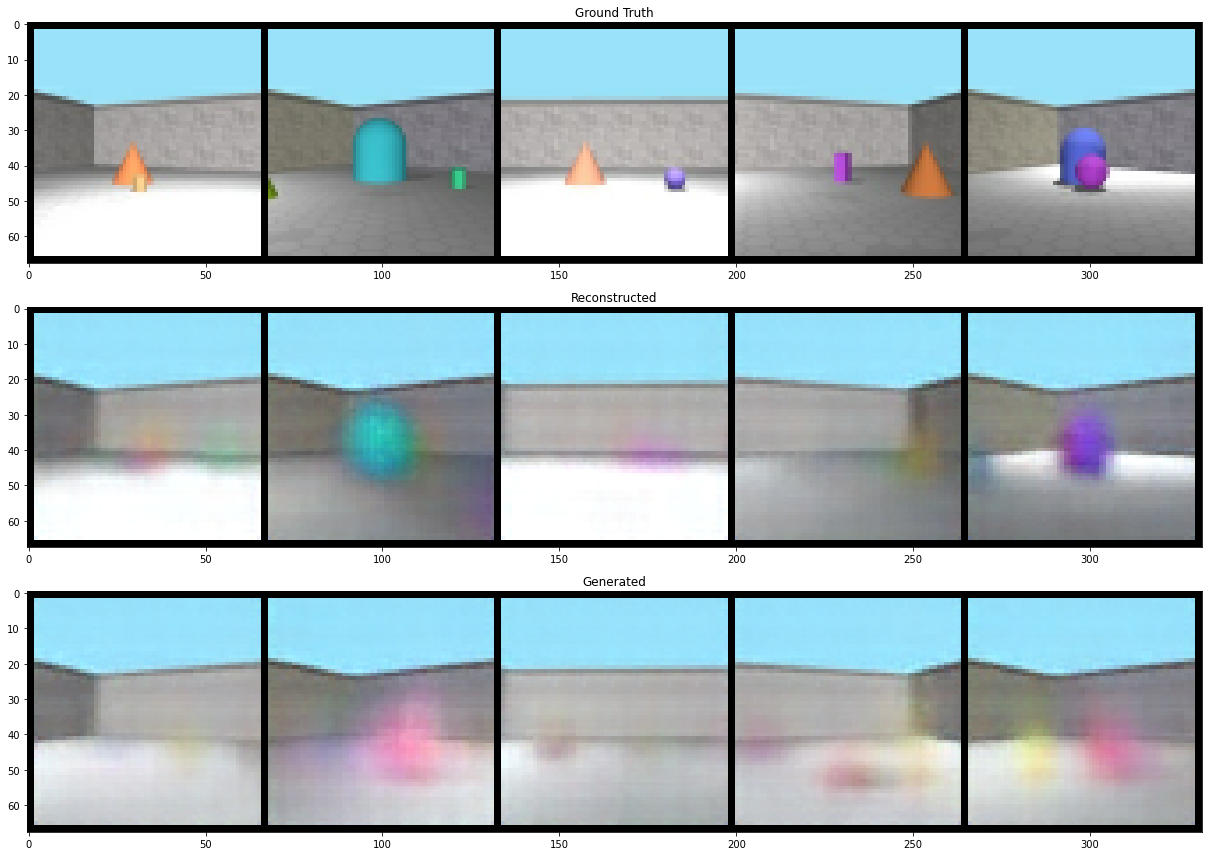

In [10]:
best_samples_df = test_df.nsmallest(5, 'loss', keep='all')
plot_grid(best_samples_df)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


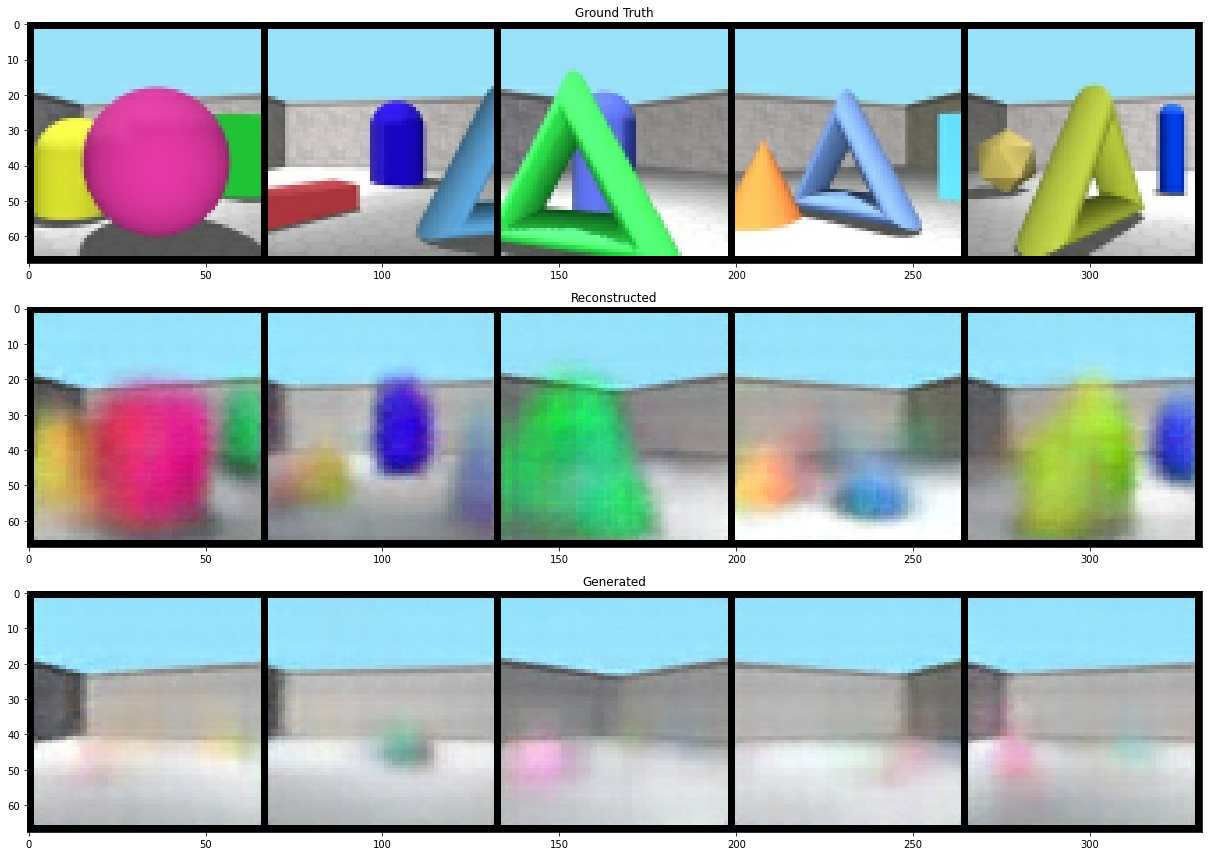

In [11]:
worst_samples_df = test_df.nlargest(5, 'loss', keep='all')
plot_grid(worst_samples_df)

### Change Views

In [12]:
j = random.randint(0,8) 
image_true = best_samples_df.GroundTruth.to_list()[4]
image_vw = best_samples_df.ImageView.to_list()[4]
views_other = best_samples_df.SceneViews.to_list()[4]
captions = best_samples_df.Captions.to_list()[4]

images_g = []
images_r = []
for j in tqdm(range(9)):
    views_other_ = views_other[:, j, :].view(1, 1, -1)
    captions_text = captions[j:j+1]
    mybatch = [image_true, image_vw, views_other_, captions_text]
    image, loss = model_inference(mybatch)
    image_g = model_inference.generate(mini_batch)

    images_r.append(image)
    images_g.append(image_g)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Generated')

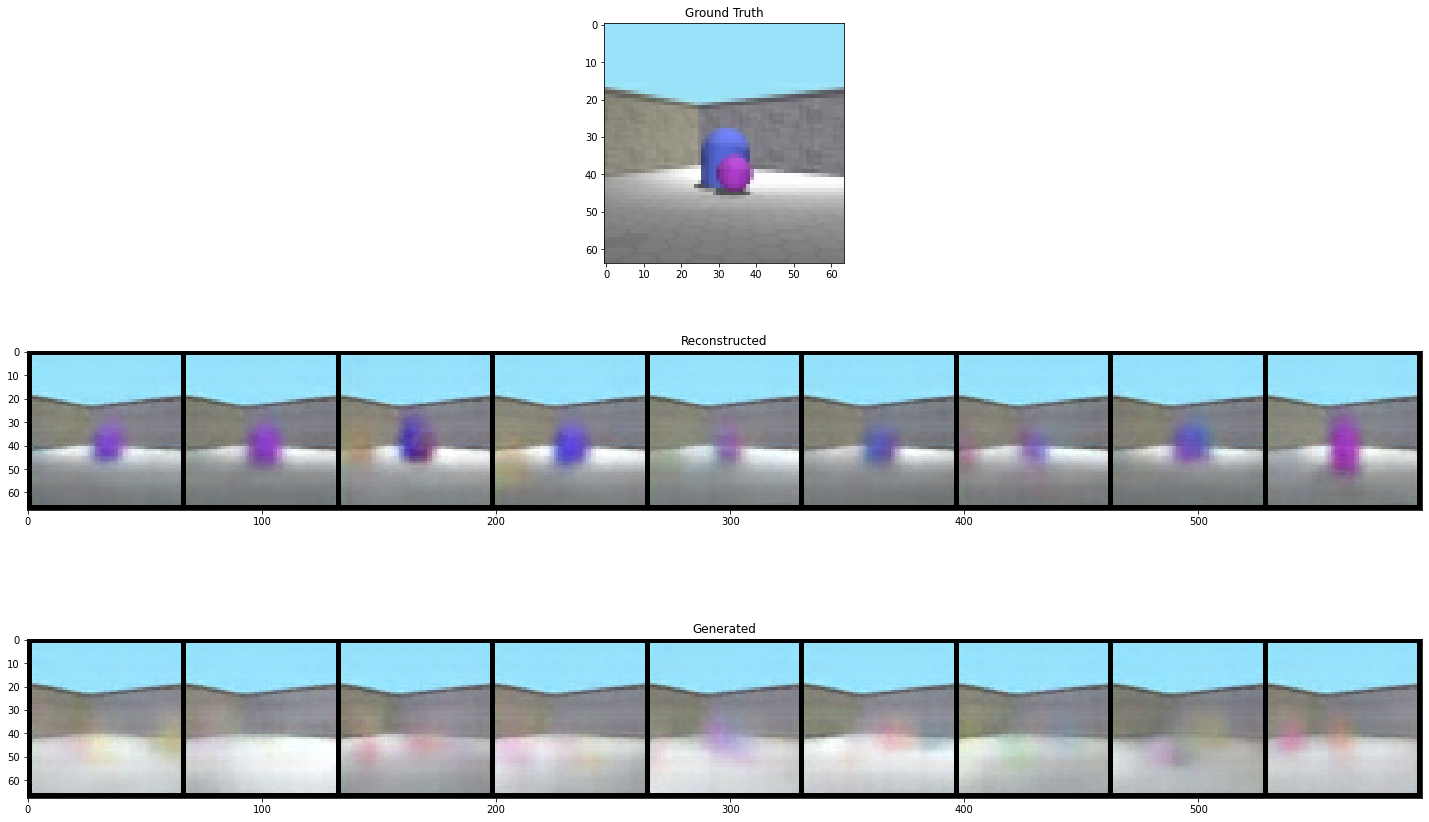

In [13]:
plt.figure(figsize=(25, 15))

plt.subplot(311)
img = image_true.cpu()
grid = make_grid(img).permute(1, 2, 0).numpy()
plt.imshow(grid, interpolation="nearest")
plt.title("Ground Truth")

plt.subplot(312)
img = torch.squeeze(torch.stack(images_r)).cpu()
grid = make_grid(img, nrow=9).permute(1, 2, 0).detach().numpy()
plt.imshow(grid, interpolation="nearest")
plt.title("Reconstructed")

plt.subplot(313)
img = torch.squeeze(torch.stack(images_g)).cpu()
grid = make_grid(img, nrow=9).permute(1, 2, 0).detach().numpy()
plt.imshow(grid, interpolation="nearest")
plt.title("Generated")